# 1. Construction for Physics-informed Neural Networks (PINN)

- Neural Networks play the role as modeling to approximate the PDE solution with given condition.
- The Given conditions(Data-driven) solutions in PDE / ODE are set as follows:

$$u_t + N[u; \lambda ] = 0, x \in \Omega, t \in [0,T] $$

where $u(t,x)$ denotes the solution, $N[.; \lambda]$ is a nonlinear operator with parameter $\lambda$, and the domain $\Omega$ is in $\mathbb{R}^D$.
    

# 2. Solving PDE/ ODE from Neural Networks

### 1. PDE / ODE  given boundary condition and initial condition setting

The concept involves employing neural networks to solve differential equations. This is achieved by utilizing a neural network to represent the solution and training it to meet the conditions specified by initial condition and boundary condition of the differential equation.

Consider a system of partial differential equations:

- $ \frac{du}{dt} = f(u, t) $ where $ t$ is in $[0, 1]$ and

- $ u(x, 0) = u_0 $ as given boundary condition.

- $ u(0, t) = g_1(x)$ and $ u(L, t) = g_2(x)$ as given initial condition where $\Omega = [0, L]$.



### 2. Solving the PDE / ODE
To solve this, we approximate the solution as a result of a neural network:

$$ NN(t) \approx u(t) $$

For the assumption as $NN(t)$ were the true solution, then we know $ NN'(t) = f(NN(t), t) $. 

### 3.  Error estimaties by Loss(Cost) function 
Based on the above $NN(t)$, our loss function is:

$$L(\omega) = \sum_i \left(\frac{dNN(t_i)}{dt} - f(NN(t_i), t_i)\right)^2 $$

The $ t_i $ can be chosen in various ways, such as randomly or on a grid. When this loss function is minimized, we have $ \frac{dNN(t_i)}{dt} \approx f(NN(t_i), t_i) $, and thus $ NN(t)$ approximately solves the differential equation.

On the PDE domain $ \Omega \times [0, t_0]$ of $(x,t)$, to reflect the boundary condition $u_0 = u (x, 0)$ and boundary condition $u(0, t), u(L, t)$ of our solution, these terms is added to the loss function:

$$ L(\omega) = \sum_i [ \left(\frac{dNN(t_i)}{dt} - f(NN(t_i), t_i)\right)^2 + (NN(0) - u_0)^2 + (NN(0,t) - u(0,t))^2+ (NN(L,t) - u(L,t))^2] $$

Here, $ \omega $  represents the parameters defining the neural network $ NN $ that approximates $ u $. This process result in finding weights that minimize the loss function.

# 3. Example - One Dimensional Heat Equation

In [195]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np



In [196]:
device = torch.device("cpu")

### 3.1 Define the class for Neural Network
We designate Net as our solution $u_\omega (x, t)$.

When constructing the network, it's crucial to consider the number of inputs and outputs. For the input variables, there are x and t. For the output variables, there is one variable u.

We can incorporate as many hidden layers as needed, each with as many neurons as desired. A more intricate network is better equipped to discover complex solutions, but it also demands more data.

Now, create this network as the following codes.
Minimum 8 hidden layers, each containing 5 neurons. The first def code indicates linear transformation of Neural Network, and the second def code means transfromation through Sigmoid activation function.


In [197]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5) # number of input variables = 2, output variables = 5
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.hidden_layer6 = nn.Linear(5,5)
        self.hidden_layer7 = nn.Linear(5,5)
        self.hidden_layer8 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # Merged two single-column arrays into a single array with two columns.
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs)) #Sigmoid function -> σ(x)= 1/(1+exp⁡(-x))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        layer6_out = torch.sigmoid(self.hidden_layer6(layer5_out))
        layer7_out = torch.sigmoid(self.hidden_layer7(layer6_out))
        layer8_out = torch.sigmoid(self.hidden_layer8(layer7_out))
        output = self.output_layer(layer8_out)
        ## For regression, no activation is used in output layer
        return output
# Result of the above class: 
# transformation x,t -> u -> sigmoid(u) through each hiddeon layer

### 3.2 Weight update setting - Optimizer
To iterate the nueral network, we update the weight of the linear model we set in chapter 2 by using Adam Algorithm.

In [198]:
from torch.optim import Adam
net = Net()
net = net.to(device)

# Set cost function as Mean squared error
mse_cost_function = torch.nn.MSELoss()

#Run Adam algorithm with output of the neural network processing.
optimizer = torch.optim.Adam(net.parameters()) 

### 3.3 Setting PDE with drawn u(x,t)
Employing the u(x,t) in the previous step, we set the 1-dimensional equation function f(x,t) for $ x \in [-2, 2]$ and $ t \in [0,1]$. Also we set its loss(cost) function to optimize the error bound.
The Heat equation setting is as follows with the code below:

The function $u(x, t)$, representing heat flow, needs to adhere to the partial differential equation below.
$$u_t = u_{xx}$$
Moreover, we impose two additional conditions. Initially, we set the temperature at both ends of the domain of $x$, specifying u(0, t) and u(L, t). Therefore, we assume that both ends are maintained at a temperature of 0 degrees Celsius:



In [199]:
# Partial Differential Equation (PDE) and its associated loss function.
def pde_loss(x, t, net):
    # The dependent variable 'u' is obtained from the network based on independent variables x and t.
    u = net(x, t)     
    # Before defining the PDE = du/dt - d^2(u)/(dx)^2, we need to compute du/dx and du/dt.
    u_x = torch.autograd.grad(u,x,torch.ones(u.shape),retain_graph=True,create_graph=True)[0]
    #torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x,x,torch.ones(u_x.shape),create_graph=True)[0] 
    #torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    # torch.autograd.grad <- Computes and returns the sum of gradients of outputs with respect to the inputs.
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_t - u_xx
    return pde


### 3.4 Boundary condition setting
Boundary condition for the heat equation is given as $u(x,0) = sin(\pi x)$ as follows. For the training data on the domain, is it used as the initial data.


In [200]:
# Data for Boundary Conditions
# Initial condition: u(x,0) = sin(pi * x)
# Boundary conditions provide initial data points for training.

# Boundary conditions state that for any x in the range [-2, 2] and time in [0, 1], the value of u is given by sin(pi * x).
# Generate 500 random numbers for x
x_bc = (2 - (-2)) *torch.rand(500,1) - 2
#np.random.uniform(low=0.0, high=6.0, size=(500,1))
t_bc = torch.zeros(500,1)

t_inner = torch.rand(500,1)
#np.zeros((500,1))
# Compute u based on the boundary condition: u(x,0) = sin(pi * x)
u_initial1 = t_bc
u_initial2 = t_bc
u_bc = np.sin(np.pi *x_bc)



### 3.5 Fitting model with training with iteration 20000
We train the data while optimizing the weight in the linear model of neural network.

In [201]:
# Setting the number of iterations
num_epochs = 20000
#prev_val_loss = 9999999.0 

# Iterating through epochs
for epoch in range(num_epochs):
    # Resetting gradients to zero
    optimizer.zero_grad()

    # Loss calculation based on boundary conditions
    input_x_bc = Variable(x_bc.float(), requires_grad=False).to(device)
    #input_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    input_t_bc = Variable(t_bc.float(), requires_grad=False).to(device)
    #input_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    
    
    target_u_bc = Variable(u_bc.float(), requires_grad=False).to(device)
    #target_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    target_u_initial1 = Variable(u_initial1.float(), requires_grad=False).to(device)
    target_u_initial2 = Variable(u_initial2.float(), requires_grad=False).to(device)

    # Getting network output for boundary condition and initial conditions
    output_bc = net(input_x_bc, input_t_bc)
    output_initial1 = net(input_t_bc, target_u_initial1)
    output_initial2 = net(input_t_bc, target_u_initial2)
    
    mse_u = mse_cost_function(output_bc, target_u_bc)
    mse_initial1 = mse_cost_function(u_initial1, target_u_initial1)
    mse_initial2 = mse_cost_function(u_initial2, target_u_initial2)
    # Loss calculation based on partial differential equation (PDE) 
    collocation_x = np.random.uniform(low= -2.0, high=2.0, size=(500, 1)) 
    collocation_t = np.random.uniform(low=0.0, high=1.0, size=(500, 1))
    all_zeros_target = np.zeros((500, 1))
    
    input_x_collocation = Variable(torch.from_numpy(collocation_x).float(), requires_grad=True).to(device)
    input_t_collocation = Variable(torch.from_numpy(collocation_t).float(), requires_grad=True).to(device)
    target_all_zeros = Variable(torch.from_numpy(all_zeros_target).float(), requires_grad=False).to(device)
    
    # Getting network output for PDE
    output_f = pde_loss(input_x_collocation, input_t_collocation, net)
    mse_f = mse_cost_function(output_f, target_all_zeros)
    
    # Combining the loss functions
    total_loss = mse_u + mse_f + mse_initial1 + mse_initial2
    
    # Backward propagation for computing gradients
    total_loss.backward()
    
    # Optimizer step to update parameters
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch, "Training Loss:", total_loss.data)

0 Training Loss: tensor(0.6745)
1 Training Loss: tensor(0.6706)
2 Training Loss: tensor(0.6667)
3 Training Loss: tensor(0.6629)
4 Training Loss: tensor(0.6591)
5 Training Loss: tensor(0.6554)
6 Training Loss: tensor(0.6517)
7 Training Loss: tensor(0.6481)
8 Training Loss: tensor(0.6445)
9 Training Loss: tensor(0.6409)
10 Training Loss: tensor(0.6374)
11 Training Loss: tensor(0.6340)
12 Training Loss: tensor(0.6306)
13 Training Loss: tensor(0.6272)
14 Training Loss: tensor(0.6239)
15 Training Loss: tensor(0.6207)
16 Training Loss: tensor(0.6175)
17 Training Loss: tensor(0.6143)
18 Training Loss: tensor(0.6112)
19 Training Loss: tensor(0.6082)
20 Training Loss: tensor(0.6052)
21 Training Loss: tensor(0.6022)
22 Training Loss: tensor(0.5993)
23 Training Loss: tensor(0.5965)
24 Training Loss: tensor(0.5937)
25 Training Loss: tensor(0.5909)
26 Training Loss: tensor(0.5883)
27 Training Loss: tensor(0.5856)
28 Training Loss: tensor(0.5830)
29 Training Loss: tensor(0.5805)
30 Training Loss: te

256 Training Loss: tensor(0.4956)
257 Training Loss: tensor(0.4956)
258 Training Loss: tensor(0.4956)
259 Training Loss: tensor(0.4956)
260 Training Loss: tensor(0.4956)
261 Training Loss: tensor(0.4956)
262 Training Loss: tensor(0.4956)
263 Training Loss: tensor(0.4956)
264 Training Loss: tensor(0.4956)
265 Training Loss: tensor(0.4956)
266 Training Loss: tensor(0.4956)
267 Training Loss: tensor(0.4956)
268 Training Loss: tensor(0.4956)
269 Training Loss: tensor(0.4956)
270 Training Loss: tensor(0.4956)
271 Training Loss: tensor(0.4956)
272 Training Loss: tensor(0.4956)
273 Training Loss: tensor(0.4956)
274 Training Loss: tensor(0.4956)
275 Training Loss: tensor(0.4956)
276 Training Loss: tensor(0.4956)
277 Training Loss: tensor(0.4956)
278 Training Loss: tensor(0.4956)
279 Training Loss: tensor(0.4956)
280 Training Loss: tensor(0.4956)
281 Training Loss: tensor(0.4956)
282 Training Loss: tensor(0.4956)
283 Training Loss: tensor(0.4956)
284 Training Loss: tensor(0.4956)
285 Training L

520 Training Loss: tensor(0.4956)
521 Training Loss: tensor(0.4956)
522 Training Loss: tensor(0.4956)
523 Training Loss: tensor(0.4956)
524 Training Loss: tensor(0.4956)
525 Training Loss: tensor(0.4956)
526 Training Loss: tensor(0.4956)
527 Training Loss: tensor(0.4956)
528 Training Loss: tensor(0.4956)
529 Training Loss: tensor(0.4956)
530 Training Loss: tensor(0.4956)
531 Training Loss: tensor(0.4956)
532 Training Loss: tensor(0.4956)
533 Training Loss: tensor(0.4956)
534 Training Loss: tensor(0.4956)
535 Training Loss: tensor(0.4956)
536 Training Loss: tensor(0.4956)
537 Training Loss: tensor(0.4956)
538 Training Loss: tensor(0.4956)
539 Training Loss: tensor(0.4956)
540 Training Loss: tensor(0.4956)
541 Training Loss: tensor(0.4956)
542 Training Loss: tensor(0.4956)
543 Training Loss: tensor(0.4956)
544 Training Loss: tensor(0.4956)
545 Training Loss: tensor(0.4956)
546 Training Loss: tensor(0.4956)
547 Training Loss: tensor(0.4956)
548 Training Loss: tensor(0.4956)
549 Training L

782 Training Loss: tensor(0.4956)
783 Training Loss: tensor(0.4956)
784 Training Loss: tensor(0.4956)
785 Training Loss: tensor(0.4956)
786 Training Loss: tensor(0.4956)
787 Training Loss: tensor(0.4956)
788 Training Loss: tensor(0.4956)
789 Training Loss: tensor(0.4956)
790 Training Loss: tensor(0.4956)
791 Training Loss: tensor(0.4956)
792 Training Loss: tensor(0.4956)
793 Training Loss: tensor(0.4956)
794 Training Loss: tensor(0.4956)
795 Training Loss: tensor(0.4956)
796 Training Loss: tensor(0.4956)
797 Training Loss: tensor(0.4956)
798 Training Loss: tensor(0.4956)
799 Training Loss: tensor(0.4956)
800 Training Loss: tensor(0.4956)
801 Training Loss: tensor(0.4956)
802 Training Loss: tensor(0.4956)
803 Training Loss: tensor(0.4956)
804 Training Loss: tensor(0.4956)
805 Training Loss: tensor(0.4956)
806 Training Loss: tensor(0.4956)
807 Training Loss: tensor(0.4956)
808 Training Loss: tensor(0.4956)
809 Training Loss: tensor(0.4956)
810 Training Loss: tensor(0.4956)
811 Training L

1033 Training Loss: tensor(0.4955)
1034 Training Loss: tensor(0.4955)
1035 Training Loss: tensor(0.4955)
1036 Training Loss: tensor(0.4955)
1037 Training Loss: tensor(0.4955)
1038 Training Loss: tensor(0.4955)
1039 Training Loss: tensor(0.4955)
1040 Training Loss: tensor(0.4955)
1041 Training Loss: tensor(0.4955)
1042 Training Loss: tensor(0.4955)
1043 Training Loss: tensor(0.4955)
1044 Training Loss: tensor(0.4955)
1045 Training Loss: tensor(0.4955)
1046 Training Loss: tensor(0.4955)
1047 Training Loss: tensor(0.4955)
1048 Training Loss: tensor(0.4955)
1049 Training Loss: tensor(0.4955)
1050 Training Loss: tensor(0.4955)
1051 Training Loss: tensor(0.4954)
1052 Training Loss: tensor(0.4954)
1053 Training Loss: tensor(0.4954)
1054 Training Loss: tensor(0.4954)
1055 Training Loss: tensor(0.4954)
1056 Training Loss: tensor(0.4954)
1057 Training Loss: tensor(0.4954)
1058 Training Loss: tensor(0.4954)
1059 Training Loss: tensor(0.4954)
1060 Training Loss: tensor(0.4954)
1061 Training Loss: 

1280 Training Loss: tensor(0.4895)
1281 Training Loss: tensor(0.4894)
1282 Training Loss: tensor(0.4893)
1283 Training Loss: tensor(0.4893)
1284 Training Loss: tensor(0.4893)
1285 Training Loss: tensor(0.4893)
1286 Training Loss: tensor(0.4892)
1287 Training Loss: tensor(0.4891)
1288 Training Loss: tensor(0.4889)
1289 Training Loss: tensor(0.4889)
1290 Training Loss: tensor(0.4887)
1291 Training Loss: tensor(0.4887)
1292 Training Loss: tensor(0.4887)
1293 Training Loss: tensor(0.4884)
1294 Training Loss: tensor(0.4885)
1295 Training Loss: tensor(0.4883)
1296 Training Loss: tensor(0.4882)
1297 Training Loss: tensor(0.4882)
1298 Training Loss: tensor(0.4882)
1299 Training Loss: tensor(0.4882)
1300 Training Loss: tensor(0.4878)
1301 Training Loss: tensor(0.4880)
1302 Training Loss: tensor(0.4878)
1303 Training Loss: tensor(0.4877)
1304 Training Loss: tensor(0.4876)
1305 Training Loss: tensor(0.4875)
1306 Training Loss: tensor(0.4874)
1307 Training Loss: tensor(0.4874)
1308 Training Loss: 

1532 Training Loss: tensor(0.4340)
1533 Training Loss: tensor(0.4343)
1534 Training Loss: tensor(0.4333)
1535 Training Loss: tensor(0.4344)
1536 Training Loss: tensor(0.4345)
1537 Training Loss: tensor(0.4310)
1538 Training Loss: tensor(0.4309)
1539 Training Loss: tensor(0.4314)
1540 Training Loss: tensor(0.4309)
1541 Training Loss: tensor(0.4300)
1542 Training Loss: tensor(0.4319)
1543 Training Loss: tensor(0.4292)
1544 Training Loss: tensor(0.4296)
1545 Training Loss: tensor(0.4284)
1546 Training Loss: tensor(0.4299)
1547 Training Loss: tensor(0.4297)
1548 Training Loss: tensor(0.4301)
1549 Training Loss: tensor(0.4299)
1550 Training Loss: tensor(0.4289)
1551 Training Loss: tensor(0.4259)
1552 Training Loss: tensor(0.4276)
1553 Training Loss: tensor(0.4269)
1554 Training Loss: tensor(0.4250)
1555 Training Loss: tensor(0.4258)
1556 Training Loss: tensor(0.4265)
1557 Training Loss: tensor(0.4310)
1558 Training Loss: tensor(0.4261)
1559 Training Loss: tensor(0.4272)
1560 Training Loss: 

1779 Training Loss: tensor(0.3975)
1780 Training Loss: tensor(0.4015)
1781 Training Loss: tensor(0.3993)
1782 Training Loss: tensor(0.4004)
1783 Training Loss: tensor(0.3997)
1784 Training Loss: tensor(0.4004)
1785 Training Loss: tensor(0.4025)
1786 Training Loss: tensor(0.4022)
1787 Training Loss: tensor(0.4010)
1788 Training Loss: tensor(0.3984)
1789 Training Loss: tensor(0.4040)
1790 Training Loss: tensor(0.4023)
1791 Training Loss: tensor(0.3975)
1792 Training Loss: tensor(0.3989)
1793 Training Loss: tensor(0.3998)
1794 Training Loss: tensor(0.3994)
1795 Training Loss: tensor(0.3965)
1796 Training Loss: tensor(0.3978)
1797 Training Loss: tensor(0.4013)
1798 Training Loss: tensor(0.4002)
1799 Training Loss: tensor(0.4039)
1800 Training Loss: tensor(0.4031)
1801 Training Loss: tensor(0.4007)
1802 Training Loss: tensor(0.3991)
1803 Training Loss: tensor(0.4004)
1804 Training Loss: tensor(0.4011)
1805 Training Loss: tensor(0.3995)
1806 Training Loss: tensor(0.4004)
1807 Training Loss: 

2037 Training Loss: tensor(0.3922)
2038 Training Loss: tensor(0.3961)
2039 Training Loss: tensor(0.3937)
2040 Training Loss: tensor(0.3955)
2041 Training Loss: tensor(0.3939)
2042 Training Loss: tensor(0.3936)
2043 Training Loss: tensor(0.3925)
2044 Training Loss: tensor(0.3935)
2045 Training Loss: tensor(0.3938)
2046 Training Loss: tensor(0.3935)
2047 Training Loss: tensor(0.3991)
2048 Training Loss: tensor(0.3952)
2049 Training Loss: tensor(0.3957)
2050 Training Loss: tensor(0.3951)
2051 Training Loss: tensor(0.3949)
2052 Training Loss: tensor(0.3908)
2053 Training Loss: tensor(0.3935)
2054 Training Loss: tensor(0.3955)
2055 Training Loss: tensor(0.3941)
2056 Training Loss: tensor(0.3935)
2057 Training Loss: tensor(0.3945)
2058 Training Loss: tensor(0.3947)
2059 Training Loss: tensor(0.3959)
2060 Training Loss: tensor(0.3943)
2061 Training Loss: tensor(0.3948)
2062 Training Loss: tensor(0.3947)
2063 Training Loss: tensor(0.3955)
2064 Training Loss: tensor(0.3940)
2065 Training Loss: 

2284 Training Loss: tensor(0.3924)
2285 Training Loss: tensor(0.3883)
2286 Training Loss: tensor(0.3923)
2287 Training Loss: tensor(0.3916)
2288 Training Loss: tensor(0.3939)
2289 Training Loss: tensor(0.3931)
2290 Training Loss: tensor(0.3940)
2291 Training Loss: tensor(0.3900)
2292 Training Loss: tensor(0.3898)
2293 Training Loss: tensor(0.3899)
2294 Training Loss: tensor(0.3900)
2295 Training Loss: tensor(0.3912)
2296 Training Loss: tensor(0.3941)
2297 Training Loss: tensor(0.3898)
2298 Training Loss: tensor(0.3917)
2299 Training Loss: tensor(0.3888)
2300 Training Loss: tensor(0.3892)
2301 Training Loss: tensor(0.3932)
2302 Training Loss: tensor(0.3925)
2303 Training Loss: tensor(0.3926)
2304 Training Loss: tensor(0.3899)
2305 Training Loss: tensor(0.3895)
2306 Training Loss: tensor(0.3928)
2307 Training Loss: tensor(0.3906)
2308 Training Loss: tensor(0.3926)
2309 Training Loss: tensor(0.3914)
2310 Training Loss: tensor(0.3907)
2311 Training Loss: tensor(0.3900)
2312 Training Loss: 

2541 Training Loss: tensor(0.3928)
2542 Training Loss: tensor(0.3915)
2543 Training Loss: tensor(0.3898)
2544 Training Loss: tensor(0.3911)
2545 Training Loss: tensor(0.3866)
2546 Training Loss: tensor(0.3891)
2547 Training Loss: tensor(0.3898)
2548 Training Loss: tensor(0.3897)
2549 Training Loss: tensor(0.3925)
2550 Training Loss: tensor(0.3886)
2551 Training Loss: tensor(0.3890)
2552 Training Loss: tensor(0.3901)
2553 Training Loss: tensor(0.3889)
2554 Training Loss: tensor(0.3868)
2555 Training Loss: tensor(0.3877)
2556 Training Loss: tensor(0.3926)
2557 Training Loss: tensor(0.3902)
2558 Training Loss: tensor(0.3910)
2559 Training Loss: tensor(0.3959)
2560 Training Loss: tensor(0.3907)
2561 Training Loss: tensor(0.3902)
2562 Training Loss: tensor(0.3887)
2563 Training Loss: tensor(0.3921)
2564 Training Loss: tensor(0.3894)
2565 Training Loss: tensor(0.3882)
2566 Training Loss: tensor(0.3870)
2567 Training Loss: tensor(0.3874)
2568 Training Loss: tensor(0.3882)
2569 Training Loss: 

2777 Training Loss: tensor(0.3854)
2778 Training Loss: tensor(0.3880)
2779 Training Loss: tensor(0.3882)
2780 Training Loss: tensor(0.3860)
2781 Training Loss: tensor(0.3895)
2782 Training Loss: tensor(0.3880)
2783 Training Loss: tensor(0.3866)
2784 Training Loss: tensor(0.3864)
2785 Training Loss: tensor(0.3874)
2786 Training Loss: tensor(0.3865)
2787 Training Loss: tensor(0.3865)
2788 Training Loss: tensor(0.3853)
2789 Training Loss: tensor(0.3882)
2790 Training Loss: tensor(0.3917)
2791 Training Loss: tensor(0.3857)
2792 Training Loss: tensor(0.3888)
2793 Training Loss: tensor(0.3851)
2794 Training Loss: tensor(0.3939)
2795 Training Loss: tensor(0.3871)
2796 Training Loss: tensor(0.3908)
2797 Training Loss: tensor(0.3883)
2798 Training Loss: tensor(0.3878)
2799 Training Loss: tensor(0.3898)
2800 Training Loss: tensor(0.3876)
2801 Training Loss: tensor(0.3877)
2802 Training Loss: tensor(0.3885)
2803 Training Loss: tensor(0.3868)
2804 Training Loss: tensor(0.3879)
2805 Training Loss: 

3019 Training Loss: tensor(0.3844)
3020 Training Loss: tensor(0.3860)
3021 Training Loss: tensor(0.3868)
3022 Training Loss: tensor(0.3861)
3023 Training Loss: tensor(0.3846)
3024 Training Loss: tensor(0.3911)
3025 Training Loss: tensor(0.3877)
3026 Training Loss: tensor(0.3856)
3027 Training Loss: tensor(0.3836)
3028 Training Loss: tensor(0.3920)
3029 Training Loss: tensor(0.3848)
3030 Training Loss: tensor(0.3881)
3031 Training Loss: tensor(0.3868)
3032 Training Loss: tensor(0.3853)
3033 Training Loss: tensor(0.3855)
3034 Training Loss: tensor(0.3871)
3035 Training Loss: tensor(0.3839)
3036 Training Loss: tensor(0.3831)
3037 Training Loss: tensor(0.3873)
3038 Training Loss: tensor(0.3834)
3039 Training Loss: tensor(0.3852)
3040 Training Loss: tensor(0.3892)
3041 Training Loss: tensor(0.3837)
3042 Training Loss: tensor(0.3837)
3043 Training Loss: tensor(0.3849)
3044 Training Loss: tensor(0.3864)
3045 Training Loss: tensor(0.3874)
3046 Training Loss: tensor(0.3864)
3047 Training Loss: 

3274 Training Loss: tensor(0.3817)
3275 Training Loss: tensor(0.3843)
3276 Training Loss: tensor(0.3875)
3277 Training Loss: tensor(0.3861)
3278 Training Loss: tensor(0.3837)
3279 Training Loss: tensor(0.3884)
3280 Training Loss: tensor(0.3837)
3281 Training Loss: tensor(0.3861)
3282 Training Loss: tensor(0.3815)
3283 Training Loss: tensor(0.3849)
3284 Training Loss: tensor(0.3857)
3285 Training Loss: tensor(0.3828)
3286 Training Loss: tensor(0.3859)
3287 Training Loss: tensor(0.3877)
3288 Training Loss: tensor(0.3847)
3289 Training Loss: tensor(0.3882)
3290 Training Loss: tensor(0.3838)
3291 Training Loss: tensor(0.3850)
3292 Training Loss: tensor(0.3815)
3293 Training Loss: tensor(0.3834)
3294 Training Loss: tensor(0.3855)
3295 Training Loss: tensor(0.3871)
3296 Training Loss: tensor(0.3880)
3297 Training Loss: tensor(0.3835)
3298 Training Loss: tensor(0.3820)
3299 Training Loss: tensor(0.3907)
3300 Training Loss: tensor(0.3817)
3301 Training Loss: tensor(0.3854)
3302 Training Loss: 

3516 Training Loss: tensor(0.3828)
3517 Training Loss: tensor(0.3817)
3518 Training Loss: tensor(0.3885)
3519 Training Loss: tensor(0.3802)
3520 Training Loss: tensor(0.3857)
3521 Training Loss: tensor(0.3903)
3522 Training Loss: tensor(0.3861)
3523 Training Loss: tensor(0.3853)
3524 Training Loss: tensor(0.3822)
3525 Training Loss: tensor(0.3837)
3526 Training Loss: tensor(0.3870)
3527 Training Loss: tensor(0.3874)
3528 Training Loss: tensor(0.3823)
3529 Training Loss: tensor(0.3831)
3530 Training Loss: tensor(0.3839)
3531 Training Loss: tensor(0.3849)
3532 Training Loss: tensor(0.3822)
3533 Training Loss: tensor(0.3855)
3534 Training Loss: tensor(0.3853)
3535 Training Loss: tensor(0.3840)
3536 Training Loss: tensor(0.3830)
3537 Training Loss: tensor(0.3830)
3538 Training Loss: tensor(0.3859)
3539 Training Loss: tensor(0.3838)
3540 Training Loss: tensor(0.3871)
3541 Training Loss: tensor(0.3841)
3542 Training Loss: tensor(0.3858)
3543 Training Loss: tensor(0.3823)
3544 Training Loss: 

3777 Training Loss: tensor(0.3809)
3778 Training Loss: tensor(0.3825)
3779 Training Loss: tensor(0.3805)
3780 Training Loss: tensor(0.3847)
3781 Training Loss: tensor(0.3821)
3782 Training Loss: tensor(0.3831)
3783 Training Loss: tensor(0.3817)
3784 Training Loss: tensor(0.3837)
3785 Training Loss: tensor(0.3815)
3786 Training Loss: tensor(0.3821)
3787 Training Loss: tensor(0.3816)
3788 Training Loss: tensor(0.3822)
3789 Training Loss: tensor(0.3829)
3790 Training Loss: tensor(0.3803)
3791 Training Loss: tensor(0.3844)
3792 Training Loss: tensor(0.3810)
3793 Training Loss: tensor(0.3807)
3794 Training Loss: tensor(0.3833)
3795 Training Loss: tensor(0.3836)
3796 Training Loss: tensor(0.3809)
3797 Training Loss: tensor(0.3801)
3798 Training Loss: tensor(0.3817)
3799 Training Loss: tensor(0.3835)
3800 Training Loss: tensor(0.3831)
3801 Training Loss: tensor(0.3827)
3802 Training Loss: tensor(0.3829)
3803 Training Loss: tensor(0.3862)
3804 Training Loss: tensor(0.3818)
3805 Training Loss: 

4016 Training Loss: tensor(0.3838)
4017 Training Loss: tensor(0.3832)
4018 Training Loss: tensor(0.3805)
4019 Training Loss: tensor(0.3808)
4020 Training Loss: tensor(0.3797)
4021 Training Loss: tensor(0.3795)
4022 Training Loss: tensor(0.3809)
4023 Training Loss: tensor(0.3789)
4024 Training Loss: tensor(0.3854)
4025 Training Loss: tensor(0.3791)
4026 Training Loss: tensor(0.3829)
4027 Training Loss: tensor(0.3799)
4028 Training Loss: tensor(0.3836)
4029 Training Loss: tensor(0.3828)
4030 Training Loss: tensor(0.3810)
4031 Training Loss: tensor(0.3819)
4032 Training Loss: tensor(0.3830)
4033 Training Loss: tensor(0.3810)
4034 Training Loss: tensor(0.3788)
4035 Training Loss: tensor(0.3782)
4036 Training Loss: tensor(0.3878)
4037 Training Loss: tensor(0.3807)
4038 Training Loss: tensor(0.3822)
4039 Training Loss: tensor(0.3836)
4040 Training Loss: tensor(0.3840)
4041 Training Loss: tensor(0.3826)
4042 Training Loss: tensor(0.3834)
4043 Training Loss: tensor(0.3807)
4044 Training Loss: 

4258 Training Loss: tensor(0.3818)
4259 Training Loss: tensor(0.3811)
4260 Training Loss: tensor(0.3822)
4261 Training Loss: tensor(0.3840)
4262 Training Loss: tensor(0.3771)
4263 Training Loss: tensor(0.3804)
4264 Training Loss: tensor(0.3810)
4265 Training Loss: tensor(0.3815)
4266 Training Loss: tensor(0.3813)
4267 Training Loss: tensor(0.3805)
4268 Training Loss: tensor(0.3805)
4269 Training Loss: tensor(0.3855)
4270 Training Loss: tensor(0.3805)
4271 Training Loss: tensor(0.3809)
4272 Training Loss: tensor(0.3807)
4273 Training Loss: tensor(0.3794)
4274 Training Loss: tensor(0.3812)
4275 Training Loss: tensor(0.3827)
4276 Training Loss: tensor(0.3797)
4277 Training Loss: tensor(0.3840)
4278 Training Loss: tensor(0.3818)
4279 Training Loss: tensor(0.3803)
4280 Training Loss: tensor(0.3813)
4281 Training Loss: tensor(0.3814)
4282 Training Loss: tensor(0.3786)
4283 Training Loss: tensor(0.3820)
4284 Training Loss: tensor(0.3781)
4285 Training Loss: tensor(0.3822)
4286 Training Loss: 

4503 Training Loss: tensor(0.3842)
4504 Training Loss: tensor(0.3824)
4505 Training Loss: tensor(0.3793)
4506 Training Loss: tensor(0.3787)
4507 Training Loss: tensor(0.3801)
4508 Training Loss: tensor(0.3766)
4509 Training Loss: tensor(0.3805)
4510 Training Loss: tensor(0.3796)
4511 Training Loss: tensor(0.3817)
4512 Training Loss: tensor(0.3830)
4513 Training Loss: tensor(0.3791)
4514 Training Loss: tensor(0.3803)
4515 Training Loss: tensor(0.3800)
4516 Training Loss: tensor(0.3805)
4517 Training Loss: tensor(0.3800)
4518 Training Loss: tensor(0.3786)
4519 Training Loss: tensor(0.3805)
4520 Training Loss: tensor(0.3831)
4521 Training Loss: tensor(0.3798)
4522 Training Loss: tensor(0.3764)
4523 Training Loss: tensor(0.3767)
4524 Training Loss: tensor(0.3784)
4525 Training Loss: tensor(0.3801)
4526 Training Loss: tensor(0.3828)
4527 Training Loss: tensor(0.3779)
4528 Training Loss: tensor(0.3810)
4529 Training Loss: tensor(0.3835)
4530 Training Loss: tensor(0.3823)
4531 Training Loss: 

4745 Training Loss: tensor(0.3791)
4746 Training Loss: tensor(0.3795)
4747 Training Loss: tensor(0.3819)
4748 Training Loss: tensor(0.3823)
4749 Training Loss: tensor(0.3787)
4750 Training Loss: tensor(0.3814)
4751 Training Loss: tensor(0.3782)
4752 Training Loss: tensor(0.3797)
4753 Training Loss: tensor(0.3821)
4754 Training Loss: tensor(0.3807)
4755 Training Loss: tensor(0.3782)
4756 Training Loss: tensor(0.3855)
4757 Training Loss: tensor(0.3806)
4758 Training Loss: tensor(0.3785)
4759 Training Loss: tensor(0.3765)
4760 Training Loss: tensor(0.3807)
4761 Training Loss: tensor(0.3789)
4762 Training Loss: tensor(0.3779)
4763 Training Loss: tensor(0.3776)
4764 Training Loss: tensor(0.3804)
4765 Training Loss: tensor(0.3800)
4766 Training Loss: tensor(0.3788)
4767 Training Loss: tensor(0.3792)
4768 Training Loss: tensor(0.3785)
4769 Training Loss: tensor(0.3785)
4770 Training Loss: tensor(0.3779)
4771 Training Loss: tensor(0.3770)
4772 Training Loss: tensor(0.3851)
4773 Training Loss: 

4991 Training Loss: tensor(0.3771)
4992 Training Loss: tensor(0.3785)
4993 Training Loss: tensor(0.3781)
4994 Training Loss: tensor(0.3798)
4995 Training Loss: tensor(0.3825)
4996 Training Loss: tensor(0.3811)
4997 Training Loss: tensor(0.3771)
4998 Training Loss: tensor(0.3800)
4999 Training Loss: tensor(0.3786)
5000 Training Loss: tensor(0.3768)
5001 Training Loss: tensor(0.3803)
5002 Training Loss: tensor(0.3786)
5003 Training Loss: tensor(0.3776)
5004 Training Loss: tensor(0.3785)
5005 Training Loss: tensor(0.3798)
5006 Training Loss: tensor(0.3769)
5007 Training Loss: tensor(0.3788)
5008 Training Loss: tensor(0.3791)
5009 Training Loss: tensor(0.3793)
5010 Training Loss: tensor(0.3763)
5011 Training Loss: tensor(0.3784)
5012 Training Loss: tensor(0.3803)
5013 Training Loss: tensor(0.3814)
5014 Training Loss: tensor(0.3760)
5015 Training Loss: tensor(0.3799)
5016 Training Loss: tensor(0.3772)
5017 Training Loss: tensor(0.3773)
5018 Training Loss: tensor(0.3770)
5019 Training Loss: 

5230 Training Loss: tensor(0.3818)
5231 Training Loss: tensor(0.3749)
5232 Training Loss: tensor(0.3781)
5233 Training Loss: tensor(0.3746)
5234 Training Loss: tensor(0.3794)
5235 Training Loss: tensor(0.3767)
5236 Training Loss: tensor(0.3844)
5237 Training Loss: tensor(0.3812)
5238 Training Loss: tensor(0.3763)
5239 Training Loss: tensor(0.3784)
5240 Training Loss: tensor(0.3742)
5241 Training Loss: tensor(0.3768)
5242 Training Loss: tensor(0.3794)
5243 Training Loss: tensor(0.3761)
5244 Training Loss: tensor(0.3763)
5245 Training Loss: tensor(0.3763)
5246 Training Loss: tensor(0.3743)
5247 Training Loss: tensor(0.3785)
5248 Training Loss: tensor(0.3781)
5249 Training Loss: tensor(0.3784)
5250 Training Loss: tensor(0.3772)
5251 Training Loss: tensor(0.3787)
5252 Training Loss: tensor(0.3774)
5253 Training Loss: tensor(0.3766)
5254 Training Loss: tensor(0.3815)
5255 Training Loss: tensor(0.3816)
5256 Training Loss: tensor(0.3777)
5257 Training Loss: tensor(0.3789)
5258 Training Loss: 

5468 Training Loss: tensor(0.3762)
5469 Training Loss: tensor(0.3759)
5470 Training Loss: tensor(0.3764)
5471 Training Loss: tensor(0.3781)
5472 Training Loss: tensor(0.3795)
5473 Training Loss: tensor(0.3772)
5474 Training Loss: tensor(0.3764)
5475 Training Loss: tensor(0.3774)
5476 Training Loss: tensor(0.3787)
5477 Training Loss: tensor(0.3802)
5478 Training Loss: tensor(0.3789)
5479 Training Loss: tensor(0.3802)
5480 Training Loss: tensor(0.3784)
5481 Training Loss: tensor(0.3775)
5482 Training Loss: tensor(0.3814)
5483 Training Loss: tensor(0.3783)
5484 Training Loss: tensor(0.3837)
5485 Training Loss: tensor(0.3765)
5486 Training Loss: tensor(0.3770)
5487 Training Loss: tensor(0.3760)
5488 Training Loss: tensor(0.3787)
5489 Training Loss: tensor(0.3783)
5490 Training Loss: tensor(0.3771)
5491 Training Loss: tensor(0.3796)
5492 Training Loss: tensor(0.3774)
5493 Training Loss: tensor(0.3772)
5494 Training Loss: tensor(0.3815)
5495 Training Loss: tensor(0.3774)
5496 Training Loss: 

5713 Training Loss: tensor(0.3755)
5714 Training Loss: tensor(0.3761)
5715 Training Loss: tensor(0.3768)
5716 Training Loss: tensor(0.3783)
5717 Training Loss: tensor(0.3802)
5718 Training Loss: tensor(0.3808)
5719 Training Loss: tensor(0.3785)
5720 Training Loss: tensor(0.3783)
5721 Training Loss: tensor(0.3775)
5722 Training Loss: tensor(0.3752)
5723 Training Loss: tensor(0.3746)
5724 Training Loss: tensor(0.3742)
5725 Training Loss: tensor(0.3730)
5726 Training Loss: tensor(0.3763)
5727 Training Loss: tensor(0.3814)
5728 Training Loss: tensor(0.3754)
5729 Training Loss: tensor(0.3798)
5730 Training Loss: tensor(0.3763)
5731 Training Loss: tensor(0.3782)
5732 Training Loss: tensor(0.3793)
5733 Training Loss: tensor(0.3807)
5734 Training Loss: tensor(0.3804)
5735 Training Loss: tensor(0.3809)
5736 Training Loss: tensor(0.3771)
5737 Training Loss: tensor(0.3758)
5738 Training Loss: tensor(0.3761)
5739 Training Loss: tensor(0.3842)
5740 Training Loss: tensor(0.3832)
5741 Training Loss: 

5969 Training Loss: tensor(0.3768)
5970 Training Loss: tensor(0.3781)
5971 Training Loss: tensor(0.3767)
5972 Training Loss: tensor(0.3746)
5973 Training Loss: tensor(0.3770)
5974 Training Loss: tensor(0.3756)
5975 Training Loss: tensor(0.3745)
5976 Training Loss: tensor(0.3760)
5977 Training Loss: tensor(0.3748)
5978 Training Loss: tensor(0.3771)
5979 Training Loss: tensor(0.3762)
5980 Training Loss: tensor(0.3747)
5981 Training Loss: tensor(0.3744)
5982 Training Loss: tensor(0.3746)
5983 Training Loss: tensor(0.3793)
5984 Training Loss: tensor(0.3802)
5985 Training Loss: tensor(0.3777)
5986 Training Loss: tensor(0.3776)
5987 Training Loss: tensor(0.3794)
5988 Training Loss: tensor(0.3754)
5989 Training Loss: tensor(0.3760)
5990 Training Loss: tensor(0.3770)
5991 Training Loss: tensor(0.3799)
5992 Training Loss: tensor(0.3796)
5993 Training Loss: tensor(0.3770)
5994 Training Loss: tensor(0.3735)
5995 Training Loss: tensor(0.3752)
5996 Training Loss: tensor(0.3743)
5997 Training Loss: 

6222 Training Loss: tensor(0.3758)
6223 Training Loss: tensor(0.3767)
6224 Training Loss: tensor(0.3792)
6225 Training Loss: tensor(0.3759)
6226 Training Loss: tensor(0.3769)
6227 Training Loss: tensor(0.3742)
6228 Training Loss: tensor(0.3740)
6229 Training Loss: tensor(0.3769)
6230 Training Loss: tensor(0.3796)
6231 Training Loss: tensor(0.3741)
6232 Training Loss: tensor(0.3762)
6233 Training Loss: tensor(0.3755)
6234 Training Loss: tensor(0.3752)
6235 Training Loss: tensor(0.3762)
6236 Training Loss: tensor(0.3793)
6237 Training Loss: tensor(0.3732)
6238 Training Loss: tensor(0.3788)
6239 Training Loss: tensor(0.3807)
6240 Training Loss: tensor(0.3718)
6241 Training Loss: tensor(0.3768)
6242 Training Loss: tensor(0.3747)
6243 Training Loss: tensor(0.3740)
6244 Training Loss: tensor(0.3778)
6245 Training Loss: tensor(0.3778)
6246 Training Loss: tensor(0.3790)
6247 Training Loss: tensor(0.3742)
6248 Training Loss: tensor(0.3771)
6249 Training Loss: tensor(0.3738)
6250 Training Loss: 

6479 Training Loss: tensor(0.3797)
6480 Training Loss: tensor(0.3786)
6481 Training Loss: tensor(0.3742)
6482 Training Loss: tensor(0.3759)
6483 Training Loss: tensor(0.3787)
6484 Training Loss: tensor(0.3737)
6485 Training Loss: tensor(0.3765)
6486 Training Loss: tensor(0.3747)
6487 Training Loss: tensor(0.3771)
6488 Training Loss: tensor(0.3753)
6489 Training Loss: tensor(0.3745)
6490 Training Loss: tensor(0.3750)
6491 Training Loss: tensor(0.3731)
6492 Training Loss: tensor(0.3749)
6493 Training Loss: tensor(0.3785)
6494 Training Loss: tensor(0.3771)
6495 Training Loss: tensor(0.3716)
6496 Training Loss: tensor(0.3822)
6497 Training Loss: tensor(0.3768)
6498 Training Loss: tensor(0.3769)
6499 Training Loss: tensor(0.3815)
6500 Training Loss: tensor(0.3742)
6501 Training Loss: tensor(0.3725)
6502 Training Loss: tensor(0.3754)
6503 Training Loss: tensor(0.3756)
6504 Training Loss: tensor(0.3804)
6505 Training Loss: tensor(0.3744)
6506 Training Loss: tensor(0.3768)
6507 Training Loss: 

6731 Training Loss: tensor(0.3762)
6732 Training Loss: tensor(0.3751)
6733 Training Loss: tensor(0.3741)
6734 Training Loss: tensor(0.3724)
6735 Training Loss: tensor(0.3725)
6736 Training Loss: tensor(0.3792)
6737 Training Loss: tensor(0.3726)
6738 Training Loss: tensor(0.3779)
6739 Training Loss: tensor(0.3787)
6740 Training Loss: tensor(0.3777)
6741 Training Loss: tensor(0.3787)
6742 Training Loss: tensor(0.3732)
6743 Training Loss: tensor(0.3734)
6744 Training Loss: tensor(0.3800)
6745 Training Loss: tensor(0.3776)
6746 Training Loss: tensor(0.3820)
6747 Training Loss: tensor(0.3722)
6748 Training Loss: tensor(0.3759)
6749 Training Loss: tensor(0.3747)
6750 Training Loss: tensor(0.3766)
6751 Training Loss: tensor(0.3753)
6752 Training Loss: tensor(0.3737)
6753 Training Loss: tensor(0.3754)
6754 Training Loss: tensor(0.3726)
6755 Training Loss: tensor(0.3761)
6756 Training Loss: tensor(0.3754)
6757 Training Loss: tensor(0.3789)
6758 Training Loss: tensor(0.3768)
6759 Training Loss: 

6983 Training Loss: tensor(0.3743)
6984 Training Loss: tensor(0.3712)
6985 Training Loss: tensor(0.3708)
6986 Training Loss: tensor(0.3738)
6987 Training Loss: tensor(0.3764)
6988 Training Loss: tensor(0.3754)
6989 Training Loss: tensor(0.3745)
6990 Training Loss: tensor(0.3721)
6991 Training Loss: tensor(0.3751)
6992 Training Loss: tensor(0.3740)
6993 Training Loss: tensor(0.3769)
6994 Training Loss: tensor(0.3747)
6995 Training Loss: tensor(0.3753)
6996 Training Loss: tensor(0.3747)
6997 Training Loss: tensor(0.3838)
6998 Training Loss: tensor(0.3724)
6999 Training Loss: tensor(0.3738)
7000 Training Loss: tensor(0.3749)
7001 Training Loss: tensor(0.3756)
7002 Training Loss: tensor(0.3766)
7003 Training Loss: tensor(0.3776)
7004 Training Loss: tensor(0.3758)
7005 Training Loss: tensor(0.3792)
7006 Training Loss: tensor(0.3776)
7007 Training Loss: tensor(0.3740)
7008 Training Loss: tensor(0.3791)
7009 Training Loss: tensor(0.3747)
7010 Training Loss: tensor(0.3735)
7011 Training Loss: 

7221 Training Loss: tensor(0.3723)
7222 Training Loss: tensor(0.3750)
7223 Training Loss: tensor(0.3814)
7224 Training Loss: tensor(0.3778)
7225 Training Loss: tensor(0.3754)
7226 Training Loss: tensor(0.3794)
7227 Training Loss: tensor(0.3733)
7228 Training Loss: tensor(0.3744)
7229 Training Loss: tensor(0.3760)
7230 Training Loss: tensor(0.3772)
7231 Training Loss: tensor(0.3765)
7232 Training Loss: tensor(0.3764)
7233 Training Loss: tensor(0.3730)
7234 Training Loss: tensor(0.3730)
7235 Training Loss: tensor(0.3741)
7236 Training Loss: tensor(0.3765)
7237 Training Loss: tensor(0.3753)
7238 Training Loss: tensor(0.3720)
7239 Training Loss: tensor(0.3740)
7240 Training Loss: tensor(0.3742)
7241 Training Loss: tensor(0.3774)
7242 Training Loss: tensor(0.3727)
7243 Training Loss: tensor(0.3737)
7244 Training Loss: tensor(0.3741)
7245 Training Loss: tensor(0.3777)
7246 Training Loss: tensor(0.3757)
7247 Training Loss: tensor(0.3710)
7248 Training Loss: tensor(0.3742)
7249 Training Loss: 

7457 Training Loss: tensor(0.3710)
7458 Training Loss: tensor(0.3713)
7459 Training Loss: tensor(0.3730)
7460 Training Loss: tensor(0.3779)
7461 Training Loss: tensor(0.3731)
7462 Training Loss: tensor(0.3769)
7463 Training Loss: tensor(0.3730)
7464 Training Loss: tensor(0.3749)
7465 Training Loss: tensor(0.3735)
7466 Training Loss: tensor(0.3732)
7467 Training Loss: tensor(0.3732)
7468 Training Loss: tensor(0.3741)
7469 Training Loss: tensor(0.3755)
7470 Training Loss: tensor(0.3746)
7471 Training Loss: tensor(0.3778)
7472 Training Loss: tensor(0.3778)
7473 Training Loss: tensor(0.3715)
7474 Training Loss: tensor(0.3729)
7475 Training Loss: tensor(0.3744)
7476 Training Loss: tensor(0.3758)
7477 Training Loss: tensor(0.3730)
7478 Training Loss: tensor(0.3767)
7479 Training Loss: tensor(0.3750)
7480 Training Loss: tensor(0.3738)
7481 Training Loss: tensor(0.3775)
7482 Training Loss: tensor(0.3747)
7483 Training Loss: tensor(0.3737)
7484 Training Loss: tensor(0.3738)
7485 Training Loss: 

7695 Training Loss: tensor(0.3743)
7696 Training Loss: tensor(0.3718)
7697 Training Loss: tensor(0.3713)
7698 Training Loss: tensor(0.3742)
7699 Training Loss: tensor(0.3713)
7700 Training Loss: tensor(0.3733)
7701 Training Loss: tensor(0.3716)
7702 Training Loss: tensor(0.3752)
7703 Training Loss: tensor(0.3729)
7704 Training Loss: tensor(0.3704)
7705 Training Loss: tensor(0.3742)
7706 Training Loss: tensor(0.3721)
7707 Training Loss: tensor(0.3759)
7708 Training Loss: tensor(0.3767)
7709 Training Loss: tensor(0.3724)
7710 Training Loss: tensor(0.3731)
7711 Training Loss: tensor(0.3732)
7712 Training Loss: tensor(0.3794)
7713 Training Loss: tensor(0.3746)
7714 Training Loss: tensor(0.3808)
7715 Training Loss: tensor(0.3739)
7716 Training Loss: tensor(0.3724)
7717 Training Loss: tensor(0.3722)
7718 Training Loss: tensor(0.3757)
7719 Training Loss: tensor(0.3727)
7720 Training Loss: tensor(0.3735)
7721 Training Loss: tensor(0.3743)
7722 Training Loss: tensor(0.3789)
7723 Training Loss: 

7932 Training Loss: tensor(0.3715)
7933 Training Loss: tensor(0.3733)
7934 Training Loss: tensor(0.3726)
7935 Training Loss: tensor(0.3729)
7936 Training Loss: tensor(0.3789)
7937 Training Loss: tensor(0.3760)
7938 Training Loss: tensor(0.3741)
7939 Training Loss: tensor(0.3701)
7940 Training Loss: tensor(0.3763)
7941 Training Loss: tensor(0.3759)
7942 Training Loss: tensor(0.3790)
7943 Training Loss: tensor(0.3714)
7944 Training Loss: tensor(0.3748)
7945 Training Loss: tensor(0.3749)
7946 Training Loss: tensor(0.3761)
7947 Training Loss: tensor(0.3733)
7948 Training Loss: tensor(0.3711)
7949 Training Loss: tensor(0.3814)
7950 Training Loss: tensor(0.3754)
7951 Training Loss: tensor(0.3737)
7952 Training Loss: tensor(0.3731)
7953 Training Loss: tensor(0.3729)
7954 Training Loss: tensor(0.3763)
7955 Training Loss: tensor(0.3726)
7956 Training Loss: tensor(0.3728)
7957 Training Loss: tensor(0.3783)
7958 Training Loss: tensor(0.3760)
7959 Training Loss: tensor(0.3752)
7960 Training Loss: 

8180 Training Loss: tensor(0.3773)
8181 Training Loss: tensor(0.3801)
8182 Training Loss: tensor(0.3728)
8183 Training Loss: tensor(0.3747)
8184 Training Loss: tensor(0.3728)
8185 Training Loss: tensor(0.3725)
8186 Training Loss: tensor(0.3703)
8187 Training Loss: tensor(0.3724)
8188 Training Loss: tensor(0.3712)
8189 Training Loss: tensor(0.3724)
8190 Training Loss: tensor(0.3726)
8191 Training Loss: tensor(0.3767)
8192 Training Loss: tensor(0.3791)
8193 Training Loss: tensor(0.3746)
8194 Training Loss: tensor(0.3720)
8195 Training Loss: tensor(0.3734)
8196 Training Loss: tensor(0.3708)
8197 Training Loss: tensor(0.3739)
8198 Training Loss: tensor(0.3706)
8199 Training Loss: tensor(0.3743)
8200 Training Loss: tensor(0.3776)
8201 Training Loss: tensor(0.3714)
8202 Training Loss: tensor(0.3699)
8203 Training Loss: tensor(0.3762)
8204 Training Loss: tensor(0.3706)
8205 Training Loss: tensor(0.3742)
8206 Training Loss: tensor(0.3709)
8207 Training Loss: tensor(0.3749)
8208 Training Loss: 

8441 Training Loss: tensor(0.3712)
8442 Training Loss: tensor(0.3737)
8443 Training Loss: tensor(0.3701)
8444 Training Loss: tensor(0.3734)
8445 Training Loss: tensor(0.3736)
8446 Training Loss: tensor(0.3749)
8447 Training Loss: tensor(0.3750)
8448 Training Loss: tensor(0.3741)
8449 Training Loss: tensor(0.3758)
8450 Training Loss: tensor(0.3719)
8451 Training Loss: tensor(0.3690)
8452 Training Loss: tensor(0.3693)
8453 Training Loss: tensor(0.3718)
8454 Training Loss: tensor(0.3723)
8455 Training Loss: tensor(0.3687)
8456 Training Loss: tensor(0.3687)
8457 Training Loss: tensor(0.3706)
8458 Training Loss: tensor(0.3708)
8459 Training Loss: tensor(0.3675)
8460 Training Loss: tensor(0.3729)
8461 Training Loss: tensor(0.3718)
8462 Training Loss: tensor(0.3683)
8463 Training Loss: tensor(0.3744)
8464 Training Loss: tensor(0.3737)
8465 Training Loss: tensor(0.3713)
8466 Training Loss: tensor(0.3775)
8467 Training Loss: tensor(0.3729)
8468 Training Loss: tensor(0.3682)
8469 Training Loss: 

8696 Training Loss: tensor(0.3698)
8697 Training Loss: tensor(0.3706)
8698 Training Loss: tensor(0.3683)
8699 Training Loss: tensor(0.3751)
8700 Training Loss: tensor(0.3743)
8701 Training Loss: tensor(0.3711)
8702 Training Loss: tensor(0.3775)
8703 Training Loss: tensor(0.3729)
8704 Training Loss: tensor(0.3783)
8705 Training Loss: tensor(0.3684)
8706 Training Loss: tensor(0.3729)
8707 Training Loss: tensor(0.3721)
8708 Training Loss: tensor(0.3758)
8709 Training Loss: tensor(0.3694)
8710 Training Loss: tensor(0.3757)
8711 Training Loss: tensor(0.3744)
8712 Training Loss: tensor(0.3724)
8713 Training Loss: tensor(0.3729)
8714 Training Loss: tensor(0.3725)
8715 Training Loss: tensor(0.3746)
8716 Training Loss: tensor(0.3734)
8717 Training Loss: tensor(0.3698)
8718 Training Loss: tensor(0.3700)
8719 Training Loss: tensor(0.3748)
8720 Training Loss: tensor(0.3750)
8721 Training Loss: tensor(0.3712)
8722 Training Loss: tensor(0.3736)
8723 Training Loss: tensor(0.3724)
8724 Training Loss: 

8959 Training Loss: tensor(0.3707)
8960 Training Loss: tensor(0.3684)
8961 Training Loss: tensor(0.3697)
8962 Training Loss: tensor(0.3716)
8963 Training Loss: tensor(0.3715)
8964 Training Loss: tensor(0.3725)
8965 Training Loss: tensor(0.3685)
8966 Training Loss: tensor(0.3715)
8967 Training Loss: tensor(0.3730)
8968 Training Loss: tensor(0.3697)
8969 Training Loss: tensor(0.3719)
8970 Training Loss: tensor(0.3685)
8971 Training Loss: tensor(0.3748)
8972 Training Loss: tensor(0.3725)
8973 Training Loss: tensor(0.3714)
8974 Training Loss: tensor(0.3739)
8975 Training Loss: tensor(0.3706)
8976 Training Loss: tensor(0.3728)
8977 Training Loss: tensor(0.3728)
8978 Training Loss: tensor(0.3747)
8979 Training Loss: tensor(0.3725)
8980 Training Loss: tensor(0.3740)
8981 Training Loss: tensor(0.3710)
8982 Training Loss: tensor(0.3691)
8983 Training Loss: tensor(0.3703)
8984 Training Loss: tensor(0.3736)
8985 Training Loss: tensor(0.3737)
8986 Training Loss: tensor(0.3721)
8987 Training Loss: 

9220 Training Loss: tensor(0.3694)
9221 Training Loss: tensor(0.3714)
9222 Training Loss: tensor(0.3724)
9223 Training Loss: tensor(0.3719)
9224 Training Loss: tensor(0.3771)
9225 Training Loss: tensor(0.3719)
9226 Training Loss: tensor(0.3732)
9227 Training Loss: tensor(0.3703)
9228 Training Loss: tensor(0.3756)
9229 Training Loss: tensor(0.3741)
9230 Training Loss: tensor(0.3742)
9231 Training Loss: tensor(0.3746)
9232 Training Loss: tensor(0.3718)
9233 Training Loss: tensor(0.3708)
9234 Training Loss: tensor(0.3693)
9235 Training Loss: tensor(0.3789)
9236 Training Loss: tensor(0.3684)
9237 Training Loss: tensor(0.3695)
9238 Training Loss: tensor(0.3745)
9239 Training Loss: tensor(0.3726)
9240 Training Loss: tensor(0.3704)
9241 Training Loss: tensor(0.3706)
9242 Training Loss: tensor(0.3734)
9243 Training Loss: tensor(0.3705)
9244 Training Loss: tensor(0.3719)
9245 Training Loss: tensor(0.3734)
9246 Training Loss: tensor(0.3739)
9247 Training Loss: tensor(0.3715)
9248 Training Loss: 

9482 Training Loss: tensor(0.3710)
9483 Training Loss: tensor(0.3689)
9484 Training Loss: tensor(0.3733)
9485 Training Loss: tensor(0.3718)
9486 Training Loss: tensor(0.3714)
9487 Training Loss: tensor(0.3698)
9488 Training Loss: tensor(0.3699)
9489 Training Loss: tensor(0.3694)
9490 Training Loss: tensor(0.3698)
9491 Training Loss: tensor(0.3738)
9492 Training Loss: tensor(0.3715)
9493 Training Loss: tensor(0.3746)
9494 Training Loss: tensor(0.3716)
9495 Training Loss: tensor(0.3712)
9496 Training Loss: tensor(0.3686)
9497 Training Loss: tensor(0.3708)
9498 Training Loss: tensor(0.3680)
9499 Training Loss: tensor(0.3723)
9500 Training Loss: tensor(0.3719)
9501 Training Loss: tensor(0.3678)
9502 Training Loss: tensor(0.3714)
9503 Training Loss: tensor(0.3701)
9504 Training Loss: tensor(0.3746)
9505 Training Loss: tensor(0.3686)
9506 Training Loss: tensor(0.3765)
9507 Training Loss: tensor(0.3696)
9508 Training Loss: tensor(0.3729)
9509 Training Loss: tensor(0.3750)
9510 Training Loss: 

9724 Training Loss: tensor(0.3723)
9725 Training Loss: tensor(0.3768)
9726 Training Loss: tensor(0.3761)
9727 Training Loss: tensor(0.3750)
9728 Training Loss: tensor(0.3704)
9729 Training Loss: tensor(0.3744)
9730 Training Loss: tensor(0.3706)
9731 Training Loss: tensor(0.3700)
9732 Training Loss: tensor(0.3706)
9733 Training Loss: tensor(0.3706)
9734 Training Loss: tensor(0.3735)
9735 Training Loss: tensor(0.3698)
9736 Training Loss: tensor(0.3701)
9737 Training Loss: tensor(0.3698)
9738 Training Loss: tensor(0.3701)
9739 Training Loss: tensor(0.3710)
9740 Training Loss: tensor(0.3763)
9741 Training Loss: tensor(0.3704)
9742 Training Loss: tensor(0.3691)
9743 Training Loss: tensor(0.3712)
9744 Training Loss: tensor(0.3685)
9745 Training Loss: tensor(0.3695)
9746 Training Loss: tensor(0.3676)
9747 Training Loss: tensor(0.3696)
9748 Training Loss: tensor(0.3722)
9749 Training Loss: tensor(0.3701)
9750 Training Loss: tensor(0.3674)
9751 Training Loss: tensor(0.3759)
9752 Training Loss: 

9976 Training Loss: tensor(0.3688)
9977 Training Loss: tensor(0.3692)
9978 Training Loss: tensor(0.3693)
9979 Training Loss: tensor(0.3726)
9980 Training Loss: tensor(0.3726)
9981 Training Loss: tensor(0.3697)
9982 Training Loss: tensor(0.3706)
9983 Training Loss: tensor(0.3743)
9984 Training Loss: tensor(0.3678)
9985 Training Loss: tensor(0.3666)
9986 Training Loss: tensor(0.3721)
9987 Training Loss: tensor(0.3698)
9988 Training Loss: tensor(0.3744)
9989 Training Loss: tensor(0.3661)
9990 Training Loss: tensor(0.3681)
9991 Training Loss: tensor(0.3739)
9992 Training Loss: tensor(0.3686)
9993 Training Loss: tensor(0.3703)
9994 Training Loss: tensor(0.3706)
9995 Training Loss: tensor(0.3676)
9996 Training Loss: tensor(0.3687)
9997 Training Loss: tensor(0.3688)
9998 Training Loss: tensor(0.3739)
9999 Training Loss: tensor(0.3683)
10000 Training Loss: tensor(0.3680)
10001 Training Loss: tensor(0.3686)
10002 Training Loss: tensor(0.3661)
10003 Training Loss: tensor(0.3670)
10004 Training L

10230 Training Loss: tensor(0.3710)
10231 Training Loss: tensor(0.3692)
10232 Training Loss: tensor(0.3735)
10233 Training Loss: tensor(0.3720)
10234 Training Loss: tensor(0.3712)
10235 Training Loss: tensor(0.3728)
10236 Training Loss: tensor(0.3694)
10237 Training Loss: tensor(0.3683)
10238 Training Loss: tensor(0.3671)
10239 Training Loss: tensor(0.3707)
10240 Training Loss: tensor(0.3696)
10241 Training Loss: tensor(0.3711)
10242 Training Loss: tensor(0.3666)
10243 Training Loss: tensor(0.3703)
10244 Training Loss: tensor(0.3676)
10245 Training Loss: tensor(0.3753)
10246 Training Loss: tensor(0.3729)
10247 Training Loss: tensor(0.3737)
10248 Training Loss: tensor(0.3667)
10249 Training Loss: tensor(0.3690)
10250 Training Loss: tensor(0.3678)
10251 Training Loss: tensor(0.3688)
10252 Training Loss: tensor(0.3667)
10253 Training Loss: tensor(0.3712)
10254 Training Loss: tensor(0.3696)
10255 Training Loss: tensor(0.3693)
10256 Training Loss: tensor(0.3676)
10257 Training Loss: tensor(

10459 Training Loss: tensor(0.3680)
10460 Training Loss: tensor(0.3714)
10461 Training Loss: tensor(0.3700)
10462 Training Loss: tensor(0.3712)
10463 Training Loss: tensor(0.3703)
10464 Training Loss: tensor(0.3688)
10465 Training Loss: tensor(0.3650)
10466 Training Loss: tensor(0.3678)
10467 Training Loss: tensor(0.3710)
10468 Training Loss: tensor(0.3670)
10469 Training Loss: tensor(0.3678)
10470 Training Loss: tensor(0.3687)
10471 Training Loss: tensor(0.3688)
10472 Training Loss: tensor(0.3655)
10473 Training Loss: tensor(0.3686)
10474 Training Loss: tensor(0.3674)
10475 Training Loss: tensor(0.3707)
10476 Training Loss: tensor(0.3673)
10477 Training Loss: tensor(0.3727)
10478 Training Loss: tensor(0.3691)
10479 Training Loss: tensor(0.3682)
10480 Training Loss: tensor(0.3722)
10481 Training Loss: tensor(0.3722)
10482 Training Loss: tensor(0.3684)
10483 Training Loss: tensor(0.3684)
10484 Training Loss: tensor(0.3663)
10485 Training Loss: tensor(0.3681)
10486 Training Loss: tensor(

10706 Training Loss: tensor(0.3709)
10707 Training Loss: tensor(0.3668)
10708 Training Loss: tensor(0.3752)
10709 Training Loss: tensor(0.3670)
10710 Training Loss: tensor(0.3707)
10711 Training Loss: tensor(0.3758)
10712 Training Loss: tensor(0.3673)
10713 Training Loss: tensor(0.3691)
10714 Training Loss: tensor(0.3688)
10715 Training Loss: tensor(0.3682)
10716 Training Loss: tensor(0.3688)
10717 Training Loss: tensor(0.3698)
10718 Training Loss: tensor(0.3680)
10719 Training Loss: tensor(0.3719)
10720 Training Loss: tensor(0.3750)
10721 Training Loss: tensor(0.3726)
10722 Training Loss: tensor(0.3715)
10723 Training Loss: tensor(0.3717)
10724 Training Loss: tensor(0.3670)
10725 Training Loss: tensor(0.3659)
10726 Training Loss: tensor(0.3673)
10727 Training Loss: tensor(0.3678)
10728 Training Loss: tensor(0.3650)
10729 Training Loss: tensor(0.3712)
10730 Training Loss: tensor(0.3709)
10731 Training Loss: tensor(0.3665)
10732 Training Loss: tensor(0.3737)
10733 Training Loss: tensor(

10937 Training Loss: tensor(0.3663)
10938 Training Loss: tensor(0.3645)
10939 Training Loss: tensor(0.3673)
10940 Training Loss: tensor(0.3680)
10941 Training Loss: tensor(0.3731)
10942 Training Loss: tensor(0.3654)
10943 Training Loss: tensor(0.3679)
10944 Training Loss: tensor(0.3709)
10945 Training Loss: tensor(0.3741)
10946 Training Loss: tensor(0.3709)
10947 Training Loss: tensor(0.3754)
10948 Training Loss: tensor(0.3662)
10949 Training Loss: tensor(0.3684)
10950 Training Loss: tensor(0.3698)
10951 Training Loss: tensor(0.3673)
10952 Training Loss: tensor(0.3718)
10953 Training Loss: tensor(0.3711)
10954 Training Loss: tensor(0.3709)
10955 Training Loss: tensor(0.3678)
10956 Training Loss: tensor(0.3696)
10957 Training Loss: tensor(0.3686)
10958 Training Loss: tensor(0.3663)
10959 Training Loss: tensor(0.3681)
10960 Training Loss: tensor(0.3679)
10961 Training Loss: tensor(0.3669)
10962 Training Loss: tensor(0.3685)
10963 Training Loss: tensor(0.3700)
10964 Training Loss: tensor(

11177 Training Loss: tensor(0.3700)
11178 Training Loss: tensor(0.3670)
11179 Training Loss: tensor(0.3706)
11180 Training Loss: tensor(0.3662)
11181 Training Loss: tensor(0.3675)
11182 Training Loss: tensor(0.3679)
11183 Training Loss: tensor(0.3652)
11184 Training Loss: tensor(0.3677)
11185 Training Loss: tensor(0.3719)
11186 Training Loss: tensor(0.3682)
11187 Training Loss: tensor(0.3675)
11188 Training Loss: tensor(0.3687)
11189 Training Loss: tensor(0.3670)
11190 Training Loss: tensor(0.3678)
11191 Training Loss: tensor(0.3670)
11192 Training Loss: tensor(0.3674)
11193 Training Loss: tensor(0.3690)
11194 Training Loss: tensor(0.3668)
11195 Training Loss: tensor(0.3666)
11196 Training Loss: tensor(0.3677)
11197 Training Loss: tensor(0.3699)
11198 Training Loss: tensor(0.3657)
11199 Training Loss: tensor(0.3659)
11200 Training Loss: tensor(0.3690)
11201 Training Loss: tensor(0.3645)
11202 Training Loss: tensor(0.3679)
11203 Training Loss: tensor(0.3649)
11204 Training Loss: tensor(

11409 Training Loss: tensor(0.3656)
11410 Training Loss: tensor(0.3684)
11411 Training Loss: tensor(0.3690)
11412 Training Loss: tensor(0.3670)
11413 Training Loss: tensor(0.3678)
11414 Training Loss: tensor(0.3617)
11415 Training Loss: tensor(0.3647)
11416 Training Loss: tensor(0.3641)
11417 Training Loss: tensor(0.3792)
11418 Training Loss: tensor(0.3636)
11419 Training Loss: tensor(0.3683)
11420 Training Loss: tensor(0.3718)
11421 Training Loss: tensor(0.3779)
11422 Training Loss: tensor(0.3656)
11423 Training Loss: tensor(0.3646)
11424 Training Loss: tensor(0.3664)
11425 Training Loss: tensor(0.3649)
11426 Training Loss: tensor(0.3682)
11427 Training Loss: tensor(0.3643)
11428 Training Loss: tensor(0.3655)
11429 Training Loss: tensor(0.3668)
11430 Training Loss: tensor(0.3658)
11431 Training Loss: tensor(0.3714)
11432 Training Loss: tensor(0.3638)
11433 Training Loss: tensor(0.3675)
11434 Training Loss: tensor(0.3653)
11435 Training Loss: tensor(0.3653)
11436 Training Loss: tensor(

11653 Training Loss: tensor(0.3669)
11654 Training Loss: tensor(0.3681)
11655 Training Loss: tensor(0.3644)
11656 Training Loss: tensor(0.3659)
11657 Training Loss: tensor(0.3635)
11658 Training Loss: tensor(0.3650)
11659 Training Loss: tensor(0.3660)
11660 Training Loss: tensor(0.3680)
11661 Training Loss: tensor(0.3703)
11662 Training Loss: tensor(0.3694)
11663 Training Loss: tensor(0.3650)
11664 Training Loss: tensor(0.3647)
11665 Training Loss: tensor(0.3684)
11666 Training Loss: tensor(0.3669)
11667 Training Loss: tensor(0.3652)
11668 Training Loss: tensor(0.3691)
11669 Training Loss: tensor(0.3686)
11670 Training Loss: tensor(0.3632)
11671 Training Loss: tensor(0.3657)
11672 Training Loss: tensor(0.3658)
11673 Training Loss: tensor(0.3658)
11674 Training Loss: tensor(0.3650)
11675 Training Loss: tensor(0.3656)
11676 Training Loss: tensor(0.3644)
11677 Training Loss: tensor(0.3633)
11678 Training Loss: tensor(0.3675)
11679 Training Loss: tensor(0.3740)
11680 Training Loss: tensor(

11906 Training Loss: tensor(0.3722)
11907 Training Loss: tensor(0.3704)
11908 Training Loss: tensor(0.3643)
11909 Training Loss: tensor(0.3652)
11910 Training Loss: tensor(0.3668)
11911 Training Loss: tensor(0.3623)
11912 Training Loss: tensor(0.3647)
11913 Training Loss: tensor(0.3626)
11914 Training Loss: tensor(0.3714)
11915 Training Loss: tensor(0.3669)
11916 Training Loss: tensor(0.3638)
11917 Training Loss: tensor(0.3668)
11918 Training Loss: tensor(0.3653)
11919 Training Loss: tensor(0.3672)
11920 Training Loss: tensor(0.3672)
11921 Training Loss: tensor(0.3639)
11922 Training Loss: tensor(0.3710)
11923 Training Loss: tensor(0.3659)
11924 Training Loss: tensor(0.3629)
11925 Training Loss: tensor(0.3659)
11926 Training Loss: tensor(0.3642)
11927 Training Loss: tensor(0.3654)
11928 Training Loss: tensor(0.3658)
11929 Training Loss: tensor(0.3659)
11930 Training Loss: tensor(0.3637)
11931 Training Loss: tensor(0.3634)
11932 Training Loss: tensor(0.3648)
11933 Training Loss: tensor(

12153 Training Loss: tensor(0.3653)
12154 Training Loss: tensor(0.3653)
12155 Training Loss: tensor(0.3636)
12156 Training Loss: tensor(0.3630)
12157 Training Loss: tensor(0.3673)
12158 Training Loss: tensor(0.3695)
12159 Training Loss: tensor(0.3633)
12160 Training Loss: tensor(0.3669)
12161 Training Loss: tensor(0.3656)
12162 Training Loss: tensor(0.3759)
12163 Training Loss: tensor(0.3633)
12164 Training Loss: tensor(0.3660)
12165 Training Loss: tensor(0.3625)
12166 Training Loss: tensor(0.3644)
12167 Training Loss: tensor(0.3658)
12168 Training Loss: tensor(0.3640)
12169 Training Loss: tensor(0.3661)
12170 Training Loss: tensor(0.3620)
12171 Training Loss: tensor(0.3699)
12172 Training Loss: tensor(0.3657)
12173 Training Loss: tensor(0.3615)
12174 Training Loss: tensor(0.3635)
12175 Training Loss: tensor(0.3718)
12176 Training Loss: tensor(0.3622)
12177 Training Loss: tensor(0.3648)
12178 Training Loss: tensor(0.3619)
12179 Training Loss: tensor(0.3645)
12180 Training Loss: tensor(

12408 Training Loss: tensor(0.3634)
12409 Training Loss: tensor(0.3681)
12410 Training Loss: tensor(0.3667)
12411 Training Loss: tensor(0.3635)
12412 Training Loss: tensor(0.3623)
12413 Training Loss: tensor(0.3704)
12414 Training Loss: tensor(0.3667)
12415 Training Loss: tensor(0.3677)
12416 Training Loss: tensor(0.3620)
12417 Training Loss: tensor(0.3626)
12418 Training Loss: tensor(0.3646)
12419 Training Loss: tensor(0.3698)
12420 Training Loss: tensor(0.3666)
12421 Training Loss: tensor(0.3629)
12422 Training Loss: tensor(0.3631)
12423 Training Loss: tensor(0.3650)
12424 Training Loss: tensor(0.3647)
12425 Training Loss: tensor(0.3667)
12426 Training Loss: tensor(0.3625)
12427 Training Loss: tensor(0.3646)
12428 Training Loss: tensor(0.3660)
12429 Training Loss: tensor(0.3629)
12430 Training Loss: tensor(0.3625)
12431 Training Loss: tensor(0.3627)
12432 Training Loss: tensor(0.3706)
12433 Training Loss: tensor(0.3627)
12434 Training Loss: tensor(0.3623)
12435 Training Loss: tensor(

12652 Training Loss: tensor(0.3621)
12653 Training Loss: tensor(0.3653)
12654 Training Loss: tensor(0.3695)
12655 Training Loss: tensor(0.3664)
12656 Training Loss: tensor(0.3672)
12657 Training Loss: tensor(0.3605)
12658 Training Loss: tensor(0.3608)
12659 Training Loss: tensor(0.3672)
12660 Training Loss: tensor(0.3625)
12661 Training Loss: tensor(0.3630)
12662 Training Loss: tensor(0.3662)
12663 Training Loss: tensor(0.3608)
12664 Training Loss: tensor(0.3683)
12665 Training Loss: tensor(0.3659)
12666 Training Loss: tensor(0.3628)
12667 Training Loss: tensor(0.3703)
12668 Training Loss: tensor(0.3683)
12669 Training Loss: tensor(0.3605)
12670 Training Loss: tensor(0.3634)
12671 Training Loss: tensor(0.3695)
12672 Training Loss: tensor(0.3666)
12673 Training Loss: tensor(0.3629)
12674 Training Loss: tensor(0.3639)
12675 Training Loss: tensor(0.3639)
12676 Training Loss: tensor(0.3629)
12677 Training Loss: tensor(0.3649)
12678 Training Loss: tensor(0.3651)
12679 Training Loss: tensor(

12896 Training Loss: tensor(0.3614)
12897 Training Loss: tensor(0.3650)
12898 Training Loss: tensor(0.3609)
12899 Training Loss: tensor(0.3636)
12900 Training Loss: tensor(0.3596)
12901 Training Loss: tensor(0.3612)
12902 Training Loss: tensor(0.3634)
12903 Training Loss: tensor(0.3712)
12904 Training Loss: tensor(0.3627)
12905 Training Loss: tensor(0.3659)
12906 Training Loss: tensor(0.3643)
12907 Training Loss: tensor(0.3637)
12908 Training Loss: tensor(0.3641)
12909 Training Loss: tensor(0.3600)
12910 Training Loss: tensor(0.3646)
12911 Training Loss: tensor(0.3664)
12912 Training Loss: tensor(0.3640)
12913 Training Loss: tensor(0.3616)
12914 Training Loss: tensor(0.3622)
12915 Training Loss: tensor(0.3684)
12916 Training Loss: tensor(0.3639)
12917 Training Loss: tensor(0.3679)
12918 Training Loss: tensor(0.3609)
12919 Training Loss: tensor(0.3606)
12920 Training Loss: tensor(0.3624)
12921 Training Loss: tensor(0.3617)
12922 Training Loss: tensor(0.3677)
12923 Training Loss: tensor(

13151 Training Loss: tensor(0.3629)
13152 Training Loss: tensor(0.3647)
13153 Training Loss: tensor(0.3609)
13154 Training Loss: tensor(0.3649)
13155 Training Loss: tensor(0.3635)
13156 Training Loss: tensor(0.3631)
13157 Training Loss: tensor(0.3592)
13158 Training Loss: tensor(0.3630)
13159 Training Loss: tensor(0.3618)
13160 Training Loss: tensor(0.3626)
13161 Training Loss: tensor(0.3607)
13162 Training Loss: tensor(0.3629)
13163 Training Loss: tensor(0.3688)
13164 Training Loss: tensor(0.3644)
13165 Training Loss: tensor(0.3617)
13166 Training Loss: tensor(0.3605)
13167 Training Loss: tensor(0.3636)
13168 Training Loss: tensor(0.3619)
13169 Training Loss: tensor(0.3588)
13170 Training Loss: tensor(0.3600)
13171 Training Loss: tensor(0.3619)
13172 Training Loss: tensor(0.3626)
13173 Training Loss: tensor(0.3596)
13174 Training Loss: tensor(0.3644)
13175 Training Loss: tensor(0.3605)
13176 Training Loss: tensor(0.3635)
13177 Training Loss: tensor(0.3607)
13178 Training Loss: tensor(

13404 Training Loss: tensor(0.3593)
13405 Training Loss: tensor(0.3646)
13406 Training Loss: tensor(0.3638)
13407 Training Loss: tensor(0.3628)
13408 Training Loss: tensor(0.3681)
13409 Training Loss: tensor(0.3672)
13410 Training Loss: tensor(0.3603)
13411 Training Loss: tensor(0.3593)
13412 Training Loss: tensor(0.3636)
13413 Training Loss: tensor(0.3632)
13414 Training Loss: tensor(0.3615)
13415 Training Loss: tensor(0.3614)
13416 Training Loss: tensor(0.3615)
13417 Training Loss: tensor(0.3612)
13418 Training Loss: tensor(0.3608)
13419 Training Loss: tensor(0.3657)
13420 Training Loss: tensor(0.3654)
13421 Training Loss: tensor(0.3690)
13422 Training Loss: tensor(0.3633)
13423 Training Loss: tensor(0.3603)
13424 Training Loss: tensor(0.3619)
13425 Training Loss: tensor(0.3589)
13426 Training Loss: tensor(0.3653)
13427 Training Loss: tensor(0.3647)
13428 Training Loss: tensor(0.3610)
13429 Training Loss: tensor(0.3636)
13430 Training Loss: tensor(0.3688)
13431 Training Loss: tensor(

13656 Training Loss: tensor(0.3637)
13657 Training Loss: tensor(0.3601)
13658 Training Loss: tensor(0.3597)
13659 Training Loss: tensor(0.3607)
13660 Training Loss: tensor(0.3615)
13661 Training Loss: tensor(0.3657)
13662 Training Loss: tensor(0.3603)
13663 Training Loss: tensor(0.3627)
13664 Training Loss: tensor(0.3593)
13665 Training Loss: tensor(0.3597)
13666 Training Loss: tensor(0.3587)
13667 Training Loss: tensor(0.3584)
13668 Training Loss: tensor(0.3596)
13669 Training Loss: tensor(0.3617)
13670 Training Loss: tensor(0.3684)
13671 Training Loss: tensor(0.3596)
13672 Training Loss: tensor(0.3615)
13673 Training Loss: tensor(0.3667)
13674 Training Loss: tensor(0.3584)
13675 Training Loss: tensor(0.3599)
13676 Training Loss: tensor(0.3621)
13677 Training Loss: tensor(0.3605)
13678 Training Loss: tensor(0.3592)
13679 Training Loss: tensor(0.3660)
13680 Training Loss: tensor(0.3658)
13681 Training Loss: tensor(0.3650)
13682 Training Loss: tensor(0.3602)
13683 Training Loss: tensor(

13890 Training Loss: tensor(0.3595)
13891 Training Loss: tensor(0.3599)
13892 Training Loss: tensor(0.3624)
13893 Training Loss: tensor(0.3597)
13894 Training Loss: tensor(0.3575)
13895 Training Loss: tensor(0.3605)
13896 Training Loss: tensor(0.3586)
13897 Training Loss: tensor(0.3607)
13898 Training Loss: tensor(0.3596)
13899 Training Loss: tensor(0.3626)
13900 Training Loss: tensor(0.3580)
13901 Training Loss: tensor(0.3616)
13902 Training Loss: tensor(0.3633)
13903 Training Loss: tensor(0.3625)
13904 Training Loss: tensor(0.3612)
13905 Training Loss: tensor(0.3606)
13906 Training Loss: tensor(0.3621)
13907 Training Loss: tensor(0.3609)
13908 Training Loss: tensor(0.3627)
13909 Training Loss: tensor(0.3595)
13910 Training Loss: tensor(0.3589)
13911 Training Loss: tensor(0.3598)
13912 Training Loss: tensor(0.3600)
13913 Training Loss: tensor(0.3567)
13914 Training Loss: tensor(0.3582)
13915 Training Loss: tensor(0.3577)
13916 Training Loss: tensor(0.3674)
13917 Training Loss: tensor(

14134 Training Loss: tensor(0.3561)
14135 Training Loss: tensor(0.3638)
14136 Training Loss: tensor(0.3568)
14137 Training Loss: tensor(0.3575)
14138 Training Loss: tensor(0.3577)
14139 Training Loss: tensor(0.3567)
14140 Training Loss: tensor(0.3559)
14141 Training Loss: tensor(0.3587)
14142 Training Loss: tensor(0.3569)
14143 Training Loss: tensor(0.3547)
14144 Training Loss: tensor(0.3598)
14145 Training Loss: tensor(0.3758)
14146 Training Loss: tensor(0.3655)
14147 Training Loss: tensor(0.3602)
14148 Training Loss: tensor(0.3589)
14149 Training Loss: tensor(0.3553)
14150 Training Loss: tensor(0.3587)
14151 Training Loss: tensor(0.3636)
14152 Training Loss: tensor(0.3617)
14153 Training Loss: tensor(0.3611)
14154 Training Loss: tensor(0.3641)
14155 Training Loss: tensor(0.3582)
14156 Training Loss: tensor(0.3603)
14157 Training Loss: tensor(0.3615)
14158 Training Loss: tensor(0.3568)
14159 Training Loss: tensor(0.3595)
14160 Training Loss: tensor(0.3581)
14161 Training Loss: tensor(

14389 Training Loss: tensor(0.3604)
14390 Training Loss: tensor(0.3596)
14391 Training Loss: tensor(0.3554)
14392 Training Loss: tensor(0.3611)
14393 Training Loss: tensor(0.3607)
14394 Training Loss: tensor(0.3567)
14395 Training Loss: tensor(0.3641)
14396 Training Loss: tensor(0.3566)
14397 Training Loss: tensor(0.3591)
14398 Training Loss: tensor(0.3564)
14399 Training Loss: tensor(0.3586)
14400 Training Loss: tensor(0.3655)
14401 Training Loss: tensor(0.3565)
14402 Training Loss: tensor(0.3585)
14403 Training Loss: tensor(0.3602)
14404 Training Loss: tensor(0.3576)
14405 Training Loss: tensor(0.3561)
14406 Training Loss: tensor(0.3611)
14407 Training Loss: tensor(0.3601)
14408 Training Loss: tensor(0.3570)
14409 Training Loss: tensor(0.3628)
14410 Training Loss: tensor(0.3612)
14411 Training Loss: tensor(0.3572)
14412 Training Loss: tensor(0.3595)
14413 Training Loss: tensor(0.3578)
14414 Training Loss: tensor(0.3582)
14415 Training Loss: tensor(0.3566)
14416 Training Loss: tensor(

14628 Training Loss: tensor(0.3628)
14629 Training Loss: tensor(0.3562)
14630 Training Loss: tensor(0.3583)
14631 Training Loss: tensor(0.3557)
14632 Training Loss: tensor(0.3550)
14633 Training Loss: tensor(0.3590)
14634 Training Loss: tensor(0.3590)
14635 Training Loss: tensor(0.3549)
14636 Training Loss: tensor(0.3598)
14637 Training Loss: tensor(0.3578)
14638 Training Loss: tensor(0.3562)
14639 Training Loss: tensor(0.3575)
14640 Training Loss: tensor(0.3616)
14641 Training Loss: tensor(0.3567)
14642 Training Loss: tensor(0.3638)
14643 Training Loss: tensor(0.3577)
14644 Training Loss: tensor(0.3586)
14645 Training Loss: tensor(0.3687)
14646 Training Loss: tensor(0.3588)
14647 Training Loss: tensor(0.3624)
14648 Training Loss: tensor(0.3588)
14649 Training Loss: tensor(0.3608)
14650 Training Loss: tensor(0.3572)
14651 Training Loss: tensor(0.3591)
14652 Training Loss: tensor(0.3587)
14653 Training Loss: tensor(0.3627)
14654 Training Loss: tensor(0.3609)
14655 Training Loss: tensor(

14887 Training Loss: tensor(0.3584)
14888 Training Loss: tensor(0.3578)
14889 Training Loss: tensor(0.3622)
14890 Training Loss: tensor(0.3582)
14891 Training Loss: tensor(0.3630)
14892 Training Loss: tensor(0.3571)
14893 Training Loss: tensor(0.3566)
14894 Training Loss: tensor(0.3586)
14895 Training Loss: tensor(0.3570)
14896 Training Loss: tensor(0.3555)
14897 Training Loss: tensor(0.3573)
14898 Training Loss: tensor(0.3609)
14899 Training Loss: tensor(0.3577)
14900 Training Loss: tensor(0.3594)
14901 Training Loss: tensor(0.3586)
14902 Training Loss: tensor(0.3597)
14903 Training Loss: tensor(0.3576)
14904 Training Loss: tensor(0.3608)
14905 Training Loss: tensor(0.3580)
14906 Training Loss: tensor(0.3566)
14907 Training Loss: tensor(0.3589)
14908 Training Loss: tensor(0.3623)
14909 Training Loss: tensor(0.3569)
14910 Training Loss: tensor(0.3560)
14911 Training Loss: tensor(0.3569)
14912 Training Loss: tensor(0.3627)
14913 Training Loss: tensor(0.3571)
14914 Training Loss: tensor(

15141 Training Loss: tensor(0.3544)
15142 Training Loss: tensor(0.3560)
15143 Training Loss: tensor(0.3602)
15144 Training Loss: tensor(0.3599)
15145 Training Loss: tensor(0.3608)
15146 Training Loss: tensor(0.3580)
15147 Training Loss: tensor(0.3573)
15148 Training Loss: tensor(0.3575)
15149 Training Loss: tensor(0.3574)
15150 Training Loss: tensor(0.3556)
15151 Training Loss: tensor(0.3574)
15152 Training Loss: tensor(0.3586)
15153 Training Loss: tensor(0.3607)
15154 Training Loss: tensor(0.3576)
15155 Training Loss: tensor(0.3601)
15156 Training Loss: tensor(0.3621)
15157 Training Loss: tensor(0.3554)
15158 Training Loss: tensor(0.3556)
15159 Training Loss: tensor(0.3572)
15160 Training Loss: tensor(0.3636)
15161 Training Loss: tensor(0.3561)
15162 Training Loss: tensor(0.3569)
15163 Training Loss: tensor(0.3562)
15164 Training Loss: tensor(0.3644)
15165 Training Loss: tensor(0.3576)
15166 Training Loss: tensor(0.3562)
15167 Training Loss: tensor(0.3573)
15168 Training Loss: tensor(

15394 Training Loss: tensor(0.3555)
15395 Training Loss: tensor(0.3573)
15396 Training Loss: tensor(0.3570)
15397 Training Loss: tensor(0.3572)
15398 Training Loss: tensor(0.3585)
15399 Training Loss: tensor(0.3575)
15400 Training Loss: tensor(0.3620)
15401 Training Loss: tensor(0.3560)
15402 Training Loss: tensor(0.3577)
15403 Training Loss: tensor(0.3579)
15404 Training Loss: tensor(0.3594)
15405 Training Loss: tensor(0.3583)
15406 Training Loss: tensor(0.3555)
15407 Training Loss: tensor(0.3587)
15408 Training Loss: tensor(0.3572)
15409 Training Loss: tensor(0.3589)
15410 Training Loss: tensor(0.3557)
15411 Training Loss: tensor(0.3553)
15412 Training Loss: tensor(0.3555)
15413 Training Loss: tensor(0.3578)
15414 Training Loss: tensor(0.3566)
15415 Training Loss: tensor(0.3548)
15416 Training Loss: tensor(0.3548)
15417 Training Loss: tensor(0.3618)
15418 Training Loss: tensor(0.3561)
15419 Training Loss: tensor(0.3536)
15420 Training Loss: tensor(0.3570)
15421 Training Loss: tensor(

15646 Training Loss: tensor(0.3538)
15647 Training Loss: tensor(0.3559)
15648 Training Loss: tensor(0.3633)
15649 Training Loss: tensor(0.3564)
15650 Training Loss: tensor(0.3590)
15651 Training Loss: tensor(0.3563)
15652 Training Loss: tensor(0.3562)
15653 Training Loss: tensor(0.3559)
15654 Training Loss: tensor(0.3546)
15655 Training Loss: tensor(0.3571)
15656 Training Loss: tensor(0.3563)
15657 Training Loss: tensor(0.3541)
15658 Training Loss: tensor(0.3565)
15659 Training Loss: tensor(0.3570)
15660 Training Loss: tensor(0.3563)
15661 Training Loss: tensor(0.3564)
15662 Training Loss: tensor(0.3532)
15663 Training Loss: tensor(0.3655)
15664 Training Loss: tensor(0.3575)
15665 Training Loss: tensor(0.3533)
15666 Training Loss: tensor(0.3591)
15667 Training Loss: tensor(0.3590)
15668 Training Loss: tensor(0.3644)
15669 Training Loss: tensor(0.3534)
15670 Training Loss: tensor(0.3539)
15671 Training Loss: tensor(0.3567)
15672 Training Loss: tensor(0.3602)
15673 Training Loss: tensor(

15904 Training Loss: tensor(0.3546)
15905 Training Loss: tensor(0.3577)
15906 Training Loss: tensor(0.3562)
15907 Training Loss: tensor(0.3544)
15908 Training Loss: tensor(0.3600)
15909 Training Loss: tensor(0.3533)
15910 Training Loss: tensor(0.3544)
15911 Training Loss: tensor(0.3534)
15912 Training Loss: tensor(0.3568)
15913 Training Loss: tensor(0.3556)
15914 Training Loss: tensor(0.3551)
15915 Training Loss: tensor(0.3543)
15916 Training Loss: tensor(0.3533)
15917 Training Loss: tensor(0.3537)
15918 Training Loss: tensor(0.3637)
15919 Training Loss: tensor(0.3531)
15920 Training Loss: tensor(0.3574)
15921 Training Loss: tensor(0.3565)
15922 Training Loss: tensor(0.3527)
15923 Training Loss: tensor(0.3643)
15924 Training Loss: tensor(0.3567)
15925 Training Loss: tensor(0.3539)
15926 Training Loss: tensor(0.3565)
15927 Training Loss: tensor(0.3564)
15928 Training Loss: tensor(0.3554)
15929 Training Loss: tensor(0.3557)
15930 Training Loss: tensor(0.3550)
15931 Training Loss: tensor(

16149 Training Loss: tensor(0.3556)
16150 Training Loss: tensor(0.3561)
16151 Training Loss: tensor(0.3546)
16152 Training Loss: tensor(0.3538)
16153 Training Loss: tensor(0.3541)
16154 Training Loss: tensor(0.3589)
16155 Training Loss: tensor(0.3536)
16156 Training Loss: tensor(0.3539)
16157 Training Loss: tensor(0.3556)
16158 Training Loss: tensor(0.3580)
16159 Training Loss: tensor(0.3557)
16160 Training Loss: tensor(0.3556)
16161 Training Loss: tensor(0.3541)
16162 Training Loss: tensor(0.3558)
16163 Training Loss: tensor(0.3540)
16164 Training Loss: tensor(0.3551)
16165 Training Loss: tensor(0.3529)
16166 Training Loss: tensor(0.3534)
16167 Training Loss: tensor(0.3535)
16168 Training Loss: tensor(0.3580)
16169 Training Loss: tensor(0.3579)
16170 Training Loss: tensor(0.3572)
16171 Training Loss: tensor(0.3530)
16172 Training Loss: tensor(0.3562)
16173 Training Loss: tensor(0.3532)
16174 Training Loss: tensor(0.3612)
16175 Training Loss: tensor(0.3569)
16176 Training Loss: tensor(

16399 Training Loss: tensor(0.3546)
16400 Training Loss: tensor(0.3529)
16401 Training Loss: tensor(0.3560)
16402 Training Loss: tensor(0.3548)
16403 Training Loss: tensor(0.3528)
16404 Training Loss: tensor(0.3585)
16405 Training Loss: tensor(0.3531)
16406 Training Loss: tensor(0.3568)
16407 Training Loss: tensor(0.3529)
16408 Training Loss: tensor(0.3553)
16409 Training Loss: tensor(0.3570)
16410 Training Loss: tensor(0.3546)
16411 Training Loss: tensor(0.3530)
16412 Training Loss: tensor(0.3586)
16413 Training Loss: tensor(0.3551)
16414 Training Loss: tensor(0.3657)
16415 Training Loss: tensor(0.3529)
16416 Training Loss: tensor(0.3535)
16417 Training Loss: tensor(0.3583)
16418 Training Loss: tensor(0.3559)
16419 Training Loss: tensor(0.3522)
16420 Training Loss: tensor(0.3574)
16421 Training Loss: tensor(0.3572)
16422 Training Loss: tensor(0.3535)
16423 Training Loss: tensor(0.3563)
16424 Training Loss: tensor(0.3532)
16425 Training Loss: tensor(0.3556)
16426 Training Loss: tensor(

16630 Training Loss: tensor(0.3580)
16631 Training Loss: tensor(0.3541)
16632 Training Loss: tensor(0.3629)
16633 Training Loss: tensor(0.3536)
16634 Training Loss: tensor(0.3646)
16635 Training Loss: tensor(0.3552)
16636 Training Loss: tensor(0.3548)
16637 Training Loss: tensor(0.3593)
16638 Training Loss: tensor(0.3537)
16639 Training Loss: tensor(0.3556)
16640 Training Loss: tensor(0.3566)
16641 Training Loss: tensor(0.3542)
16642 Training Loss: tensor(0.3565)
16643 Training Loss: tensor(0.3570)
16644 Training Loss: tensor(0.3552)
16645 Training Loss: tensor(0.3539)
16646 Training Loss: tensor(0.3549)
16647 Training Loss: tensor(0.3558)
16648 Training Loss: tensor(0.3558)
16649 Training Loss: tensor(0.3542)
16650 Training Loss: tensor(0.3570)
16651 Training Loss: tensor(0.3595)
16652 Training Loss: tensor(0.3526)
16653 Training Loss: tensor(0.3600)
16654 Training Loss: tensor(0.3531)
16655 Training Loss: tensor(0.3526)
16656 Training Loss: tensor(0.3542)
16657 Training Loss: tensor(

16869 Training Loss: tensor(0.3581)
16870 Training Loss: tensor(0.3565)
16871 Training Loss: tensor(0.3572)
16872 Training Loss: tensor(0.3526)
16873 Training Loss: tensor(0.3555)
16874 Training Loss: tensor(0.3535)
16875 Training Loss: tensor(0.3575)
16876 Training Loss: tensor(0.3533)
16877 Training Loss: tensor(0.3533)
16878 Training Loss: tensor(0.3528)
16879 Training Loss: tensor(0.3540)
16880 Training Loss: tensor(0.3548)
16881 Training Loss: tensor(0.3536)
16882 Training Loss: tensor(0.3586)
16883 Training Loss: tensor(0.3569)
16884 Training Loss: tensor(0.3542)
16885 Training Loss: tensor(0.3555)
16886 Training Loss: tensor(0.3533)
16887 Training Loss: tensor(0.3627)
16888 Training Loss: tensor(0.3563)
16889 Training Loss: tensor(0.3529)
16890 Training Loss: tensor(0.3552)
16891 Training Loss: tensor(0.3541)
16892 Training Loss: tensor(0.3525)
16893 Training Loss: tensor(0.3568)
16894 Training Loss: tensor(0.3555)
16895 Training Loss: tensor(0.3544)
16896 Training Loss: tensor(

17111 Training Loss: tensor(0.3568)
17112 Training Loss: tensor(0.3502)
17113 Training Loss: tensor(0.3547)
17114 Training Loss: tensor(0.3542)
17115 Training Loss: tensor(0.3549)
17116 Training Loss: tensor(0.3518)
17117 Training Loss: tensor(0.3547)
17118 Training Loss: tensor(0.3513)
17119 Training Loss: tensor(0.3574)
17120 Training Loss: tensor(0.3529)
17121 Training Loss: tensor(0.3535)
17122 Training Loss: tensor(0.3574)
17123 Training Loss: tensor(0.3518)
17124 Training Loss: tensor(0.3596)
17125 Training Loss: tensor(0.3513)
17126 Training Loss: tensor(0.3550)
17127 Training Loss: tensor(0.3529)
17128 Training Loss: tensor(0.3565)
17129 Training Loss: tensor(0.3518)
17130 Training Loss: tensor(0.3546)
17131 Training Loss: tensor(0.3538)
17132 Training Loss: tensor(0.3529)
17133 Training Loss: tensor(0.3549)
17134 Training Loss: tensor(0.3522)
17135 Training Loss: tensor(0.3546)
17136 Training Loss: tensor(0.3593)
17137 Training Loss: tensor(0.3529)
17138 Training Loss: tensor(

17364 Training Loss: tensor(0.3524)
17365 Training Loss: tensor(0.3532)
17366 Training Loss: tensor(0.3515)
17367 Training Loss: tensor(0.3529)
17368 Training Loss: tensor(0.3539)
17369 Training Loss: tensor(0.3525)
17370 Training Loss: tensor(0.3555)
17371 Training Loss: tensor(0.3526)
17372 Training Loss: tensor(0.3523)
17373 Training Loss: tensor(0.3542)
17374 Training Loss: tensor(0.3514)
17375 Training Loss: tensor(0.3509)
17376 Training Loss: tensor(0.3530)
17377 Training Loss: tensor(0.3536)
17378 Training Loss: tensor(0.3573)
17379 Training Loss: tensor(0.3524)
17380 Training Loss: tensor(0.3612)
17381 Training Loss: tensor(0.3575)
17382 Training Loss: tensor(0.3634)
17383 Training Loss: tensor(0.3541)
17384 Training Loss: tensor(0.3562)
17385 Training Loss: tensor(0.3546)
17386 Training Loss: tensor(0.3536)
17387 Training Loss: tensor(0.3517)
17388 Training Loss: tensor(0.3526)
17389 Training Loss: tensor(0.3532)
17390 Training Loss: tensor(0.3541)
17391 Training Loss: tensor(

17611 Training Loss: tensor(0.3531)
17612 Training Loss: tensor(0.3540)
17613 Training Loss: tensor(0.3535)
17614 Training Loss: tensor(0.3517)
17615 Training Loss: tensor(0.3522)
17616 Training Loss: tensor(0.3531)
17617 Training Loss: tensor(0.3628)
17618 Training Loss: tensor(0.3568)
17619 Training Loss: tensor(0.3578)
17620 Training Loss: tensor(0.3545)
17621 Training Loss: tensor(0.3535)
17622 Training Loss: tensor(0.3521)
17623 Training Loss: tensor(0.3517)
17624 Training Loss: tensor(0.3541)
17625 Training Loss: tensor(0.3549)
17626 Training Loss: tensor(0.3533)
17627 Training Loss: tensor(0.3515)
17628 Training Loss: tensor(0.3547)
17629 Training Loss: tensor(0.3579)
17630 Training Loss: tensor(0.3537)
17631 Training Loss: tensor(0.3511)
17632 Training Loss: tensor(0.3555)
17633 Training Loss: tensor(0.3509)
17634 Training Loss: tensor(0.3516)
17635 Training Loss: tensor(0.3531)
17636 Training Loss: tensor(0.3537)
17637 Training Loss: tensor(0.3578)
17638 Training Loss: tensor(

17867 Training Loss: tensor(0.3542)
17868 Training Loss: tensor(0.3539)
17869 Training Loss: tensor(0.3532)
17870 Training Loss: tensor(0.3507)
17871 Training Loss: tensor(0.3531)
17872 Training Loss: tensor(0.3520)
17873 Training Loss: tensor(0.3530)
17874 Training Loss: tensor(0.3573)
17875 Training Loss: tensor(0.3503)
17876 Training Loss: tensor(0.3533)
17877 Training Loss: tensor(0.3512)
17878 Training Loss: tensor(0.3538)
17879 Training Loss: tensor(0.3593)
17880 Training Loss: tensor(0.3513)
17881 Training Loss: tensor(0.3559)
17882 Training Loss: tensor(0.3550)
17883 Training Loss: tensor(0.3521)
17884 Training Loss: tensor(0.3561)
17885 Training Loss: tensor(0.3508)
17886 Training Loss: tensor(0.3552)
17887 Training Loss: tensor(0.3551)
17888 Training Loss: tensor(0.3565)
17889 Training Loss: tensor(0.3572)
17890 Training Loss: tensor(0.3544)
17891 Training Loss: tensor(0.3551)
17892 Training Loss: tensor(0.3514)
17893 Training Loss: tensor(0.3551)
17894 Training Loss: tensor(

18101 Training Loss: tensor(0.3565)
18102 Training Loss: tensor(0.3588)
18103 Training Loss: tensor(0.3529)
18104 Training Loss: tensor(0.3509)
18105 Training Loss: tensor(0.3537)
18106 Training Loss: tensor(0.3539)
18107 Training Loss: tensor(0.3537)
18108 Training Loss: tensor(0.3541)
18109 Training Loss: tensor(0.3513)
18110 Training Loss: tensor(0.3520)
18111 Training Loss: tensor(0.3532)
18112 Training Loss: tensor(0.3520)
18113 Training Loss: tensor(0.3527)
18114 Training Loss: tensor(0.3549)
18115 Training Loss: tensor(0.3517)
18116 Training Loss: tensor(0.3533)
18117 Training Loss: tensor(0.3553)
18118 Training Loss: tensor(0.3512)
18119 Training Loss: tensor(0.3534)
18120 Training Loss: tensor(0.3583)
18121 Training Loss: tensor(0.3534)
18122 Training Loss: tensor(0.3561)
18123 Training Loss: tensor(0.3572)
18124 Training Loss: tensor(0.3525)
18125 Training Loss: tensor(0.3558)
18126 Training Loss: tensor(0.3532)
18127 Training Loss: tensor(0.3511)
18128 Training Loss: tensor(

18355 Training Loss: tensor(0.3506)
18356 Training Loss: tensor(0.3562)
18357 Training Loss: tensor(0.3544)
18358 Training Loss: tensor(0.3533)
18359 Training Loss: tensor(0.3563)
18360 Training Loss: tensor(0.3505)
18361 Training Loss: tensor(0.3539)
18362 Training Loss: tensor(0.3525)
18363 Training Loss: tensor(0.3536)
18364 Training Loss: tensor(0.3569)
18365 Training Loss: tensor(0.3535)
18366 Training Loss: tensor(0.3539)
18367 Training Loss: tensor(0.3560)
18368 Training Loss: tensor(0.3511)
18369 Training Loss: tensor(0.3520)
18370 Training Loss: tensor(0.3546)
18371 Training Loss: tensor(0.3515)
18372 Training Loss: tensor(0.3507)
18373 Training Loss: tensor(0.3540)
18374 Training Loss: tensor(0.3513)
18375 Training Loss: tensor(0.3543)
18376 Training Loss: tensor(0.3521)
18377 Training Loss: tensor(0.3539)
18378 Training Loss: tensor(0.3553)
18379 Training Loss: tensor(0.3515)
18380 Training Loss: tensor(0.3547)
18381 Training Loss: tensor(0.3502)
18382 Training Loss: tensor(

18611 Training Loss: tensor(0.3538)
18612 Training Loss: tensor(0.3516)
18613 Training Loss: tensor(0.3566)
18614 Training Loss: tensor(0.3557)
18615 Training Loss: tensor(0.3512)
18616 Training Loss: tensor(0.3551)
18617 Training Loss: tensor(0.3539)
18618 Training Loss: tensor(0.3606)
18619 Training Loss: tensor(0.3503)
18620 Training Loss: tensor(0.3510)
18621 Training Loss: tensor(0.3533)
18622 Training Loss: tensor(0.3539)
18623 Training Loss: tensor(0.3528)
18624 Training Loss: tensor(0.3507)
18625 Training Loss: tensor(0.3528)
18626 Training Loss: tensor(0.3507)
18627 Training Loss: tensor(0.3541)
18628 Training Loss: tensor(0.3521)
18629 Training Loss: tensor(0.3516)
18630 Training Loss: tensor(0.3591)
18631 Training Loss: tensor(0.3534)
18632 Training Loss: tensor(0.3512)
18633 Training Loss: tensor(0.3513)
18634 Training Loss: tensor(0.3544)
18635 Training Loss: tensor(0.3569)
18636 Training Loss: tensor(0.3508)
18637 Training Loss: tensor(0.3509)
18638 Training Loss: tensor(

18861 Training Loss: tensor(0.3565)
18862 Training Loss: tensor(0.3533)
18863 Training Loss: tensor(0.3560)
18864 Training Loss: tensor(0.3518)
18865 Training Loss: tensor(0.3541)
18866 Training Loss: tensor(0.3534)
18867 Training Loss: tensor(0.3525)
18868 Training Loss: tensor(0.3531)
18869 Training Loss: tensor(0.3513)
18870 Training Loss: tensor(0.3532)
18871 Training Loss: tensor(0.3536)
18872 Training Loss: tensor(0.3553)
18873 Training Loss: tensor(0.3541)
18874 Training Loss: tensor(0.3522)
18875 Training Loss: tensor(0.3538)
18876 Training Loss: tensor(0.3507)
18877 Training Loss: tensor(0.3515)
18878 Training Loss: tensor(0.3517)
18879 Training Loss: tensor(0.3512)
18880 Training Loss: tensor(0.3513)
18881 Training Loss: tensor(0.3524)
18882 Training Loss: tensor(0.3561)
18883 Training Loss: tensor(0.3534)
18884 Training Loss: tensor(0.3592)
18885 Training Loss: tensor(0.3544)
18886 Training Loss: tensor(0.3506)
18887 Training Loss: tensor(0.3528)
18888 Training Loss: tensor(

19110 Training Loss: tensor(0.3645)
19111 Training Loss: tensor(0.3636)
19112 Training Loss: tensor(0.3538)
19113 Training Loss: tensor(0.3621)
19114 Training Loss: tensor(0.3562)
19115 Training Loss: tensor(0.3549)
19116 Training Loss: tensor(0.3536)
19117 Training Loss: tensor(0.3524)
19118 Training Loss: tensor(0.3541)
19119 Training Loss: tensor(0.3533)
19120 Training Loss: tensor(0.3557)
19121 Training Loss: tensor(0.3525)
19122 Training Loss: tensor(0.3549)
19123 Training Loss: tensor(0.3554)
19124 Training Loss: tensor(0.3530)
19125 Training Loss: tensor(0.3524)
19126 Training Loss: tensor(0.3552)
19127 Training Loss: tensor(0.3577)
19128 Training Loss: tensor(0.3537)
19129 Training Loss: tensor(0.3530)
19130 Training Loss: tensor(0.3509)
19131 Training Loss: tensor(0.3524)
19132 Training Loss: tensor(0.3525)
19133 Training Loss: tensor(0.3520)
19134 Training Loss: tensor(0.3533)
19135 Training Loss: tensor(0.3524)
19136 Training Loss: tensor(0.3529)
19137 Training Loss: tensor(

19350 Training Loss: tensor(0.3525)
19351 Training Loss: tensor(0.3544)
19352 Training Loss: tensor(0.3534)
19353 Training Loss: tensor(0.3523)
19354 Training Loss: tensor(0.3552)
19355 Training Loss: tensor(0.3516)
19356 Training Loss: tensor(0.3518)
19357 Training Loss: tensor(0.3525)
19358 Training Loss: tensor(0.3522)
19359 Training Loss: tensor(0.3513)
19360 Training Loss: tensor(0.3515)
19361 Training Loss: tensor(0.3521)
19362 Training Loss: tensor(0.3516)
19363 Training Loss: tensor(0.3518)
19364 Training Loss: tensor(0.3519)
19365 Training Loss: tensor(0.3521)
19366 Training Loss: tensor(0.3500)
19367 Training Loss: tensor(0.3540)
19368 Training Loss: tensor(0.3496)
19369 Training Loss: tensor(0.3510)
19370 Training Loss: tensor(0.3599)
19371 Training Loss: tensor(0.3548)
19372 Training Loss: tensor(0.3543)
19373 Training Loss: tensor(0.3546)
19374 Training Loss: tensor(0.3554)
19375 Training Loss: tensor(0.3498)
19376 Training Loss: tensor(0.3581)
19377 Training Loss: tensor(

19585 Training Loss: tensor(0.3517)
19586 Training Loss: tensor(0.3554)
19587 Training Loss: tensor(0.3507)
19588 Training Loss: tensor(0.3523)
19589 Training Loss: tensor(0.3520)
19590 Training Loss: tensor(0.3515)
19591 Training Loss: tensor(0.3524)
19592 Training Loss: tensor(0.3509)
19593 Training Loss: tensor(0.3562)
19594 Training Loss: tensor(0.3530)
19595 Training Loss: tensor(0.3588)
19596 Training Loss: tensor(0.3506)
19597 Training Loss: tensor(0.3614)
19598 Training Loss: tensor(0.3558)
19599 Training Loss: tensor(0.3538)
19600 Training Loss: tensor(0.3502)
19601 Training Loss: tensor(0.3520)
19602 Training Loss: tensor(0.3500)
19603 Training Loss: tensor(0.3514)
19604 Training Loss: tensor(0.3511)
19605 Training Loss: tensor(0.3510)
19606 Training Loss: tensor(0.3552)
19607 Training Loss: tensor(0.3504)
19608 Training Loss: tensor(0.3507)
19609 Training Loss: tensor(0.3499)
19610 Training Loss: tensor(0.3525)
19611 Training Loss: tensor(0.3503)
19612 Training Loss: tensor(

19839 Training Loss: tensor(0.3505)
19840 Training Loss: tensor(0.3497)
19841 Training Loss: tensor(0.3515)
19842 Training Loss: tensor(0.3583)
19843 Training Loss: tensor(0.3525)
19844 Training Loss: tensor(0.3493)
19845 Training Loss: tensor(0.3517)
19846 Training Loss: tensor(0.3600)
19847 Training Loss: tensor(0.3505)
19848 Training Loss: tensor(0.3604)
19849 Training Loss: tensor(0.3527)
19850 Training Loss: tensor(0.3507)
19851 Training Loss: tensor(0.3495)
19852 Training Loss: tensor(0.3529)
19853 Training Loss: tensor(0.3542)
19854 Training Loss: tensor(0.3515)
19855 Training Loss: tensor(0.3494)
19856 Training Loss: tensor(0.3505)
19857 Training Loss: tensor(0.3544)
19858 Training Loss: tensor(0.3516)
19859 Training Loss: tensor(0.3517)
19860 Training Loss: tensor(0.3514)
19861 Training Loss: tensor(0.3529)
19862 Training Loss: tensor(0.3503)
19863 Training Loss: tensor(0.3549)
19864 Training Loss: tensor(0.3511)
19865 Training Loss: tensor(0.3546)
19866 Training Loss: tensor(

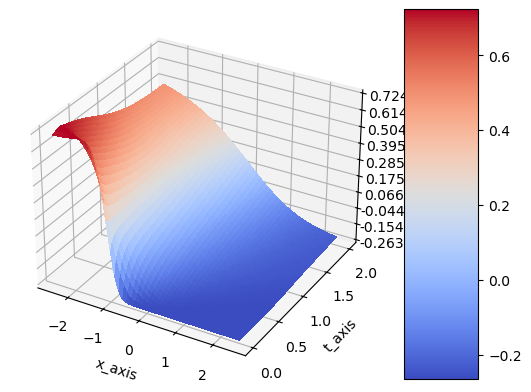

In [202]:
# Plotting the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Creating meshgrid for visualization
x_visual = np.arange(-2.5 , 2.5, 0.002)
t_visual = np.arange(0, 2, 0.002)
ms_x_visual, ms_t_visual = np.meshgrid(x_visual, t_visual)
## np.ravel returns a flattened and contiguous 1-D array containing the elements of the input.
## A copy is created only if necessary.
x_visual = np.ravel(ms_x_visual).reshape(-1, 1)
t_visual = np.ravel(ms_t_visual).reshape(-1, 1)

# Converting to PyTorch tensors
pt_x_visual = Variable(torch.from_numpy(x_visual).float(), requires_grad=True).to(device)
pt_t_visual = Variable(torch.from_numpy(t_visual).float(), requires_grad=True).to(device)

# Obtaining network predictions
## In the function net(pt_x_visualization, pt_t_visualization), the training process updates the parameters represented by theta.
pt_u_visual = net(pt_x_visual, pt_t_visual)
u_visual = pt_u_visual.data.cpu().numpy()
ms_u_visual = u_visual.reshape(ms_x_visual.shape)

# Plotting the surface
surf = ax.plot_surface(ms_x_visual, ms_t_visual, ms_u_visual, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0003f'))
ax.set_xlabel("x_axis")
ax.set_ylabel("t_axis")


# Adding colorbar for reference
fig.colorbar(surf, shrink=1, aspect=5)

# Displaying the plot
plt.show()

### 3.6.1 Fitting model with training with iteration 50000


In [203]:
# Setting the number of iterations
num_epochs = 50000
#prev_val_loss = 9999999.0 

# Iterating through epochs
for epoch in range(num_epochs):
    # Resetting gradients to zero
    optimizer.zero_grad()

    # Loss calculation based on boundary conditions
    input_x_bc = Variable(x_bc.float(), requires_grad=False).to(device)
    #input_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    input_t_bc = Variable(t_bc.float(), requires_grad=False).to(device)
    #input_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    
    
    target_u_bc = Variable(u_bc.float(), requires_grad=False).to(device)
    #target_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    target_u_initial1 = Variable(u_initial1.float(), requires_grad=False).to(device)
    target_u_initial2 = Variable(u_initial2.float(), requires_grad=False).to(device)

    # Getting network output for boundary condition and initial conditions
    output_bc = net(input_x_bc, input_t_bc)
    output_initial1 = net(input_t_bc, target_u_initial1)
    output_initial2 = net(input_t_bc, target_u_initial2)
    
    mse_u = mse_cost_function(output_bc, target_u_bc)
    mse_initial1 = mse_cost_function(u_initial1, target_u_initial1)
    mse_initial2 = mse_cost_function(u_initial2, target_u_initial2)
    # Loss calculation based on partial differential equation (PDE) 
    collocation_x = np.random.uniform(low= -2.0, high=2.0, size=(500, 1)) 
    collocation_t = np.random.uniform(low=0.0, high=1.0, size=(500, 1))
    all_zeros_target = np.zeros((500, 1))
    
    input_x_collocation = Variable(torch.from_numpy(collocation_x).float(), requires_grad=True).to(device)
    input_t_collocation = Variable(torch.from_numpy(collocation_t).float(), requires_grad=True).to(device)
    target_all_zeros = Variable(torch.from_numpy(all_zeros_target).float(), requires_grad=False).to(device)
    
    # Getting network output for PDE
    output_f = pde_loss(input_x_collocation, input_t_collocation, net)
    mse_f = mse_cost_function(output_f, target_all_zeros)
    
    # Combining the loss functions
    total_loss = mse_u + mse_f + mse_initial1 + mse_initial2
    
    # Backward propagation for computing gradients
    total_loss.backward()
    
    # Optimizer step to update parameters
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch, "Training Loss:", total_loss.data)

0 Training Loss: tensor(0.3550)
1 Training Loss: tensor(0.3537)
2 Training Loss: tensor(0.3516)
3 Training Loss: tensor(0.3548)
4 Training Loss: tensor(0.3550)
5 Training Loss: tensor(0.3535)
6 Training Loss: tensor(0.3516)
7 Training Loss: tensor(0.3562)
8 Training Loss: tensor(0.3531)
9 Training Loss: tensor(0.3503)
10 Training Loss: tensor(0.3516)
11 Training Loss: tensor(0.3567)
12 Training Loss: tensor(0.3530)
13 Training Loss: tensor(0.3510)
14 Training Loss: tensor(0.3518)
15 Training Loss: tensor(0.3501)
16 Training Loss: tensor(0.3506)
17 Training Loss: tensor(0.3589)
18 Training Loss: tensor(0.3523)
19 Training Loss: tensor(0.3507)
20 Training Loss: tensor(0.3523)
21 Training Loss: tensor(0.3550)
22 Training Loss: tensor(0.3502)
23 Training Loss: tensor(0.3514)
24 Training Loss: tensor(0.3518)
25 Training Loss: tensor(0.3537)
26 Training Loss: tensor(0.3505)
27 Training Loss: tensor(0.3552)
28 Training Loss: tensor(0.3518)
29 Training Loss: tensor(0.3493)
30 Training Loss: te

256 Training Loss: tensor(0.3505)
257 Training Loss: tensor(0.3510)
258 Training Loss: tensor(0.3537)
259 Training Loss: tensor(0.3497)
260 Training Loss: tensor(0.3501)
261 Training Loss: tensor(0.3533)
262 Training Loss: tensor(0.3598)
263 Training Loss: tensor(0.3506)
264 Training Loss: tensor(0.3552)
265 Training Loss: tensor(0.3494)
266 Training Loss: tensor(0.3531)
267 Training Loss: tensor(0.3538)
268 Training Loss: tensor(0.3544)
269 Training Loss: tensor(0.3497)
270 Training Loss: tensor(0.3505)
271 Training Loss: tensor(0.3534)
272 Training Loss: tensor(0.3577)
273 Training Loss: tensor(0.3506)
274 Training Loss: tensor(0.3499)
275 Training Loss: tensor(0.3531)
276 Training Loss: tensor(0.3495)
277 Training Loss: tensor(0.3530)
278 Training Loss: tensor(0.3497)
279 Training Loss: tensor(0.3498)
280 Training Loss: tensor(0.3556)
281 Training Loss: tensor(0.3492)
282 Training Loss: tensor(0.3529)
283 Training Loss: tensor(0.3545)
284 Training Loss: tensor(0.3504)
285 Training L

500 Training Loss: tensor(0.3494)
501 Training Loss: tensor(0.3527)
502 Training Loss: tensor(0.3500)
503 Training Loss: tensor(0.3518)
504 Training Loss: tensor(0.3513)
505 Training Loss: tensor(0.3551)
506 Training Loss: tensor(0.3491)
507 Training Loss: tensor(0.3516)
508 Training Loss: tensor(0.3535)
509 Training Loss: tensor(0.3490)
510 Training Loss: tensor(0.3499)
511 Training Loss: tensor(0.3514)
512 Training Loss: tensor(0.3506)
513 Training Loss: tensor(0.3527)
514 Training Loss: tensor(0.3498)
515 Training Loss: tensor(0.3533)
516 Training Loss: tensor(0.3516)
517 Training Loss: tensor(0.3504)
518 Training Loss: tensor(0.3516)
519 Training Loss: tensor(0.3636)
520 Training Loss: tensor(0.3497)
521 Training Loss: tensor(0.3503)
522 Training Loss: tensor(0.3513)
523 Training Loss: tensor(0.3491)
524 Training Loss: tensor(0.3493)
525 Training Loss: tensor(0.3569)
526 Training Loss: tensor(0.3574)
527 Training Loss: tensor(0.3514)
528 Training Loss: tensor(0.3509)
529 Training L

748 Training Loss: tensor(0.3535)
749 Training Loss: tensor(0.3501)
750 Training Loss: tensor(0.3500)
751 Training Loss: tensor(0.3570)
752 Training Loss: tensor(0.3527)
753 Training Loss: tensor(0.3522)
754 Training Loss: tensor(0.3554)
755 Training Loss: tensor(0.3511)
756 Training Loss: tensor(0.3545)
757 Training Loss: tensor(0.3505)
758 Training Loss: tensor(0.3535)
759 Training Loss: tensor(0.3557)
760 Training Loss: tensor(0.3515)
761 Training Loss: tensor(0.3522)
762 Training Loss: tensor(0.3536)
763 Training Loss: tensor(0.3534)
764 Training Loss: tensor(0.3508)
765 Training Loss: tensor(0.3515)
766 Training Loss: tensor(0.3501)
767 Training Loss: tensor(0.3523)
768 Training Loss: tensor(0.3508)
769 Training Loss: tensor(0.3504)
770 Training Loss: tensor(0.3515)
771 Training Loss: tensor(0.3533)
772 Training Loss: tensor(0.3507)
773 Training Loss: tensor(0.3521)
774 Training Loss: tensor(0.3542)
775 Training Loss: tensor(0.3511)
776 Training Loss: tensor(0.3500)
777 Training L

1010 Training Loss: tensor(0.3535)
1011 Training Loss: tensor(0.3517)
1012 Training Loss: tensor(0.3488)
1013 Training Loss: tensor(0.3532)
1014 Training Loss: tensor(0.3494)
1015 Training Loss: tensor(0.3557)
1016 Training Loss: tensor(0.3491)
1017 Training Loss: tensor(0.3485)
1018 Training Loss: tensor(0.3498)
1019 Training Loss: tensor(0.3508)
1020 Training Loss: tensor(0.3493)
1021 Training Loss: tensor(0.3587)
1022 Training Loss: tensor(0.3492)
1023 Training Loss: tensor(0.3504)
1024 Training Loss: tensor(0.3504)
1025 Training Loss: tensor(0.3513)
1026 Training Loss: tensor(0.3511)
1027 Training Loss: tensor(0.3508)
1028 Training Loss: tensor(0.3513)
1029 Training Loss: tensor(0.3512)
1030 Training Loss: tensor(0.3486)
1031 Training Loss: tensor(0.3500)
1032 Training Loss: tensor(0.3525)
1033 Training Loss: tensor(0.3620)
1034 Training Loss: tensor(0.3517)
1035 Training Loss: tensor(0.3505)
1036 Training Loss: tensor(0.3512)
1037 Training Loss: tensor(0.3541)
1038 Training Loss: 

1258 Training Loss: tensor(0.3507)
1259 Training Loss: tensor(0.3510)
1260 Training Loss: tensor(0.3535)
1261 Training Loss: tensor(0.3510)
1262 Training Loss: tensor(0.3510)
1263 Training Loss: tensor(0.3494)
1264 Training Loss: tensor(0.3606)
1265 Training Loss: tensor(0.3523)
1266 Training Loss: tensor(0.3489)
1267 Training Loss: tensor(0.3503)
1268 Training Loss: tensor(0.3489)
1269 Training Loss: tensor(0.3489)
1270 Training Loss: tensor(0.3498)
1271 Training Loss: tensor(0.3497)
1272 Training Loss: tensor(0.3482)
1273 Training Loss: tensor(0.3538)
1274 Training Loss: tensor(0.3516)
1275 Training Loss: tensor(0.3492)
1276 Training Loss: tensor(0.3535)
1277 Training Loss: tensor(0.3493)
1278 Training Loss: tensor(0.3511)
1279 Training Loss: tensor(0.3490)
1280 Training Loss: tensor(0.3522)
1281 Training Loss: tensor(0.3610)
1282 Training Loss: tensor(0.3537)
1283 Training Loss: tensor(0.3491)
1284 Training Loss: tensor(0.3518)
1285 Training Loss: tensor(0.3492)
1286 Training Loss: 

1500 Training Loss: tensor(0.3516)
1501 Training Loss: tensor(0.3499)
1502 Training Loss: tensor(0.3517)
1503 Training Loss: tensor(0.3505)
1504 Training Loss: tensor(0.3506)
1505 Training Loss: tensor(0.3528)
1506 Training Loss: tensor(0.3551)
1507 Training Loss: tensor(0.3513)
1508 Training Loss: tensor(0.3495)
1509 Training Loss: tensor(0.3502)
1510 Training Loss: tensor(0.3531)
1511 Training Loss: tensor(0.3531)
1512 Training Loss: tensor(0.3521)
1513 Training Loss: tensor(0.3515)
1514 Training Loss: tensor(0.3502)
1515 Training Loss: tensor(0.3529)
1516 Training Loss: tensor(0.3508)
1517 Training Loss: tensor(0.3502)
1518 Training Loss: tensor(0.3512)
1519 Training Loss: tensor(0.3490)
1520 Training Loss: tensor(0.3512)
1521 Training Loss: tensor(0.3491)
1522 Training Loss: tensor(0.3556)
1523 Training Loss: tensor(0.3507)
1524 Training Loss: tensor(0.3522)
1525 Training Loss: tensor(0.3502)
1526 Training Loss: tensor(0.3487)
1527 Training Loss: tensor(0.3546)
1528 Training Loss: 

1746 Training Loss: tensor(0.3517)
1747 Training Loss: tensor(0.3508)
1748 Training Loss: tensor(0.3545)
1749 Training Loss: tensor(0.3502)
1750 Training Loss: tensor(0.3490)
1751 Training Loss: tensor(0.3511)
1752 Training Loss: tensor(0.3549)
1753 Training Loss: tensor(0.3527)
1754 Training Loss: tensor(0.3552)
1755 Training Loss: tensor(0.3501)
1756 Training Loss: tensor(0.3490)
1757 Training Loss: tensor(0.3528)
1758 Training Loss: tensor(0.3540)
1759 Training Loss: tensor(0.3507)
1760 Training Loss: tensor(0.3547)
1761 Training Loss: tensor(0.3512)
1762 Training Loss: tensor(0.3509)
1763 Training Loss: tensor(0.3489)
1764 Training Loss: tensor(0.3493)
1765 Training Loss: tensor(0.3498)
1766 Training Loss: tensor(0.3528)
1767 Training Loss: tensor(0.3516)
1768 Training Loss: tensor(0.3530)
1769 Training Loss: tensor(0.3523)
1770 Training Loss: tensor(0.3504)
1771 Training Loss: tensor(0.3495)
1772 Training Loss: tensor(0.3511)
1773 Training Loss: tensor(0.3508)
1774 Training Loss: 

1985 Training Loss: tensor(0.3498)
1986 Training Loss: tensor(0.3599)
1987 Training Loss: tensor(0.3526)
1988 Training Loss: tensor(0.3492)
1989 Training Loss: tensor(0.3501)
1990 Training Loss: tensor(0.3499)
1991 Training Loss: tensor(0.3487)
1992 Training Loss: tensor(0.3514)
1993 Training Loss: tensor(0.3578)
1994 Training Loss: tensor(0.3507)
1995 Training Loss: tensor(0.3525)
1996 Training Loss: tensor(0.3543)
1997 Training Loss: tensor(0.3482)
1998 Training Loss: tensor(0.3522)
1999 Training Loss: tensor(0.3535)
2000 Training Loss: tensor(0.3513)
2001 Training Loss: tensor(0.3492)
2002 Training Loss: tensor(0.3499)
2003 Training Loss: tensor(0.3538)
2004 Training Loss: tensor(0.3507)
2005 Training Loss: tensor(0.3514)
2006 Training Loss: tensor(0.3576)
2007 Training Loss: tensor(0.3505)
2008 Training Loss: tensor(0.3497)
2009 Training Loss: tensor(0.3532)
2010 Training Loss: tensor(0.3493)
2011 Training Loss: tensor(0.3529)
2012 Training Loss: tensor(0.3497)
2013 Training Loss: 

2234 Training Loss: tensor(0.3498)
2235 Training Loss: tensor(0.3517)
2236 Training Loss: tensor(0.3482)
2237 Training Loss: tensor(0.3503)
2238 Training Loss: tensor(0.3525)
2239 Training Loss: tensor(0.3563)
2240 Training Loss: tensor(0.3514)
2241 Training Loss: tensor(0.3525)
2242 Training Loss: tensor(0.3524)
2243 Training Loss: tensor(0.3511)
2244 Training Loss: tensor(0.3596)
2245 Training Loss: tensor(0.3504)
2246 Training Loss: tensor(0.3529)
2247 Training Loss: tensor(0.3508)
2248 Training Loss: tensor(0.3509)
2249 Training Loss: tensor(0.3520)
2250 Training Loss: tensor(0.3493)
2251 Training Loss: tensor(0.3591)
2252 Training Loss: tensor(0.3513)
2253 Training Loss: tensor(0.3518)
2254 Training Loss: tensor(0.3526)
2255 Training Loss: tensor(0.3531)
2256 Training Loss: tensor(0.3499)
2257 Training Loss: tensor(0.3528)
2258 Training Loss: tensor(0.3508)
2259 Training Loss: tensor(0.3533)
2260 Training Loss: tensor(0.3503)
2261 Training Loss: tensor(0.3496)
2262 Training Loss: 

2480 Training Loss: tensor(0.3493)
2481 Training Loss: tensor(0.3541)
2482 Training Loss: tensor(0.3534)
2483 Training Loss: tensor(0.3491)
2484 Training Loss: tensor(0.3488)
2485 Training Loss: tensor(0.3520)
2486 Training Loss: tensor(0.3490)
2487 Training Loss: tensor(0.3504)
2488 Training Loss: tensor(0.3484)
2489 Training Loss: tensor(0.3520)
2490 Training Loss: tensor(0.3534)
2491 Training Loss: tensor(0.3510)
2492 Training Loss: tensor(0.3547)
2493 Training Loss: tensor(0.3487)
2494 Training Loss: tensor(0.3480)
2495 Training Loss: tensor(0.3499)
2496 Training Loss: tensor(0.3526)
2497 Training Loss: tensor(0.3484)
2498 Training Loss: tensor(0.3518)
2499 Training Loss: tensor(0.3482)
2500 Training Loss: tensor(0.3479)
2501 Training Loss: tensor(0.3541)
2502 Training Loss: tensor(0.3495)
2503 Training Loss: tensor(0.3519)
2504 Training Loss: tensor(0.3561)
2505 Training Loss: tensor(0.3490)
2506 Training Loss: tensor(0.3535)
2507 Training Loss: tensor(0.3497)
2508 Training Loss: 

2727 Training Loss: tensor(0.3484)
2728 Training Loss: tensor(0.3508)
2729 Training Loss: tensor(0.3516)
2730 Training Loss: tensor(0.3540)
2731 Training Loss: tensor(0.3524)
2732 Training Loss: tensor(0.3509)
2733 Training Loss: tensor(0.3491)
2734 Training Loss: tensor(0.3502)
2735 Training Loss: tensor(0.3532)
2736 Training Loss: tensor(0.3502)
2737 Training Loss: tensor(0.3497)
2738 Training Loss: tensor(0.3505)
2739 Training Loss: tensor(0.3540)
2740 Training Loss: tensor(0.3498)
2741 Training Loss: tensor(0.3531)
2742 Training Loss: tensor(0.3496)
2743 Training Loss: tensor(0.3503)
2744 Training Loss: tensor(0.3516)
2745 Training Loss: tensor(0.3485)
2746 Training Loss: tensor(0.3492)
2747 Training Loss: tensor(0.3501)
2748 Training Loss: tensor(0.3500)
2749 Training Loss: tensor(0.3511)
2750 Training Loss: tensor(0.3491)
2751 Training Loss: tensor(0.3506)
2752 Training Loss: tensor(0.3509)
2753 Training Loss: tensor(0.3493)
2754 Training Loss: tensor(0.3483)
2755 Training Loss: 

2974 Training Loss: tensor(0.3512)
2975 Training Loss: tensor(0.3505)
2976 Training Loss: tensor(0.3489)
2977 Training Loss: tensor(0.3538)
2978 Training Loss: tensor(0.3484)
2979 Training Loss: tensor(0.3556)
2980 Training Loss: tensor(0.3487)
2981 Training Loss: tensor(0.3496)
2982 Training Loss: tensor(0.3556)
2983 Training Loss: tensor(0.3510)
2984 Training Loss: tensor(0.3514)
2985 Training Loss: tensor(0.3493)
2986 Training Loss: tensor(0.3550)
2987 Training Loss: tensor(0.3527)
2988 Training Loss: tensor(0.3488)
2989 Training Loss: tensor(0.3492)
2990 Training Loss: tensor(0.3506)
2991 Training Loss: tensor(0.3505)
2992 Training Loss: tensor(0.3509)
2993 Training Loss: tensor(0.3505)
2994 Training Loss: tensor(0.3503)
2995 Training Loss: tensor(0.3486)
2996 Training Loss: tensor(0.3492)
2997 Training Loss: tensor(0.3591)
2998 Training Loss: tensor(0.3483)
2999 Training Loss: tensor(0.3494)
3000 Training Loss: tensor(0.3500)
3001 Training Loss: tensor(0.3487)
3002 Training Loss: 

3227 Training Loss: tensor(0.3577)
3228 Training Loss: tensor(0.3478)
3229 Training Loss: tensor(0.3543)
3230 Training Loss: tensor(0.3492)
3231 Training Loss: tensor(0.3504)
3232 Training Loss: tensor(0.3486)
3233 Training Loss: tensor(0.3483)
3234 Training Loss: tensor(0.3530)
3235 Training Loss: tensor(0.3498)
3236 Training Loss: tensor(0.3489)
3237 Training Loss: tensor(0.3496)
3238 Training Loss: tensor(0.3491)
3239 Training Loss: tensor(0.3551)
3240 Training Loss: tensor(0.3496)
3241 Training Loss: tensor(0.3488)
3242 Training Loss: tensor(0.3495)
3243 Training Loss: tensor(0.3490)
3244 Training Loss: tensor(0.3542)
3245 Training Loss: tensor(0.3511)
3246 Training Loss: tensor(0.3492)
3247 Training Loss: tensor(0.3492)
3248 Training Loss: tensor(0.3490)
3249 Training Loss: tensor(0.3480)
3250 Training Loss: tensor(0.3492)
3251 Training Loss: tensor(0.3515)
3252 Training Loss: tensor(0.3471)
3253 Training Loss: tensor(0.3531)
3254 Training Loss: tensor(0.3481)
3255 Training Loss: 

3491 Training Loss: tensor(0.3527)
3492 Training Loss: tensor(0.3480)
3493 Training Loss: tensor(0.3470)
3494 Training Loss: tensor(0.3526)
3495 Training Loss: tensor(0.3473)
3496 Training Loss: tensor(0.3519)
3497 Training Loss: tensor(0.3564)
3498 Training Loss: tensor(0.3500)
3499 Training Loss: tensor(0.3477)
3500 Training Loss: tensor(0.3497)
3501 Training Loss: tensor(0.3488)
3502 Training Loss: tensor(0.3587)
3503 Training Loss: tensor(0.3487)
3504 Training Loss: tensor(0.3505)
3505 Training Loss: tensor(0.3502)
3506 Training Loss: tensor(0.3484)
3507 Training Loss: tensor(0.3515)
3508 Training Loss: tensor(0.3483)
3509 Training Loss: tensor(0.3509)
3510 Training Loss: tensor(0.3516)
3511 Training Loss: tensor(0.3495)
3512 Training Loss: tensor(0.3528)
3513 Training Loss: tensor(0.3509)
3514 Training Loss: tensor(0.3491)
3515 Training Loss: tensor(0.3501)
3516 Training Loss: tensor(0.3530)
3517 Training Loss: tensor(0.3543)
3518 Training Loss: tensor(0.3508)
3519 Training Loss: 

3742 Training Loss: tensor(0.3492)
3743 Training Loss: tensor(0.3539)
3744 Training Loss: tensor(0.3492)
3745 Training Loss: tensor(0.3489)
3746 Training Loss: tensor(0.3508)
3747 Training Loss: tensor(0.3491)
3748 Training Loss: tensor(0.3513)
3749 Training Loss: tensor(0.3507)
3750 Training Loss: tensor(0.3489)
3751 Training Loss: tensor(0.3497)
3752 Training Loss: tensor(0.3497)
3753 Training Loss: tensor(0.3526)
3754 Training Loss: tensor(0.3506)
3755 Training Loss: tensor(0.3530)
3756 Training Loss: tensor(0.3493)
3757 Training Loss: tensor(0.3492)
3758 Training Loss: tensor(0.3496)
3759 Training Loss: tensor(0.3501)
3760 Training Loss: tensor(0.3499)
3761 Training Loss: tensor(0.3502)
3762 Training Loss: tensor(0.3492)
3763 Training Loss: tensor(0.3531)
3764 Training Loss: tensor(0.3489)
3765 Training Loss: tensor(0.3479)
3766 Training Loss: tensor(0.3496)
3767 Training Loss: tensor(0.3518)
3768 Training Loss: tensor(0.3503)
3769 Training Loss: tensor(0.3502)
3770 Training Loss: 

3999 Training Loss: tensor(0.3530)
4000 Training Loss: tensor(0.3503)
4001 Training Loss: tensor(0.3505)
4002 Training Loss: tensor(0.3538)
4003 Training Loss: tensor(0.3494)
4004 Training Loss: tensor(0.3482)
4005 Training Loss: tensor(0.3480)
4006 Training Loss: tensor(0.3477)
4007 Training Loss: tensor(0.3478)
4008 Training Loss: tensor(0.3477)
4009 Training Loss: tensor(0.3490)
4010 Training Loss: tensor(0.3486)
4011 Training Loss: tensor(0.3502)
4012 Training Loss: tensor(0.3491)
4013 Training Loss: tensor(0.3502)
4014 Training Loss: tensor(0.3476)
4015 Training Loss: tensor(0.3488)
4016 Training Loss: tensor(0.3497)
4017 Training Loss: tensor(0.3480)
4018 Training Loss: tensor(0.3479)
4019 Training Loss: tensor(0.3518)
4020 Training Loss: tensor(0.3482)
4021 Training Loss: tensor(0.3468)
4022 Training Loss: tensor(0.3474)
4023 Training Loss: tensor(0.3512)
4024 Training Loss: tensor(0.3483)
4025 Training Loss: tensor(0.3601)
4026 Training Loss: tensor(0.3516)
4027 Training Loss: 

4258 Training Loss: tensor(0.3542)
4259 Training Loss: tensor(0.3502)
4260 Training Loss: tensor(0.3477)
4261 Training Loss: tensor(0.3531)
4262 Training Loss: tensor(0.3482)
4263 Training Loss: tensor(0.3495)
4264 Training Loss: tensor(0.3517)
4265 Training Loss: tensor(0.3478)
4266 Training Loss: tensor(0.3508)
4267 Training Loss: tensor(0.3487)
4268 Training Loss: tensor(0.3479)
4269 Training Loss: tensor(0.3500)
4270 Training Loss: tensor(0.3531)
4271 Training Loss: tensor(0.3515)
4272 Training Loss: tensor(0.3503)
4273 Training Loss: tensor(0.3521)
4274 Training Loss: tensor(0.3475)
4275 Training Loss: tensor(0.3523)
4276 Training Loss: tensor(0.3484)
4277 Training Loss: tensor(0.3483)
4278 Training Loss: tensor(0.3519)
4279 Training Loss: tensor(0.3517)
4280 Training Loss: tensor(0.3525)
4281 Training Loss: tensor(0.3508)
4282 Training Loss: tensor(0.3480)
4283 Training Loss: tensor(0.3592)
4284 Training Loss: tensor(0.3488)
4285 Training Loss: tensor(0.3491)
4286 Training Loss: 

4506 Training Loss: tensor(0.3488)
4507 Training Loss: tensor(0.3477)
4508 Training Loss: tensor(0.3486)
4509 Training Loss: tensor(0.3498)
4510 Training Loss: tensor(0.3515)
4511 Training Loss: tensor(0.3488)
4512 Training Loss: tensor(0.3483)
4513 Training Loss: tensor(0.3484)
4514 Training Loss: tensor(0.3481)
4515 Training Loss: tensor(0.3492)
4516 Training Loss: tensor(0.3500)
4517 Training Loss: tensor(0.3482)
4518 Training Loss: tensor(0.3545)
4519 Training Loss: tensor(0.3523)
4520 Training Loss: tensor(0.3490)
4521 Training Loss: tensor(0.3475)
4522 Training Loss: tensor(0.3485)
4523 Training Loss: tensor(0.3502)
4524 Training Loss: tensor(0.3481)
4525 Training Loss: tensor(0.3541)
4526 Training Loss: tensor(0.3496)
4527 Training Loss: tensor(0.3481)
4528 Training Loss: tensor(0.3542)
4529 Training Loss: tensor(0.3537)
4530 Training Loss: tensor(0.3494)
4531 Training Loss: tensor(0.3499)
4532 Training Loss: tensor(0.3473)
4533 Training Loss: tensor(0.3472)
4534 Training Loss: 

4763 Training Loss: tensor(0.3538)
4764 Training Loss: tensor(0.3498)
4765 Training Loss: tensor(0.3496)
4766 Training Loss: tensor(0.3516)
4767 Training Loss: tensor(0.3528)
4768 Training Loss: tensor(0.3504)
4769 Training Loss: tensor(0.3475)
4770 Training Loss: tensor(0.3488)
4771 Training Loss: tensor(0.3502)
4772 Training Loss: tensor(0.3477)
4773 Training Loss: tensor(0.3492)
4774 Training Loss: tensor(0.3480)
4775 Training Loss: tensor(0.3473)
4776 Training Loss: tensor(0.3515)
4777 Training Loss: tensor(0.3500)
4778 Training Loss: tensor(0.3536)
4779 Training Loss: tensor(0.3520)
4780 Training Loss: tensor(0.3488)
4781 Training Loss: tensor(0.3484)
4782 Training Loss: tensor(0.3496)
4783 Training Loss: tensor(0.3516)
4784 Training Loss: tensor(0.3470)
4785 Training Loss: tensor(0.3496)
4786 Training Loss: tensor(0.3482)
4787 Training Loss: tensor(0.3476)
4788 Training Loss: tensor(0.3547)
4789 Training Loss: tensor(0.3470)
4790 Training Loss: tensor(0.3484)
4791 Training Loss: 

5009 Training Loss: tensor(0.3490)
5010 Training Loss: tensor(0.3484)
5011 Training Loss: tensor(0.3480)
5012 Training Loss: tensor(0.3499)
5013 Training Loss: tensor(0.3489)
5014 Training Loss: tensor(0.3476)
5015 Training Loss: tensor(0.3515)
5016 Training Loss: tensor(0.3502)
5017 Training Loss: tensor(0.3520)
5018 Training Loss: tensor(0.3481)
5019 Training Loss: tensor(0.3480)
5020 Training Loss: tensor(0.3475)
5021 Training Loss: tensor(0.3487)
5022 Training Loss: tensor(0.3513)
5023 Training Loss: tensor(0.3471)
5024 Training Loss: tensor(0.3492)
5025 Training Loss: tensor(0.3478)
5026 Training Loss: tensor(0.3475)
5027 Training Loss: tensor(0.3475)
5028 Training Loss: tensor(0.3470)
5029 Training Loss: tensor(0.3500)
5030 Training Loss: tensor(0.3529)
5031 Training Loss: tensor(0.3473)
5032 Training Loss: tensor(0.3538)
5033 Training Loss: tensor(0.3473)
5034 Training Loss: tensor(0.3493)
5035 Training Loss: tensor(0.3495)
5036 Training Loss: tensor(0.3500)
5037 Training Loss: 

5258 Training Loss: tensor(0.3492)
5259 Training Loss: tensor(0.3515)
5260 Training Loss: tensor(0.3489)
5261 Training Loss: tensor(0.3483)
5262 Training Loss: tensor(0.3529)
5263 Training Loss: tensor(0.3495)
5264 Training Loss: tensor(0.3478)
5265 Training Loss: tensor(0.3510)
5266 Training Loss: tensor(0.3473)
5267 Training Loss: tensor(0.3484)
5268 Training Loss: tensor(0.3492)
5269 Training Loss: tensor(0.3485)
5270 Training Loss: tensor(0.3578)
5271 Training Loss: tensor(0.3509)
5272 Training Loss: tensor(0.3482)
5273 Training Loss: tensor(0.3476)
5274 Training Loss: tensor(0.3506)
5275 Training Loss: tensor(0.3492)
5276 Training Loss: tensor(0.3520)
5277 Training Loss: tensor(0.3539)
5278 Training Loss: tensor(0.3486)
5279 Training Loss: tensor(0.3506)
5280 Training Loss: tensor(0.3488)
5281 Training Loss: tensor(0.3496)
5282 Training Loss: tensor(0.3481)
5283 Training Loss: tensor(0.3477)
5284 Training Loss: tensor(0.3491)
5285 Training Loss: tensor(0.3482)
5286 Training Loss: 

5499 Training Loss: tensor(0.3472)
5500 Training Loss: tensor(0.3516)
5501 Training Loss: tensor(0.3515)
5502 Training Loss: tensor(0.3501)
5503 Training Loss: tensor(0.3497)
5504 Training Loss: tensor(0.3487)
5505 Training Loss: tensor(0.3495)
5506 Training Loss: tensor(0.3503)
5507 Training Loss: tensor(0.3494)
5508 Training Loss: tensor(0.3485)
5509 Training Loss: tensor(0.3495)
5510 Training Loss: tensor(0.3514)
5511 Training Loss: tensor(0.3526)
5512 Training Loss: tensor(0.3517)
5513 Training Loss: tensor(0.3474)
5514 Training Loss: tensor(0.3503)
5515 Training Loss: tensor(0.3484)
5516 Training Loss: tensor(0.3532)
5517 Training Loss: tensor(0.3556)
5518 Training Loss: tensor(0.3482)
5519 Training Loss: tensor(0.3506)
5520 Training Loss: tensor(0.3484)
5521 Training Loss: tensor(0.3516)
5522 Training Loss: tensor(0.3484)
5523 Training Loss: tensor(0.3488)
5524 Training Loss: tensor(0.3478)
5525 Training Loss: tensor(0.3476)
5526 Training Loss: tensor(0.3503)
5527 Training Loss: 

5750 Training Loss: tensor(0.3547)
5751 Training Loss: tensor(0.3473)
5752 Training Loss: tensor(0.3492)
5753 Training Loss: tensor(0.3475)
5754 Training Loss: tensor(0.3475)
5755 Training Loss: tensor(0.3495)
5756 Training Loss: tensor(0.3477)
5757 Training Loss: tensor(0.3469)
5758 Training Loss: tensor(0.3472)
5759 Training Loss: tensor(0.3476)
5760 Training Loss: tensor(0.3471)
5761 Training Loss: tensor(0.3472)
5762 Training Loss: tensor(0.3521)
5763 Training Loss: tensor(0.3497)
5764 Training Loss: tensor(0.3469)
5765 Training Loss: tensor(0.3557)
5766 Training Loss: tensor(0.3550)
5767 Training Loss: tensor(0.3564)
5768 Training Loss: tensor(0.3522)
5769 Training Loss: tensor(0.3500)
5770 Training Loss: tensor(0.3518)
5771 Training Loss: tensor(0.3479)
5772 Training Loss: tensor(0.3478)
5773 Training Loss: tensor(0.3513)
5774 Training Loss: tensor(0.3480)
5775 Training Loss: tensor(0.3492)
5776 Training Loss: tensor(0.3506)
5777 Training Loss: tensor(0.3493)
5778 Training Loss: 

5996 Training Loss: tensor(0.3480)
5997 Training Loss: tensor(0.3472)
5998 Training Loss: tensor(0.3472)
5999 Training Loss: tensor(0.3499)
6000 Training Loss: tensor(0.3469)
6001 Training Loss: tensor(0.3475)
6002 Training Loss: tensor(0.3468)
6003 Training Loss: tensor(0.3473)
6004 Training Loss: tensor(0.3473)
6005 Training Loss: tensor(0.3515)
6006 Training Loss: tensor(0.3464)
6007 Training Loss: tensor(0.3490)
6008 Training Loss: tensor(0.3502)
6009 Training Loss: tensor(0.3554)
6010 Training Loss: tensor(0.3512)
6011 Training Loss: tensor(0.3457)
6012 Training Loss: tensor(0.3499)
6013 Training Loss: tensor(0.3485)
6014 Training Loss: tensor(0.3476)
6015 Training Loss: tensor(0.3498)
6016 Training Loss: tensor(0.3490)
6017 Training Loss: tensor(0.3473)
6018 Training Loss: tensor(0.3493)
6019 Training Loss: tensor(0.3468)
6020 Training Loss: tensor(0.3488)
6021 Training Loss: tensor(0.3482)
6022 Training Loss: tensor(0.3464)
6023 Training Loss: tensor(0.3468)
6024 Training Loss: 

6250 Training Loss: tensor(0.3497)
6251 Training Loss: tensor(0.3474)
6252 Training Loss: tensor(0.3525)
6253 Training Loss: tensor(0.3481)
6254 Training Loss: tensor(0.3481)
6255 Training Loss: tensor(0.3488)
6256 Training Loss: tensor(0.3511)
6257 Training Loss: tensor(0.3468)
6258 Training Loss: tensor(0.3476)
6259 Training Loss: tensor(0.3474)
6260 Training Loss: tensor(0.3491)
6261 Training Loss: tensor(0.3473)
6262 Training Loss: tensor(0.3472)
6263 Training Loss: tensor(0.3468)
6264 Training Loss: tensor(0.3500)
6265 Training Loss: tensor(0.3551)
6266 Training Loss: tensor(0.3464)
6267 Training Loss: tensor(0.3471)
6268 Training Loss: tensor(0.3496)
6269 Training Loss: tensor(0.3528)
6270 Training Loss: tensor(0.3504)
6271 Training Loss: tensor(0.3492)
6272 Training Loss: tensor(0.3523)
6273 Training Loss: tensor(0.3488)
6274 Training Loss: tensor(0.3487)
6275 Training Loss: tensor(0.3523)
6276 Training Loss: tensor(0.3487)
6277 Training Loss: tensor(0.3522)
6278 Training Loss: 

6500 Training Loss: tensor(0.3470)
6501 Training Loss: tensor(0.3482)
6502 Training Loss: tensor(0.3487)
6503 Training Loss: tensor(0.3481)
6504 Training Loss: tensor(0.3471)
6505 Training Loss: tensor(0.3592)
6506 Training Loss: tensor(0.3483)
6507 Training Loss: tensor(0.3479)
6508 Training Loss: tensor(0.3503)
6509 Training Loss: tensor(0.3529)
6510 Training Loss: tensor(0.3509)
6511 Training Loss: tensor(0.3477)
6512 Training Loss: tensor(0.3507)
6513 Training Loss: tensor(0.3487)
6514 Training Loss: tensor(0.3495)
6515 Training Loss: tensor(0.3476)
6516 Training Loss: tensor(0.3506)
6517 Training Loss: tensor(0.3472)
6518 Training Loss: tensor(0.3474)
6519 Training Loss: tensor(0.3496)
6520 Training Loss: tensor(0.3553)
6521 Training Loss: tensor(0.3480)
6522 Training Loss: tensor(0.3474)
6523 Training Loss: tensor(0.3474)
6524 Training Loss: tensor(0.3483)
6525 Training Loss: tensor(0.3471)
6526 Training Loss: tensor(0.3472)
6527 Training Loss: tensor(0.3467)
6528 Training Loss: 

6740 Training Loss: tensor(0.3488)
6741 Training Loss: tensor(0.3479)
6742 Training Loss: tensor(0.3493)
6743 Training Loss: tensor(0.3477)
6744 Training Loss: tensor(0.3476)
6745 Training Loss: tensor(0.3479)
6746 Training Loss: tensor(0.3491)
6747 Training Loss: tensor(0.3482)
6748 Training Loss: tensor(0.3504)
6749 Training Loss: tensor(0.3522)
6750 Training Loss: tensor(0.3500)
6751 Training Loss: tensor(0.3531)
6752 Training Loss: tensor(0.3481)
6753 Training Loss: tensor(0.3487)
6754 Training Loss: tensor(0.3563)
6755 Training Loss: tensor(0.3479)
6756 Training Loss: tensor(0.3512)
6757 Training Loss: tensor(0.3486)
6758 Training Loss: tensor(0.3485)
6759 Training Loss: tensor(0.3490)
6760 Training Loss: tensor(0.3489)
6761 Training Loss: tensor(0.3469)
6762 Training Loss: tensor(0.3535)
6763 Training Loss: tensor(0.3465)
6764 Training Loss: tensor(0.3529)
6765 Training Loss: tensor(0.3468)
6766 Training Loss: tensor(0.3468)
6767 Training Loss: tensor(0.3469)
6768 Training Loss: 

6985 Training Loss: tensor(0.3505)
6986 Training Loss: tensor(0.3467)
6987 Training Loss: tensor(0.3520)
6988 Training Loss: tensor(0.3493)
6989 Training Loss: tensor(0.3479)
6990 Training Loss: tensor(0.3500)
6991 Training Loss: tensor(0.3499)
6992 Training Loss: tensor(0.3502)
6993 Training Loss: tensor(0.3474)
6994 Training Loss: tensor(0.3495)
6995 Training Loss: tensor(0.3527)
6996 Training Loss: tensor(0.3471)
6997 Training Loss: tensor(0.3494)
6998 Training Loss: tensor(0.3470)
6999 Training Loss: tensor(0.3499)
7000 Training Loss: tensor(0.3489)
7001 Training Loss: tensor(0.3514)
7002 Training Loss: tensor(0.3501)
7003 Training Loss: tensor(0.3481)
7004 Training Loss: tensor(0.3488)
7005 Training Loss: tensor(0.3470)
7006 Training Loss: tensor(0.3529)
7007 Training Loss: tensor(0.3481)
7008 Training Loss: tensor(0.3480)
7009 Training Loss: tensor(0.3469)
7010 Training Loss: tensor(0.3521)
7011 Training Loss: tensor(0.3490)
7012 Training Loss: tensor(0.3490)
7013 Training Loss: 

7246 Training Loss: tensor(0.3464)
7247 Training Loss: tensor(0.3506)
7248 Training Loss: tensor(0.3497)
7249 Training Loss: tensor(0.3487)
7250 Training Loss: tensor(0.3477)
7251 Training Loss: tensor(0.3476)
7252 Training Loss: tensor(0.3488)
7253 Training Loss: tensor(0.3481)
7254 Training Loss: tensor(0.3467)
7255 Training Loss: tensor(0.3509)
7256 Training Loss: tensor(0.3482)
7257 Training Loss: tensor(0.3468)
7258 Training Loss: tensor(0.3471)
7259 Training Loss: tensor(0.3507)
7260 Training Loss: tensor(0.3500)
7261 Training Loss: tensor(0.3468)
7262 Training Loss: tensor(0.3482)
7263 Training Loss: tensor(0.3498)
7264 Training Loss: tensor(0.3484)
7265 Training Loss: tensor(0.3471)
7266 Training Loss: tensor(0.3534)
7267 Training Loss: tensor(0.3471)
7268 Training Loss: tensor(0.3496)
7269 Training Loss: tensor(0.3473)
7270 Training Loss: tensor(0.3500)
7271 Training Loss: tensor(0.3461)
7272 Training Loss: tensor(0.3472)
7273 Training Loss: tensor(0.3484)
7274 Training Loss: 

7492 Training Loss: tensor(0.3473)
7493 Training Loss: tensor(0.3497)
7494 Training Loss: tensor(0.3472)
7495 Training Loss: tensor(0.3482)
7496 Training Loss: tensor(0.3480)
7497 Training Loss: tensor(0.3472)
7498 Training Loss: tensor(0.3503)
7499 Training Loss: tensor(0.3510)
7500 Training Loss: tensor(0.3476)
7501 Training Loss: tensor(0.3476)
7502 Training Loss: tensor(0.3472)
7503 Training Loss: tensor(0.3506)
7504 Training Loss: tensor(0.3496)
7505 Training Loss: tensor(0.3484)
7506 Training Loss: tensor(0.3473)
7507 Training Loss: tensor(0.3474)
7508 Training Loss: tensor(0.3525)
7509 Training Loss: tensor(0.3474)
7510 Training Loss: tensor(0.3530)
7511 Training Loss: tensor(0.3463)
7512 Training Loss: tensor(0.3469)
7513 Training Loss: tensor(0.3464)
7514 Training Loss: tensor(0.3470)
7515 Training Loss: tensor(0.3523)
7516 Training Loss: tensor(0.3479)
7517 Training Loss: tensor(0.3576)
7518 Training Loss: tensor(0.3496)
7519 Training Loss: tensor(0.3489)
7520 Training Loss: 

7742 Training Loss: tensor(0.3462)
7743 Training Loss: tensor(0.3461)
7744 Training Loss: tensor(0.3467)
7745 Training Loss: tensor(0.3486)
7746 Training Loss: tensor(0.3485)
7747 Training Loss: tensor(0.3485)
7748 Training Loss: tensor(0.3466)
7749 Training Loss: tensor(0.3473)
7750 Training Loss: tensor(0.3464)
7751 Training Loss: tensor(0.3491)
7752 Training Loss: tensor(0.3495)
7753 Training Loss: tensor(0.3511)
7754 Training Loss: tensor(0.3457)
7755 Training Loss: tensor(0.3469)
7756 Training Loss: tensor(0.3520)
7757 Training Loss: tensor(0.3511)
7758 Training Loss: tensor(0.3458)
7759 Training Loss: tensor(0.3465)
7760 Training Loss: tensor(0.3468)
7761 Training Loss: tensor(0.3461)
7762 Training Loss: tensor(0.3470)
7763 Training Loss: tensor(0.3477)
7764 Training Loss: tensor(0.3461)
7765 Training Loss: tensor(0.3475)
7766 Training Loss: tensor(0.3484)
7767 Training Loss: tensor(0.3473)
7768 Training Loss: tensor(0.3464)
7769 Training Loss: tensor(0.3455)
7770 Training Loss: 

7989 Training Loss: tensor(0.3464)
7990 Training Loss: tensor(0.3470)
7991 Training Loss: tensor(0.3480)
7992 Training Loss: tensor(0.3470)
7993 Training Loss: tensor(0.3467)
7994 Training Loss: tensor(0.3501)
7995 Training Loss: tensor(0.3479)
7996 Training Loss: tensor(0.3545)
7997 Training Loss: tensor(0.3478)
7998 Training Loss: tensor(0.3468)
7999 Training Loss: tensor(0.3505)
8000 Training Loss: tensor(0.3483)
8001 Training Loss: tensor(0.3461)
8002 Training Loss: tensor(0.3470)
8003 Training Loss: tensor(0.3484)
8004 Training Loss: tensor(0.3476)
8005 Training Loss: tensor(0.3475)
8006 Training Loss: tensor(0.3482)
8007 Training Loss: tensor(0.3498)
8008 Training Loss: tensor(0.3534)
8009 Training Loss: tensor(0.3495)
8010 Training Loss: tensor(0.3511)
8011 Training Loss: tensor(0.3498)
8012 Training Loss: tensor(0.3472)
8013 Training Loss: tensor(0.3533)
8014 Training Loss: tensor(0.3511)
8015 Training Loss: tensor(0.3478)
8016 Training Loss: tensor(0.3476)
8017 Training Loss: 

8234 Training Loss: tensor(0.3492)
8235 Training Loss: tensor(0.3479)
8236 Training Loss: tensor(0.3503)
8237 Training Loss: tensor(0.3529)
8238 Training Loss: tensor(0.3466)
8239 Training Loss: tensor(0.3489)
8240 Training Loss: tensor(0.3464)
8241 Training Loss: tensor(0.3472)
8242 Training Loss: tensor(0.3528)
8243 Training Loss: tensor(0.3492)
8244 Training Loss: tensor(0.3466)
8245 Training Loss: tensor(0.3511)
8246 Training Loss: tensor(0.3467)
8247 Training Loss: tensor(0.3480)
8248 Training Loss: tensor(0.3502)
8249 Training Loss: tensor(0.3464)
8250 Training Loss: tensor(0.3467)
8251 Training Loss: tensor(0.3469)
8252 Training Loss: tensor(0.3498)
8253 Training Loss: tensor(0.3464)
8254 Training Loss: tensor(0.3477)
8255 Training Loss: tensor(0.3483)
8256 Training Loss: tensor(0.3468)
8257 Training Loss: tensor(0.3465)
8258 Training Loss: tensor(0.3479)
8259 Training Loss: tensor(0.3513)
8260 Training Loss: tensor(0.3496)
8261 Training Loss: tensor(0.3491)
8262 Training Loss: 

8476 Training Loss: tensor(0.3471)
8477 Training Loss: tensor(0.3475)
8478 Training Loss: tensor(0.3460)
8479 Training Loss: tensor(0.3467)
8480 Training Loss: tensor(0.3504)
8481 Training Loss: tensor(0.3454)
8482 Training Loss: tensor(0.3526)
8483 Training Loss: tensor(0.3533)
8484 Training Loss: tensor(0.3468)
8485 Training Loss: tensor(0.3471)
8486 Training Loss: tensor(0.3462)
8487 Training Loss: tensor(0.3471)
8488 Training Loss: tensor(0.3467)
8489 Training Loss: tensor(0.3491)
8490 Training Loss: tensor(0.3466)
8491 Training Loss: tensor(0.3549)
8492 Training Loss: tensor(0.3475)
8493 Training Loss: tensor(0.3515)
8494 Training Loss: tensor(0.3497)
8495 Training Loss: tensor(0.3475)
8496 Training Loss: tensor(0.3466)
8497 Training Loss: tensor(0.3514)
8498 Training Loss: tensor(0.3483)
8499 Training Loss: tensor(0.3504)
8500 Training Loss: tensor(0.3467)
8501 Training Loss: tensor(0.3484)
8502 Training Loss: tensor(0.3533)
8503 Training Loss: tensor(0.3472)
8504 Training Loss: 

8736 Training Loss: tensor(0.3470)
8737 Training Loss: tensor(0.3506)
8738 Training Loss: tensor(0.3502)
8739 Training Loss: tensor(0.3520)
8740 Training Loss: tensor(0.3486)
8741 Training Loss: tensor(0.3454)
8742 Training Loss: tensor(0.3501)
8743 Training Loss: tensor(0.3532)
8744 Training Loss: tensor(0.3476)
8745 Training Loss: tensor(0.3564)
8746 Training Loss: tensor(0.3465)
8747 Training Loss: tensor(0.3457)
8748 Training Loss: tensor(0.3457)
8749 Training Loss: tensor(0.3464)
8750 Training Loss: tensor(0.3467)
8751 Training Loss: tensor(0.3504)
8752 Training Loss: tensor(0.3489)
8753 Training Loss: tensor(0.3481)
8754 Training Loss: tensor(0.3487)
8755 Training Loss: tensor(0.3465)
8756 Training Loss: tensor(0.3471)
8757 Training Loss: tensor(0.3482)
8758 Training Loss: tensor(0.3481)
8759 Training Loss: tensor(0.3468)
8760 Training Loss: tensor(0.3466)
8761 Training Loss: tensor(0.3459)
8762 Training Loss: tensor(0.3466)
8763 Training Loss: tensor(0.3476)
8764 Training Loss: 

8998 Training Loss: tensor(0.3491)
8999 Training Loss: tensor(0.3471)
9000 Training Loss: tensor(0.3512)
9001 Training Loss: tensor(0.3465)
9002 Training Loss: tensor(0.3483)
9003 Training Loss: tensor(0.3459)
9004 Training Loss: tensor(0.3466)
9005 Training Loss: tensor(0.3498)
9006 Training Loss: tensor(0.3523)
9007 Training Loss: tensor(0.3472)
9008 Training Loss: tensor(0.3500)
9009 Training Loss: tensor(0.3471)
9010 Training Loss: tensor(0.3463)
9011 Training Loss: tensor(0.3542)
9012 Training Loss: tensor(0.3457)
9013 Training Loss: tensor(0.3471)
9014 Training Loss: tensor(0.3455)
9015 Training Loss: tensor(0.3463)
9016 Training Loss: tensor(0.3468)
9017 Training Loss: tensor(0.3495)
9018 Training Loss: tensor(0.3458)
9019 Training Loss: tensor(0.3510)
9020 Training Loss: tensor(0.3466)
9021 Training Loss: tensor(0.3480)
9022 Training Loss: tensor(0.3496)
9023 Training Loss: tensor(0.3477)
9024 Training Loss: tensor(0.3517)
9025 Training Loss: tensor(0.3473)
9026 Training Loss: 

9261 Training Loss: tensor(0.3462)
9262 Training Loss: tensor(0.3474)
9263 Training Loss: tensor(0.3469)
9264 Training Loss: tensor(0.3466)
9265 Training Loss: tensor(0.3461)
9266 Training Loss: tensor(0.3469)
9267 Training Loss: tensor(0.3483)
9268 Training Loss: tensor(0.3458)
9269 Training Loss: tensor(0.3461)
9270 Training Loss: tensor(0.3455)
9271 Training Loss: tensor(0.3460)
9272 Training Loss: tensor(0.3464)
9273 Training Loss: tensor(0.3466)
9274 Training Loss: tensor(0.3456)
9275 Training Loss: tensor(0.3465)
9276 Training Loss: tensor(0.3501)
9277 Training Loss: tensor(0.3456)
9278 Training Loss: tensor(0.3451)
9279 Training Loss: tensor(0.3500)
9280 Training Loss: tensor(0.3486)
9281 Training Loss: tensor(0.3508)
9282 Training Loss: tensor(0.3460)
9283 Training Loss: tensor(0.3459)
9284 Training Loss: tensor(0.3461)
9285 Training Loss: tensor(0.3465)
9286 Training Loss: tensor(0.3499)
9287 Training Loss: tensor(0.3471)
9288 Training Loss: tensor(0.3448)
9289 Training Loss: 

9520 Training Loss: tensor(0.3451)
9521 Training Loss: tensor(0.3455)
9522 Training Loss: tensor(0.3463)
9523 Training Loss: tensor(0.3561)
9524 Training Loss: tensor(0.3454)
9525 Training Loss: tensor(0.3448)
9526 Training Loss: tensor(0.3462)
9527 Training Loss: tensor(0.3461)
9528 Training Loss: tensor(0.3464)
9529 Training Loss: tensor(0.3522)
9530 Training Loss: tensor(0.3455)
9531 Training Loss: tensor(0.3463)
9532 Training Loss: tensor(0.3482)
9533 Training Loss: tensor(0.3477)
9534 Training Loss: tensor(0.3491)
9535 Training Loss: tensor(0.3461)
9536 Training Loss: tensor(0.3473)
9537 Training Loss: tensor(0.3459)
9538 Training Loss: tensor(0.3480)
9539 Training Loss: tensor(0.3476)
9540 Training Loss: tensor(0.3464)
9541 Training Loss: tensor(0.3469)
9542 Training Loss: tensor(0.3462)
9543 Training Loss: tensor(0.3468)
9544 Training Loss: tensor(0.3525)
9545 Training Loss: tensor(0.3491)
9546 Training Loss: tensor(0.3510)
9547 Training Loss: tensor(0.3467)
9548 Training Loss: 

9769 Training Loss: tensor(0.3459)
9770 Training Loss: tensor(0.3465)
9771 Training Loss: tensor(0.3458)
9772 Training Loss: tensor(0.3469)
9773 Training Loss: tensor(0.3454)
9774 Training Loss: tensor(0.3445)
9775 Training Loss: tensor(0.3484)
9776 Training Loss: tensor(0.3515)
9777 Training Loss: tensor(0.3456)
9778 Training Loss: tensor(0.3524)
9779 Training Loss: tensor(0.3460)
9780 Training Loss: tensor(0.3477)
9781 Training Loss: tensor(0.3457)
9782 Training Loss: tensor(0.3470)
9783 Training Loss: tensor(0.3467)
9784 Training Loss: tensor(0.3486)
9785 Training Loss: tensor(0.3502)
9786 Training Loss: tensor(0.3523)
9787 Training Loss: tensor(0.3461)
9788 Training Loss: tensor(0.3455)
9789 Training Loss: tensor(0.3485)
9790 Training Loss: tensor(0.3473)
9791 Training Loss: tensor(0.3464)
9792 Training Loss: tensor(0.3491)
9793 Training Loss: tensor(0.3460)
9794 Training Loss: tensor(0.3507)
9795 Training Loss: tensor(0.3457)
9796 Training Loss: tensor(0.3461)
9797 Training Loss: 

10019 Training Loss: tensor(0.3455)
10020 Training Loss: tensor(0.3455)
10021 Training Loss: tensor(0.3511)
10022 Training Loss: tensor(0.3501)
10023 Training Loss: tensor(0.3469)
10024 Training Loss: tensor(0.3574)
10025 Training Loss: tensor(0.3454)
10026 Training Loss: tensor(0.3461)
10027 Training Loss: tensor(0.3455)
10028 Training Loss: tensor(0.3474)
10029 Training Loss: tensor(0.3468)
10030 Training Loss: tensor(0.3492)
10031 Training Loss: tensor(0.3464)
10032 Training Loss: tensor(0.3470)
10033 Training Loss: tensor(0.3520)
10034 Training Loss: tensor(0.3471)
10035 Training Loss: tensor(0.3543)
10036 Training Loss: tensor(0.3463)
10037 Training Loss: tensor(0.3459)
10038 Training Loss: tensor(0.3476)
10039 Training Loss: tensor(0.3516)
10040 Training Loss: tensor(0.3472)
10041 Training Loss: tensor(0.3498)
10042 Training Loss: tensor(0.3496)
10043 Training Loss: tensor(0.3490)
10044 Training Loss: tensor(0.3472)
10045 Training Loss: tensor(0.3504)
10046 Training Loss: tensor(

10268 Training Loss: tensor(0.3474)
10269 Training Loss: tensor(0.3469)
10270 Training Loss: tensor(0.3468)
10271 Training Loss: tensor(0.3470)
10272 Training Loss: tensor(0.3528)
10273 Training Loss: tensor(0.3482)
10274 Training Loss: tensor(0.3468)
10275 Training Loss: tensor(0.3451)
10276 Training Loss: tensor(0.3505)
10277 Training Loss: tensor(0.3457)
10278 Training Loss: tensor(0.3466)
10279 Training Loss: tensor(0.3466)
10280 Training Loss: tensor(0.3464)
10281 Training Loss: tensor(0.3453)
10282 Training Loss: tensor(0.3465)
10283 Training Loss: tensor(0.3485)
10284 Training Loss: tensor(0.3459)
10285 Training Loss: tensor(0.3485)
10286 Training Loss: tensor(0.3510)
10287 Training Loss: tensor(0.3460)
10288 Training Loss: tensor(0.3449)
10289 Training Loss: tensor(0.3451)
10290 Training Loss: tensor(0.3505)
10291 Training Loss: tensor(0.3479)
10292 Training Loss: tensor(0.3472)
10293 Training Loss: tensor(0.3471)
10294 Training Loss: tensor(0.3467)
10295 Training Loss: tensor(

10515 Training Loss: tensor(0.3465)
10516 Training Loss: tensor(0.3458)
10517 Training Loss: tensor(0.3451)
10518 Training Loss: tensor(0.3449)
10519 Training Loss: tensor(0.3525)
10520 Training Loss: tensor(0.3450)
10521 Training Loss: tensor(0.3521)
10522 Training Loss: tensor(0.3456)
10523 Training Loss: tensor(0.3462)
10524 Training Loss: tensor(0.3469)
10525 Training Loss: tensor(0.3478)
10526 Training Loss: tensor(0.3470)
10527 Training Loss: tensor(0.3454)
10528 Training Loss: tensor(0.3494)
10529 Training Loss: tensor(0.3459)
10530 Training Loss: tensor(0.3463)
10531 Training Loss: tensor(0.3528)
10532 Training Loss: tensor(0.3450)
10533 Training Loss: tensor(0.3466)
10534 Training Loss: tensor(0.3449)
10535 Training Loss: tensor(0.3463)
10536 Training Loss: tensor(0.3453)
10537 Training Loss: tensor(0.3460)
10538 Training Loss: tensor(0.3450)
10539 Training Loss: tensor(0.3454)
10540 Training Loss: tensor(0.3448)
10541 Training Loss: tensor(0.3449)
10542 Training Loss: tensor(

10767 Training Loss: tensor(0.3458)
10768 Training Loss: tensor(0.3457)
10769 Training Loss: tensor(0.3507)
10770 Training Loss: tensor(0.3454)
10771 Training Loss: tensor(0.3468)
10772 Training Loss: tensor(0.3495)
10773 Training Loss: tensor(0.3507)
10774 Training Loss: tensor(0.3459)
10775 Training Loss: tensor(0.3465)
10776 Training Loss: tensor(0.3464)
10777 Training Loss: tensor(0.3464)
10778 Training Loss: tensor(0.3489)
10779 Training Loss: tensor(0.3453)
10780 Training Loss: tensor(0.3458)
10781 Training Loss: tensor(0.3455)
10782 Training Loss: tensor(0.3460)
10783 Training Loss: tensor(0.3461)
10784 Training Loss: tensor(0.3462)
10785 Training Loss: tensor(0.3457)
10786 Training Loss: tensor(0.3454)
10787 Training Loss: tensor(0.3446)
10788 Training Loss: tensor(0.3447)
10789 Training Loss: tensor(0.3500)
10790 Training Loss: tensor(0.3470)
10791 Training Loss: tensor(0.3456)
10792 Training Loss: tensor(0.3463)
10793 Training Loss: tensor(0.3445)
10794 Training Loss: tensor(

11020 Training Loss: tensor(0.3447)
11021 Training Loss: tensor(0.3457)
11022 Training Loss: tensor(0.3468)
11023 Training Loss: tensor(0.3444)
11024 Training Loss: tensor(0.3462)
11025 Training Loss: tensor(0.3464)
11026 Training Loss: tensor(0.3467)
11027 Training Loss: tensor(0.3455)
11028 Training Loss: tensor(0.3458)
11029 Training Loss: tensor(0.3457)
11030 Training Loss: tensor(0.3457)
11031 Training Loss: tensor(0.3445)
11032 Training Loss: tensor(0.3502)
11033 Training Loss: tensor(0.3446)
11034 Training Loss: tensor(0.3459)
11035 Training Loss: tensor(0.3465)
11036 Training Loss: tensor(0.3447)
11037 Training Loss: tensor(0.3443)
11038 Training Loss: tensor(0.3469)
11039 Training Loss: tensor(0.3465)
11040 Training Loss: tensor(0.3487)
11041 Training Loss: tensor(0.3455)
11042 Training Loss: tensor(0.3478)
11043 Training Loss: tensor(0.3466)
11044 Training Loss: tensor(0.3495)
11045 Training Loss: tensor(0.3444)
11046 Training Loss: tensor(0.3443)
11047 Training Loss: tensor(

11267 Training Loss: tensor(0.3449)
11268 Training Loss: tensor(0.3530)
11269 Training Loss: tensor(0.3466)
11270 Training Loss: tensor(0.3450)
11271 Training Loss: tensor(0.3449)
11272 Training Loss: tensor(0.3514)
11273 Training Loss: tensor(0.3461)
11274 Training Loss: tensor(0.3505)
11275 Training Loss: tensor(0.3492)
11276 Training Loss: tensor(0.3465)
11277 Training Loss: tensor(0.3494)
11278 Training Loss: tensor(0.3468)
11279 Training Loss: tensor(0.3487)
11280 Training Loss: tensor(0.3461)
11281 Training Loss: tensor(0.3514)
11282 Training Loss: tensor(0.3473)
11283 Training Loss: tensor(0.3484)
11284 Training Loss: tensor(0.3474)
11285 Training Loss: tensor(0.3470)
11286 Training Loss: tensor(0.3524)
11287 Training Loss: tensor(0.3471)
11288 Training Loss: tensor(0.3465)
11289 Training Loss: tensor(0.3471)
11290 Training Loss: tensor(0.3456)
11291 Training Loss: tensor(0.3459)
11292 Training Loss: tensor(0.3486)
11293 Training Loss: tensor(0.3459)
11294 Training Loss: tensor(

11511 Training Loss: tensor(0.3440)
11512 Training Loss: tensor(0.3475)
11513 Training Loss: tensor(0.3445)
11514 Training Loss: tensor(0.3450)
11515 Training Loss: tensor(0.3450)
11516 Training Loss: tensor(0.3442)
11517 Training Loss: tensor(0.3511)
11518 Training Loss: tensor(0.3656)
11519 Training Loss: tensor(0.3453)
11520 Training Loss: tensor(0.3497)
11521 Training Loss: tensor(0.3451)
11522 Training Loss: tensor(0.3451)
11523 Training Loss: tensor(0.3459)
11524 Training Loss: tensor(0.3481)
11525 Training Loss: tensor(0.3473)
11526 Training Loss: tensor(0.3462)
11527 Training Loss: tensor(0.3462)
11528 Training Loss: tensor(0.3454)
11529 Training Loss: tensor(0.3467)
11530 Training Loss: tensor(0.3477)
11531 Training Loss: tensor(0.3475)
11532 Training Loss: tensor(0.3465)
11533 Training Loss: tensor(0.3469)
11534 Training Loss: tensor(0.3466)
11535 Training Loss: tensor(0.3471)
11536 Training Loss: tensor(0.3464)
11537 Training Loss: tensor(0.3466)
11538 Training Loss: tensor(

11770 Training Loss: tensor(0.3452)
11771 Training Loss: tensor(0.3477)
11772 Training Loss: tensor(0.3470)
11773 Training Loss: tensor(0.3448)
11774 Training Loss: tensor(0.3457)
11775 Training Loss: tensor(0.3452)
11776 Training Loss: tensor(0.3457)
11777 Training Loss: tensor(0.3458)
11778 Training Loss: tensor(0.3464)
11779 Training Loss: tensor(0.3461)
11780 Training Loss: tensor(0.3464)
11781 Training Loss: tensor(0.3464)
11782 Training Loss: tensor(0.3458)
11783 Training Loss: tensor(0.3533)
11784 Training Loss: tensor(0.3443)
11785 Training Loss: tensor(0.3444)
11786 Training Loss: tensor(0.3439)
11787 Training Loss: tensor(0.3462)
11788 Training Loss: tensor(0.3446)
11789 Training Loss: tensor(0.3447)
11790 Training Loss: tensor(0.3444)
11791 Training Loss: tensor(0.3482)
11792 Training Loss: tensor(0.3472)
11793 Training Loss: tensor(0.3474)
11794 Training Loss: tensor(0.3476)
11795 Training Loss: tensor(0.3455)
11796 Training Loss: tensor(0.3454)
11797 Training Loss: tensor(

12000 Training Loss: tensor(0.3442)
12001 Training Loss: tensor(0.3434)
12002 Training Loss: tensor(0.3441)
12003 Training Loss: tensor(0.3521)
12004 Training Loss: tensor(0.3436)
12005 Training Loss: tensor(0.3451)
12006 Training Loss: tensor(0.3429)
12007 Training Loss: tensor(0.3447)
12008 Training Loss: tensor(0.3501)
12009 Training Loss: tensor(0.3439)
12010 Training Loss: tensor(0.3468)
12011 Training Loss: tensor(0.3440)
12012 Training Loss: tensor(0.3504)
12013 Training Loss: tensor(0.3461)
12014 Training Loss: tensor(0.3504)
12015 Training Loss: tensor(0.3443)
12016 Training Loss: tensor(0.3454)
12017 Training Loss: tensor(0.3469)
12018 Training Loss: tensor(0.3450)
12019 Training Loss: tensor(0.3450)
12020 Training Loss: tensor(0.3446)
12021 Training Loss: tensor(0.3448)
12022 Training Loss: tensor(0.3462)
12023 Training Loss: tensor(0.3491)
12024 Training Loss: tensor(0.3450)
12025 Training Loss: tensor(0.3448)
12026 Training Loss: tensor(0.3452)
12027 Training Loss: tensor(

12243 Training Loss: tensor(0.3436)
12244 Training Loss: tensor(0.3459)
12245 Training Loss: tensor(0.3479)
12246 Training Loss: tensor(0.3467)
12247 Training Loss: tensor(0.3437)
12248 Training Loss: tensor(0.3427)
12249 Training Loss: tensor(0.3553)
12250 Training Loss: tensor(0.3433)
12251 Training Loss: tensor(0.3452)
12252 Training Loss: tensor(0.3434)
12253 Training Loss: tensor(0.3451)
12254 Training Loss: tensor(0.3439)
12255 Training Loss: tensor(0.3444)
12256 Training Loss: tensor(0.3463)
12257 Training Loss: tensor(0.3481)
12258 Training Loss: tensor(0.3439)
12259 Training Loss: tensor(0.3489)
12260 Training Loss: tensor(0.3434)
12261 Training Loss: tensor(0.3452)
12262 Training Loss: tensor(0.3481)
12263 Training Loss: tensor(0.3430)
12264 Training Loss: tensor(0.3475)
12265 Training Loss: tensor(0.3444)
12266 Training Loss: tensor(0.3442)
12267 Training Loss: tensor(0.3432)
12268 Training Loss: tensor(0.3453)
12269 Training Loss: tensor(0.3437)
12270 Training Loss: tensor(

12494 Training Loss: tensor(0.3446)
12495 Training Loss: tensor(0.3462)
12496 Training Loss: tensor(0.3431)
12497 Training Loss: tensor(0.3471)
12498 Training Loss: tensor(0.3478)
12499 Training Loss: tensor(0.3465)
12500 Training Loss: tensor(0.3463)
12501 Training Loss: tensor(0.3450)
12502 Training Loss: tensor(0.3457)
12503 Training Loss: tensor(0.3437)
12504 Training Loss: tensor(0.3469)
12505 Training Loss: tensor(0.3472)
12506 Training Loss: tensor(0.3435)
12507 Training Loss: tensor(0.3438)
12508 Training Loss: tensor(0.3434)
12509 Training Loss: tensor(0.3450)
12510 Training Loss: tensor(0.3438)
12511 Training Loss: tensor(0.3456)
12512 Training Loss: tensor(0.3440)
12513 Training Loss: tensor(0.3562)
12514 Training Loss: tensor(0.3511)
12515 Training Loss: tensor(0.3470)
12516 Training Loss: tensor(0.3440)
12517 Training Loss: tensor(0.3494)
12518 Training Loss: tensor(0.3450)
12519 Training Loss: tensor(0.3451)
12520 Training Loss: tensor(0.3458)
12521 Training Loss: tensor(

12738 Training Loss: tensor(0.3450)
12739 Training Loss: tensor(0.3443)
12740 Training Loss: tensor(0.3432)
12741 Training Loss: tensor(0.3461)
12742 Training Loss: tensor(0.3457)
12743 Training Loss: tensor(0.3453)
12744 Training Loss: tensor(0.3456)
12745 Training Loss: tensor(0.3433)
12746 Training Loss: tensor(0.3442)
12747 Training Loss: tensor(0.3446)
12748 Training Loss: tensor(0.3452)
12749 Training Loss: tensor(0.3460)
12750 Training Loss: tensor(0.3435)
12751 Training Loss: tensor(0.3436)
12752 Training Loss: tensor(0.3439)
12753 Training Loss: tensor(0.3437)
12754 Training Loss: tensor(0.3430)
12755 Training Loss: tensor(0.3440)
12756 Training Loss: tensor(0.3480)
12757 Training Loss: tensor(0.3439)
12758 Training Loss: tensor(0.3453)
12759 Training Loss: tensor(0.3424)
12760 Training Loss: tensor(0.3442)
12761 Training Loss: tensor(0.3429)
12762 Training Loss: tensor(0.3436)
12763 Training Loss: tensor(0.3452)
12764 Training Loss: tensor(0.3468)
12765 Training Loss: tensor(

12985 Training Loss: tensor(0.3432)
12986 Training Loss: tensor(0.3483)
12987 Training Loss: tensor(0.3430)
12988 Training Loss: tensor(0.3430)
12989 Training Loss: tensor(0.3431)
12990 Training Loss: tensor(0.3432)
12991 Training Loss: tensor(0.3456)
12992 Training Loss: tensor(0.3452)
12993 Training Loss: tensor(0.3453)
12994 Training Loss: tensor(0.3485)
12995 Training Loss: tensor(0.3455)
12996 Training Loss: tensor(0.3434)
12997 Training Loss: tensor(0.3428)
12998 Training Loss: tensor(0.3430)
12999 Training Loss: tensor(0.3443)
13000 Training Loss: tensor(0.3447)
13001 Training Loss: tensor(0.3475)
13002 Training Loss: tensor(0.3440)
13003 Training Loss: tensor(0.3425)
13004 Training Loss: tensor(0.3435)
13005 Training Loss: tensor(0.3440)
13006 Training Loss: tensor(0.3441)
13007 Training Loss: tensor(0.3450)
13008 Training Loss: tensor(0.3442)
13009 Training Loss: tensor(0.3465)
13010 Training Loss: tensor(0.3441)
13011 Training Loss: tensor(0.3432)
13012 Training Loss: tensor(

13234 Training Loss: tensor(0.3427)
13235 Training Loss: tensor(0.3480)
13236 Training Loss: tensor(0.3417)
13237 Training Loss: tensor(0.3415)
13238 Training Loss: tensor(0.3416)
13239 Training Loss: tensor(0.3450)
13240 Training Loss: tensor(0.3416)
13241 Training Loss: tensor(0.3426)
13242 Training Loss: tensor(0.3418)
13243 Training Loss: tensor(0.3423)
13244 Training Loss: tensor(0.3435)
13245 Training Loss: tensor(0.3429)
13246 Training Loss: tensor(0.3430)
13247 Training Loss: tensor(0.3431)
13248 Training Loss: tensor(0.3422)
13249 Training Loss: tensor(0.3466)
13250 Training Loss: tensor(0.3476)
13251 Training Loss: tensor(0.3439)
13252 Training Loss: tensor(0.3425)
13253 Training Loss: tensor(0.3446)
13254 Training Loss: tensor(0.3428)
13255 Training Loss: tensor(0.3412)
13256 Training Loss: tensor(0.3418)
13257 Training Loss: tensor(0.3434)
13258 Training Loss: tensor(0.3485)
13259 Training Loss: tensor(0.3445)
13260 Training Loss: tensor(0.3417)
13261 Training Loss: tensor(

13469 Training Loss: tensor(0.3435)
13470 Training Loss: tensor(0.3467)
13471 Training Loss: tensor(0.3437)
13472 Training Loss: tensor(0.3454)
13473 Training Loss: tensor(0.3435)
13474 Training Loss: tensor(0.3450)
13475 Training Loss: tensor(0.3463)
13476 Training Loss: tensor(0.3423)
13477 Training Loss: tensor(0.3428)
13478 Training Loss: tensor(0.3437)
13479 Training Loss: tensor(0.3435)
13480 Training Loss: tensor(0.3428)
13481 Training Loss: tensor(0.3416)
13482 Training Loss: tensor(0.3416)
13483 Training Loss: tensor(0.3428)
13484 Training Loss: tensor(0.3417)
13485 Training Loss: tensor(0.3418)
13486 Training Loss: tensor(0.3420)
13487 Training Loss: tensor(0.3474)
13488 Training Loss: tensor(0.3412)
13489 Training Loss: tensor(0.3413)
13490 Training Loss: tensor(0.3437)
13491 Training Loss: tensor(0.3423)
13492 Training Loss: tensor(0.3473)
13493 Training Loss: tensor(0.3434)
13494 Training Loss: tensor(0.3424)
13495 Training Loss: tensor(0.3416)
13496 Training Loss: tensor(

13718 Training Loss: tensor(0.3529)
13719 Training Loss: tensor(0.3508)
13720 Training Loss: tensor(0.3434)
13721 Training Loss: tensor(0.3458)
13722 Training Loss: tensor(0.3408)
13723 Training Loss: tensor(0.3408)
13724 Training Loss: tensor(0.3425)
13725 Training Loss: tensor(0.3414)
13726 Training Loss: tensor(0.3426)
13727 Training Loss: tensor(0.3419)
13728 Training Loss: tensor(0.3467)
13729 Training Loss: tensor(0.3410)
13730 Training Loss: tensor(0.3423)
13731 Training Loss: tensor(0.3430)
13732 Training Loss: tensor(0.3424)
13733 Training Loss: tensor(0.3413)
13734 Training Loss: tensor(0.3451)
13735 Training Loss: tensor(0.3433)
13736 Training Loss: tensor(0.3408)
13737 Training Loss: tensor(0.3427)
13738 Training Loss: tensor(0.3418)
13739 Training Loss: tensor(0.3425)
13740 Training Loss: tensor(0.3409)
13741 Training Loss: tensor(0.3418)
13742 Training Loss: tensor(0.3435)
13743 Training Loss: tensor(0.3418)
13744 Training Loss: tensor(0.3414)
13745 Training Loss: tensor(

13966 Training Loss: tensor(0.3443)
13967 Training Loss: tensor(0.3416)
13968 Training Loss: tensor(0.3418)
13969 Training Loss: tensor(0.3425)
13970 Training Loss: tensor(0.3413)
13971 Training Loss: tensor(0.3410)
13972 Training Loss: tensor(0.3418)
13973 Training Loss: tensor(0.3396)
13974 Training Loss: tensor(0.3399)
13975 Training Loss: tensor(0.3410)
13976 Training Loss: tensor(0.3393)
13977 Training Loss: tensor(0.3413)
13978 Training Loss: tensor(0.3412)
13979 Training Loss: tensor(0.3401)
13980 Training Loss: tensor(0.3397)
13981 Training Loss: tensor(0.3388)
13982 Training Loss: tensor(0.3409)
13983 Training Loss: tensor(0.3410)
13984 Training Loss: tensor(0.3404)
13985 Training Loss: tensor(0.3398)
13986 Training Loss: tensor(0.3385)
13987 Training Loss: tensor(0.3412)
13988 Training Loss: tensor(0.3404)
13989 Training Loss: tensor(0.3386)
13990 Training Loss: tensor(0.3415)
13991 Training Loss: tensor(0.3402)
13992 Training Loss: tensor(0.3411)
13993 Training Loss: tensor(

14213 Training Loss: tensor(0.3472)
14214 Training Loss: tensor(0.3397)
14215 Training Loss: tensor(0.3454)
14216 Training Loss: tensor(0.3387)
14217 Training Loss: tensor(0.3520)
14218 Training Loss: tensor(0.3407)
14219 Training Loss: tensor(0.3398)
14220 Training Loss: tensor(0.3458)
14221 Training Loss: tensor(0.3409)
14222 Training Loss: tensor(0.3403)
14223 Training Loss: tensor(0.3409)
14224 Training Loss: tensor(0.3402)
14225 Training Loss: tensor(0.3416)
14226 Training Loss: tensor(0.3410)
14227 Training Loss: tensor(0.3403)
14228 Training Loss: tensor(0.3412)
14229 Training Loss: tensor(0.3420)
14230 Training Loss: tensor(0.3400)
14231 Training Loss: tensor(0.3397)
14232 Training Loss: tensor(0.3413)
14233 Training Loss: tensor(0.3418)
14234 Training Loss: tensor(0.3404)
14235 Training Loss: tensor(0.3412)
14236 Training Loss: tensor(0.3473)
14237 Training Loss: tensor(0.3423)
14238 Training Loss: tensor(0.3440)
14239 Training Loss: tensor(0.3422)
14240 Training Loss: tensor(

14455 Training Loss: tensor(0.3407)
14456 Training Loss: tensor(0.3430)
14457 Training Loss: tensor(0.3426)
14458 Training Loss: tensor(0.3397)
14459 Training Loss: tensor(0.3421)
14460 Training Loss: tensor(0.3401)
14461 Training Loss: tensor(0.3428)
14462 Training Loss: tensor(0.3394)
14463 Training Loss: tensor(0.3410)
14464 Training Loss: tensor(0.3382)
14465 Training Loss: tensor(0.3406)
14466 Training Loss: tensor(0.3381)
14467 Training Loss: tensor(0.3433)
14468 Training Loss: tensor(0.3391)
14469 Training Loss: tensor(0.3388)
14470 Training Loss: tensor(0.3439)
14471 Training Loss: tensor(0.3381)
14472 Training Loss: tensor(0.3403)
14473 Training Loss: tensor(0.3390)
14474 Training Loss: tensor(0.3423)
14475 Training Loss: tensor(0.3416)
14476 Training Loss: tensor(0.3392)
14477 Training Loss: tensor(0.3393)
14478 Training Loss: tensor(0.3388)
14479 Training Loss: tensor(0.3392)
14480 Training Loss: tensor(0.3420)
14481 Training Loss: tensor(0.3426)
14482 Training Loss: tensor(

14685 Training Loss: tensor(0.3403)
14686 Training Loss: tensor(0.3383)
14687 Training Loss: tensor(0.3388)
14688 Training Loss: tensor(0.3424)
14689 Training Loss: tensor(0.3437)
14690 Training Loss: tensor(0.3391)
14691 Training Loss: tensor(0.3382)
14692 Training Loss: tensor(0.3426)
14693 Training Loss: tensor(0.3392)
14694 Training Loss: tensor(0.3387)
14695 Training Loss: tensor(0.3403)
14696 Training Loss: tensor(0.3400)
14697 Training Loss: tensor(0.3384)
14698 Training Loss: tensor(0.3408)
14699 Training Loss: tensor(0.3386)
14700 Training Loss: tensor(0.3388)
14701 Training Loss: tensor(0.3398)
14702 Training Loss: tensor(0.3391)
14703 Training Loss: tensor(0.3375)
14704 Training Loss: tensor(0.3373)
14705 Training Loss: tensor(0.3393)
14706 Training Loss: tensor(0.3411)
14707 Training Loss: tensor(0.3390)
14708 Training Loss: tensor(0.3372)
14709 Training Loss: tensor(0.3380)
14710 Training Loss: tensor(0.3390)
14711 Training Loss: tensor(0.3387)
14712 Training Loss: tensor(

14927 Training Loss: tensor(0.3377)
14928 Training Loss: tensor(0.3377)
14929 Training Loss: tensor(0.3389)
14930 Training Loss: tensor(0.3384)
14931 Training Loss: tensor(0.3384)
14932 Training Loss: tensor(0.3376)
14933 Training Loss: tensor(0.3427)
14934 Training Loss: tensor(0.3446)
14935 Training Loss: tensor(0.3406)
14936 Training Loss: tensor(0.3389)
14937 Training Loss: tensor(0.3398)
14938 Training Loss: tensor(0.3370)
14939 Training Loss: tensor(0.3379)
14940 Training Loss: tensor(0.3411)
14941 Training Loss: tensor(0.3361)
14942 Training Loss: tensor(0.3392)
14943 Training Loss: tensor(0.3385)
14944 Training Loss: tensor(0.3444)
14945 Training Loss: tensor(0.3378)
14946 Training Loss: tensor(0.3377)
14947 Training Loss: tensor(0.3401)
14948 Training Loss: tensor(0.3376)
14949 Training Loss: tensor(0.3373)
14950 Training Loss: tensor(0.3391)
14951 Training Loss: tensor(0.3382)
14952 Training Loss: tensor(0.3373)
14953 Training Loss: tensor(0.3373)
14954 Training Loss: tensor(

15162 Training Loss: tensor(0.3377)
15163 Training Loss: tensor(0.3376)
15164 Training Loss: tensor(0.3387)
15165 Training Loss: tensor(0.3393)
15166 Training Loss: tensor(0.3387)
15167 Training Loss: tensor(0.3368)
15168 Training Loss: tensor(0.3422)
15169 Training Loss: tensor(0.3374)
15170 Training Loss: tensor(0.3363)
15171 Training Loss: tensor(0.3455)
15172 Training Loss: tensor(0.3390)
15173 Training Loss: tensor(0.3384)
15174 Training Loss: tensor(0.3387)
15175 Training Loss: tensor(0.3363)
15176 Training Loss: tensor(0.3383)
15177 Training Loss: tensor(0.3400)
15178 Training Loss: tensor(0.3373)
15179 Training Loss: tensor(0.3370)
15180 Training Loss: tensor(0.3388)
15181 Training Loss: tensor(0.3398)
15182 Training Loss: tensor(0.3378)
15183 Training Loss: tensor(0.3379)
15184 Training Loss: tensor(0.3458)
15185 Training Loss: tensor(0.3375)
15186 Training Loss: tensor(0.3393)
15187 Training Loss: tensor(0.3379)
15188 Training Loss: tensor(0.3359)
15189 Training Loss: tensor(

15397 Training Loss: tensor(0.3430)
15398 Training Loss: tensor(0.3401)
15399 Training Loss: tensor(0.3439)
15400 Training Loss: tensor(0.3416)
15401 Training Loss: tensor(0.3392)
15402 Training Loss: tensor(0.3373)
15403 Training Loss: tensor(0.3405)
15404 Training Loss: tensor(0.3383)
15405 Training Loss: tensor(0.3407)
15406 Training Loss: tensor(0.3378)
15407 Training Loss: tensor(0.3409)
15408 Training Loss: tensor(0.3385)
15409 Training Loss: tensor(0.3365)
15410 Training Loss: tensor(0.3383)
15411 Training Loss: tensor(0.3380)
15412 Training Loss: tensor(0.3379)
15413 Training Loss: tensor(0.3381)
15414 Training Loss: tensor(0.3394)
15415 Training Loss: tensor(0.3373)
15416 Training Loss: tensor(0.3353)
15417 Training Loss: tensor(0.3484)
15418 Training Loss: tensor(0.3383)
15419 Training Loss: tensor(0.3369)
15420 Training Loss: tensor(0.3368)
15421 Training Loss: tensor(0.3409)
15422 Training Loss: tensor(0.3366)
15423 Training Loss: tensor(0.3424)
15424 Training Loss: tensor(

15642 Training Loss: tensor(0.3392)
15643 Training Loss: tensor(0.3367)
15644 Training Loss: tensor(0.3361)
15645 Training Loss: tensor(0.3388)
15646 Training Loss: tensor(0.3398)
15647 Training Loss: tensor(0.3406)
15648 Training Loss: tensor(0.3378)
15649 Training Loss: tensor(0.3405)
15650 Training Loss: tensor(0.3368)
15651 Training Loss: tensor(0.3496)
15652 Training Loss: tensor(0.3359)
15653 Training Loss: tensor(0.3347)
15654 Training Loss: tensor(0.3382)
15655 Training Loss: tensor(0.3353)
15656 Training Loss: tensor(0.3387)
15657 Training Loss: tensor(0.3367)
15658 Training Loss: tensor(0.3384)
15659 Training Loss: tensor(0.3392)
15660 Training Loss: tensor(0.3370)
15661 Training Loss: tensor(0.3371)
15662 Training Loss: tensor(0.3379)
15663 Training Loss: tensor(0.3373)
15664 Training Loss: tensor(0.3365)
15665 Training Loss: tensor(0.3374)
15666 Training Loss: tensor(0.3389)
15667 Training Loss: tensor(0.3368)
15668 Training Loss: tensor(0.3424)
15669 Training Loss: tensor(

15882 Training Loss: tensor(0.3375)
15883 Training Loss: tensor(0.3371)
15884 Training Loss: tensor(0.3363)
15885 Training Loss: tensor(0.3444)
15886 Training Loss: tensor(0.3366)
15887 Training Loss: tensor(0.3365)
15888 Training Loss: tensor(0.3356)
15889 Training Loss: tensor(0.3373)
15890 Training Loss: tensor(0.3373)
15891 Training Loss: tensor(0.3349)
15892 Training Loss: tensor(0.3347)
15893 Training Loss: tensor(0.3382)
15894 Training Loss: tensor(0.3344)
15895 Training Loss: tensor(0.3371)
15896 Training Loss: tensor(0.3385)
15897 Training Loss: tensor(0.3387)
15898 Training Loss: tensor(0.3388)
15899 Training Loss: tensor(0.3384)
15900 Training Loss: tensor(0.3364)
15901 Training Loss: tensor(0.3379)
15902 Training Loss: tensor(0.3411)
15903 Training Loss: tensor(0.3353)
15904 Training Loss: tensor(0.3351)
15905 Training Loss: tensor(0.3374)
15906 Training Loss: tensor(0.3364)
15907 Training Loss: tensor(0.3339)
15908 Training Loss: tensor(0.3355)
15909 Training Loss: tensor(

16122 Training Loss: tensor(0.3341)
16123 Training Loss: tensor(0.3383)
16124 Training Loss: tensor(0.3359)
16125 Training Loss: tensor(0.3335)
16126 Training Loss: tensor(0.3338)
16127 Training Loss: tensor(0.3350)
16128 Training Loss: tensor(0.3367)
16129 Training Loss: tensor(0.3349)
16130 Training Loss: tensor(0.3336)
16131 Training Loss: tensor(0.3363)
16132 Training Loss: tensor(0.3392)
16133 Training Loss: tensor(0.3436)
16134 Training Loss: tensor(0.3433)
16135 Training Loss: tensor(0.3371)
16136 Training Loss: tensor(0.3354)
16137 Training Loss: tensor(0.3352)
16138 Training Loss: tensor(0.3439)
16139 Training Loss: tensor(0.3348)
16140 Training Loss: tensor(0.3365)
16141 Training Loss: tensor(0.3344)
16142 Training Loss: tensor(0.3346)
16143 Training Loss: tensor(0.3365)
16144 Training Loss: tensor(0.3376)
16145 Training Loss: tensor(0.3356)
16146 Training Loss: tensor(0.3448)
16147 Training Loss: tensor(0.3356)
16148 Training Loss: tensor(0.3359)
16149 Training Loss: tensor(

16376 Training Loss: tensor(0.3352)
16377 Training Loss: tensor(0.3347)
16378 Training Loss: tensor(0.3365)
16379 Training Loss: tensor(0.3350)
16380 Training Loss: tensor(0.3343)
16381 Training Loss: tensor(0.3348)
16382 Training Loss: tensor(0.3348)
16383 Training Loss: tensor(0.3351)
16384 Training Loss: tensor(0.3400)
16385 Training Loss: tensor(0.3361)
16386 Training Loss: tensor(0.3361)
16387 Training Loss: tensor(0.3390)
16388 Training Loss: tensor(0.3344)
16389 Training Loss: tensor(0.3386)
16390 Training Loss: tensor(0.3353)
16391 Training Loss: tensor(0.3350)
16392 Training Loss: tensor(0.3365)
16393 Training Loss: tensor(0.3355)
16394 Training Loss: tensor(0.3382)
16395 Training Loss: tensor(0.3370)
16396 Training Loss: tensor(0.3348)
16397 Training Loss: tensor(0.3339)
16398 Training Loss: tensor(0.3339)
16399 Training Loss: tensor(0.3367)
16400 Training Loss: tensor(0.3370)
16401 Training Loss: tensor(0.3365)
16402 Training Loss: tensor(0.3357)
16403 Training Loss: tensor(

16629 Training Loss: tensor(0.3344)
16630 Training Loss: tensor(0.3344)
16631 Training Loss: tensor(0.3363)
16632 Training Loss: tensor(0.3337)
16633 Training Loss: tensor(0.3352)
16634 Training Loss: tensor(0.3340)
16635 Training Loss: tensor(0.3354)
16636 Training Loss: tensor(0.3354)
16637 Training Loss: tensor(0.3380)
16638 Training Loss: tensor(0.3358)
16639 Training Loss: tensor(0.3345)
16640 Training Loss: tensor(0.3352)
16641 Training Loss: tensor(0.3339)
16642 Training Loss: tensor(0.3346)
16643 Training Loss: tensor(0.3331)
16644 Training Loss: tensor(0.3371)
16645 Training Loss: tensor(0.3421)
16646 Training Loss: tensor(0.3331)
16647 Training Loss: tensor(0.3345)
16648 Training Loss: tensor(0.3369)
16649 Training Loss: tensor(0.3380)
16650 Training Loss: tensor(0.3334)
16651 Training Loss: tensor(0.3359)
16652 Training Loss: tensor(0.3349)
16653 Training Loss: tensor(0.3336)
16654 Training Loss: tensor(0.3346)
16655 Training Loss: tensor(0.3361)
16656 Training Loss: tensor(

16862 Training Loss: tensor(0.3341)
16863 Training Loss: tensor(0.3337)
16864 Training Loss: tensor(0.3346)
16865 Training Loss: tensor(0.3385)
16866 Training Loss: tensor(0.3351)
16867 Training Loss: tensor(0.3322)
16868 Training Loss: tensor(0.3331)
16869 Training Loss: tensor(0.3355)
16870 Training Loss: tensor(0.3373)
16871 Training Loss: tensor(0.3333)
16872 Training Loss: tensor(0.3382)
16873 Training Loss: tensor(0.3343)
16874 Training Loss: tensor(0.3373)
16875 Training Loss: tensor(0.3364)
16876 Training Loss: tensor(0.3428)
16877 Training Loss: tensor(0.3349)
16878 Training Loss: tensor(0.3341)
16879 Training Loss: tensor(0.3345)
16880 Training Loss: tensor(0.3399)
16881 Training Loss: tensor(0.3352)
16882 Training Loss: tensor(0.3366)
16883 Training Loss: tensor(0.3347)
16884 Training Loss: tensor(0.3366)
16885 Training Loss: tensor(0.3353)
16886 Training Loss: tensor(0.3340)
16887 Training Loss: tensor(0.3356)
16888 Training Loss: tensor(0.3346)
16889 Training Loss: tensor(

17111 Training Loss: tensor(0.3346)
17112 Training Loss: tensor(0.3339)
17113 Training Loss: tensor(0.3347)
17114 Training Loss: tensor(0.3328)
17115 Training Loss: tensor(0.3357)
17116 Training Loss: tensor(0.3339)
17117 Training Loss: tensor(0.3414)
17118 Training Loss: tensor(0.3377)
17119 Training Loss: tensor(0.3335)
17120 Training Loss: tensor(0.3351)
17121 Training Loss: tensor(0.3374)
17122 Training Loss: tensor(0.3366)
17123 Training Loss: tensor(0.3337)
17124 Training Loss: tensor(0.3355)
17125 Training Loss: tensor(0.3358)
17126 Training Loss: tensor(0.3337)
17127 Training Loss: tensor(0.3333)
17128 Training Loss: tensor(0.3366)
17129 Training Loss: tensor(0.3375)
17130 Training Loss: tensor(0.3342)
17131 Training Loss: tensor(0.3345)
17132 Training Loss: tensor(0.3336)
17133 Training Loss: tensor(0.3336)
17134 Training Loss: tensor(0.3329)
17135 Training Loss: tensor(0.3347)
17136 Training Loss: tensor(0.3350)
17137 Training Loss: tensor(0.3395)
17138 Training Loss: tensor(

17358 Training Loss: tensor(0.3416)
17359 Training Loss: tensor(0.3352)
17360 Training Loss: tensor(0.3338)
17361 Training Loss: tensor(0.3331)
17362 Training Loss: tensor(0.3336)
17363 Training Loss: tensor(0.3346)
17364 Training Loss: tensor(0.3335)
17365 Training Loss: tensor(0.3353)
17366 Training Loss: tensor(0.3351)
17367 Training Loss: tensor(0.3327)
17368 Training Loss: tensor(0.3350)
17369 Training Loss: tensor(0.3358)
17370 Training Loss: tensor(0.3333)
17371 Training Loss: tensor(0.3346)
17372 Training Loss: tensor(0.3337)
17373 Training Loss: tensor(0.3370)
17374 Training Loss: tensor(0.3336)
17375 Training Loss: tensor(0.3335)
17376 Training Loss: tensor(0.3330)
17377 Training Loss: tensor(0.3328)
17378 Training Loss: tensor(0.3344)
17379 Training Loss: tensor(0.3332)
17380 Training Loss: tensor(0.3322)
17381 Training Loss: tensor(0.3375)
17382 Training Loss: tensor(0.3356)
17383 Training Loss: tensor(0.3361)
17384 Training Loss: tensor(0.3366)
17385 Training Loss: tensor(

17605 Training Loss: tensor(0.3338)
17606 Training Loss: tensor(0.3353)
17607 Training Loss: tensor(0.3348)
17608 Training Loss: tensor(0.3360)
17609 Training Loss: tensor(0.3334)
17610 Training Loss: tensor(0.3330)
17611 Training Loss: tensor(0.3372)
17612 Training Loss: tensor(0.3357)
17613 Training Loss: tensor(0.3362)
17614 Training Loss: tensor(0.3325)
17615 Training Loss: tensor(0.3336)
17616 Training Loss: tensor(0.3326)
17617 Training Loss: tensor(0.3369)
17618 Training Loss: tensor(0.3327)
17619 Training Loss: tensor(0.3320)
17620 Training Loss: tensor(0.3350)
17621 Training Loss: tensor(0.3321)
17622 Training Loss: tensor(0.3391)
17623 Training Loss: tensor(0.3339)
17624 Training Loss: tensor(0.3323)
17625 Training Loss: tensor(0.3336)
17626 Training Loss: tensor(0.3352)
17627 Training Loss: tensor(0.3350)
17628 Training Loss: tensor(0.3343)
17629 Training Loss: tensor(0.3334)
17630 Training Loss: tensor(0.3327)
17631 Training Loss: tensor(0.3330)
17632 Training Loss: tensor(

17854 Training Loss: tensor(0.3320)
17855 Training Loss: tensor(0.3356)
17856 Training Loss: tensor(0.3351)
17857 Training Loss: tensor(0.3342)
17858 Training Loss: tensor(0.3365)
17859 Training Loss: tensor(0.3332)
17860 Training Loss: tensor(0.3351)
17861 Training Loss: tensor(0.3335)
17862 Training Loss: tensor(0.3358)
17863 Training Loss: tensor(0.3342)
17864 Training Loss: tensor(0.3345)
17865 Training Loss: tensor(0.3328)
17866 Training Loss: tensor(0.3330)
17867 Training Loss: tensor(0.3390)
17868 Training Loss: tensor(0.3333)
17869 Training Loss: tensor(0.3323)
17870 Training Loss: tensor(0.3346)
17871 Training Loss: tensor(0.3326)
17872 Training Loss: tensor(0.3355)
17873 Training Loss: tensor(0.3324)
17874 Training Loss: tensor(0.3327)
17875 Training Loss: tensor(0.3335)
17876 Training Loss: tensor(0.3328)
17877 Training Loss: tensor(0.3321)
17878 Training Loss: tensor(0.3324)
17879 Training Loss: tensor(0.3328)
17880 Training Loss: tensor(0.3327)
17881 Training Loss: tensor(

18098 Training Loss: tensor(0.3320)
18099 Training Loss: tensor(0.3312)
18100 Training Loss: tensor(0.3348)
18101 Training Loss: tensor(0.3342)
18102 Training Loss: tensor(0.3335)
18103 Training Loss: tensor(0.3317)
18104 Training Loss: tensor(0.3331)
18105 Training Loss: tensor(0.3340)
18106 Training Loss: tensor(0.3335)
18107 Training Loss: tensor(0.3332)
18108 Training Loss: tensor(0.3322)
18109 Training Loss: tensor(0.3380)
18110 Training Loss: tensor(0.3331)
18111 Training Loss: tensor(0.3343)
18112 Training Loss: tensor(0.3373)
18113 Training Loss: tensor(0.3325)
18114 Training Loss: tensor(0.3345)
18115 Training Loss: tensor(0.3357)
18116 Training Loss: tensor(0.3354)
18117 Training Loss: tensor(0.3337)
18118 Training Loss: tensor(0.3316)
18119 Training Loss: tensor(0.3316)
18120 Training Loss: tensor(0.3327)
18121 Training Loss: tensor(0.3311)
18122 Training Loss: tensor(0.3323)
18123 Training Loss: tensor(0.3359)
18124 Training Loss: tensor(0.3316)
18125 Training Loss: tensor(

18353 Training Loss: tensor(0.3323)
18354 Training Loss: tensor(0.3345)
18355 Training Loss: tensor(0.3330)
18356 Training Loss: tensor(0.3352)
18357 Training Loss: tensor(0.3335)
18358 Training Loss: tensor(0.3313)
18359 Training Loss: tensor(0.3367)
18360 Training Loss: tensor(0.3347)
18361 Training Loss: tensor(0.3372)
18362 Training Loss: tensor(0.3360)
18363 Training Loss: tensor(0.3339)
18364 Training Loss: tensor(0.3342)
18365 Training Loss: tensor(0.3326)
18366 Training Loss: tensor(0.3343)
18367 Training Loss: tensor(0.3353)
18368 Training Loss: tensor(0.3320)
18369 Training Loss: tensor(0.3320)
18370 Training Loss: tensor(0.3336)
18371 Training Loss: tensor(0.3309)
18372 Training Loss: tensor(0.3339)
18373 Training Loss: tensor(0.3338)
18374 Training Loss: tensor(0.3331)
18375 Training Loss: tensor(0.3319)
18376 Training Loss: tensor(0.3322)
18377 Training Loss: tensor(0.3340)
18378 Training Loss: tensor(0.3347)
18379 Training Loss: tensor(0.3325)
18380 Training Loss: tensor(

18585 Training Loss: tensor(0.3316)
18586 Training Loss: tensor(0.3345)
18587 Training Loss: tensor(0.3317)
18588 Training Loss: tensor(0.3323)
18589 Training Loss: tensor(0.3357)
18590 Training Loss: tensor(0.3323)
18591 Training Loss: tensor(0.3368)
18592 Training Loss: tensor(0.3322)
18593 Training Loss: tensor(0.3325)
18594 Training Loss: tensor(0.3351)
18595 Training Loss: tensor(0.3321)
18596 Training Loss: tensor(0.3368)
18597 Training Loss: tensor(0.3333)
18598 Training Loss: tensor(0.3327)
18599 Training Loss: tensor(0.3341)
18600 Training Loss: tensor(0.3326)
18601 Training Loss: tensor(0.3324)
18602 Training Loss: tensor(0.3314)
18603 Training Loss: tensor(0.3347)
18604 Training Loss: tensor(0.3328)
18605 Training Loss: tensor(0.3315)
18606 Training Loss: tensor(0.3316)
18607 Training Loss: tensor(0.3329)
18608 Training Loss: tensor(0.3318)
18609 Training Loss: tensor(0.3325)
18610 Training Loss: tensor(0.3341)
18611 Training Loss: tensor(0.3343)
18612 Training Loss: tensor(

18818 Training Loss: tensor(0.3377)
18819 Training Loss: tensor(0.3351)
18820 Training Loss: tensor(0.3320)
18821 Training Loss: tensor(0.3340)
18822 Training Loss: tensor(0.3337)
18823 Training Loss: tensor(0.3328)
18824 Training Loss: tensor(0.3347)
18825 Training Loss: tensor(0.3329)
18826 Training Loss: tensor(0.3335)
18827 Training Loss: tensor(0.3348)
18828 Training Loss: tensor(0.3373)
18829 Training Loss: tensor(0.3353)
18830 Training Loss: tensor(0.3360)
18831 Training Loss: tensor(0.3336)
18832 Training Loss: tensor(0.3333)
18833 Training Loss: tensor(0.3330)
18834 Training Loss: tensor(0.3330)
18835 Training Loss: tensor(0.3323)
18836 Training Loss: tensor(0.3317)
18837 Training Loss: tensor(0.3328)
18838 Training Loss: tensor(0.3328)
18839 Training Loss: tensor(0.3318)
18840 Training Loss: tensor(0.3335)
18841 Training Loss: tensor(0.3328)
18842 Training Loss: tensor(0.3319)
18843 Training Loss: tensor(0.3325)
18844 Training Loss: tensor(0.3330)
18845 Training Loss: tensor(

19051 Training Loss: tensor(0.3319)
19052 Training Loss: tensor(0.3322)
19053 Training Loss: tensor(0.3334)
19054 Training Loss: tensor(0.3315)
19055 Training Loss: tensor(0.3321)
19056 Training Loss: tensor(0.3331)
19057 Training Loss: tensor(0.3369)
19058 Training Loss: tensor(0.3321)
19059 Training Loss: tensor(0.3316)
19060 Training Loss: tensor(0.3333)
19061 Training Loss: tensor(0.3323)
19062 Training Loss: tensor(0.3310)
19063 Training Loss: tensor(0.3316)
19064 Training Loss: tensor(0.3313)
19065 Training Loss: tensor(0.3315)
19066 Training Loss: tensor(0.3319)
19067 Training Loss: tensor(0.3400)
19068 Training Loss: tensor(0.3333)
19069 Training Loss: tensor(0.3312)
19070 Training Loss: tensor(0.3311)
19071 Training Loss: tensor(0.3342)
19072 Training Loss: tensor(0.3333)
19073 Training Loss: tensor(0.3315)
19074 Training Loss: tensor(0.3343)
19075 Training Loss: tensor(0.3320)
19076 Training Loss: tensor(0.3318)
19077 Training Loss: tensor(0.3363)
19078 Training Loss: tensor(

19281 Training Loss: tensor(0.3317)
19282 Training Loss: tensor(0.3341)
19283 Training Loss: tensor(0.3333)
19284 Training Loss: tensor(0.3315)
19285 Training Loss: tensor(0.3319)
19286 Training Loss: tensor(0.3334)
19287 Training Loss: tensor(0.3324)
19288 Training Loss: tensor(0.3313)
19289 Training Loss: tensor(0.3339)
19290 Training Loss: tensor(0.3325)
19291 Training Loss: tensor(0.3339)
19292 Training Loss: tensor(0.3321)
19293 Training Loss: tensor(0.3314)
19294 Training Loss: tensor(0.3356)
19295 Training Loss: tensor(0.3324)
19296 Training Loss: tensor(0.3349)
19297 Training Loss: tensor(0.3312)
19298 Training Loss: tensor(0.3320)
19299 Training Loss: tensor(0.3326)
19300 Training Loss: tensor(0.3343)
19301 Training Loss: tensor(0.3349)
19302 Training Loss: tensor(0.3319)
19303 Training Loss: tensor(0.3341)
19304 Training Loss: tensor(0.3307)
19305 Training Loss: tensor(0.3314)
19306 Training Loss: tensor(0.3349)
19307 Training Loss: tensor(0.3305)
19308 Training Loss: tensor(

19513 Training Loss: tensor(0.3340)
19514 Training Loss: tensor(0.3356)
19515 Training Loss: tensor(0.3327)
19516 Training Loss: tensor(0.3328)
19517 Training Loss: tensor(0.3327)
19518 Training Loss: tensor(0.3320)
19519 Training Loss: tensor(0.3337)
19520 Training Loss: tensor(0.3334)
19521 Training Loss: tensor(0.3324)
19522 Training Loss: tensor(0.3323)
19523 Training Loss: tensor(0.3330)
19524 Training Loss: tensor(0.3311)
19525 Training Loss: tensor(0.3314)
19526 Training Loss: tensor(0.3365)
19527 Training Loss: tensor(0.3324)
19528 Training Loss: tensor(0.3348)
19529 Training Loss: tensor(0.3322)
19530 Training Loss: tensor(0.3334)
19531 Training Loss: tensor(0.3324)
19532 Training Loss: tensor(0.3341)
19533 Training Loss: tensor(0.3310)
19534 Training Loss: tensor(0.3313)
19535 Training Loss: tensor(0.3355)
19536 Training Loss: tensor(0.3329)
19537 Training Loss: tensor(0.3351)
19538 Training Loss: tensor(0.3322)
19539 Training Loss: tensor(0.3332)
19540 Training Loss: tensor(

19742 Training Loss: tensor(0.3307)
19743 Training Loss: tensor(0.3334)
19744 Training Loss: tensor(0.3341)
19745 Training Loss: tensor(0.3332)
19746 Training Loss: tensor(0.3348)
19747 Training Loss: tensor(0.3302)
19748 Training Loss: tensor(0.3318)
19749 Training Loss: tensor(0.3333)
19750 Training Loss: tensor(0.3326)
19751 Training Loss: tensor(0.3335)
19752 Training Loss: tensor(0.3308)
19753 Training Loss: tensor(0.3312)
19754 Training Loss: tensor(0.3342)
19755 Training Loss: tensor(0.3328)
19756 Training Loss: tensor(0.3349)
19757 Training Loss: tensor(0.3310)
19758 Training Loss: tensor(0.3317)
19759 Training Loss: tensor(0.3349)
19760 Training Loss: tensor(0.3335)
19761 Training Loss: tensor(0.3322)
19762 Training Loss: tensor(0.3320)
19763 Training Loss: tensor(0.3343)
19764 Training Loss: tensor(0.3343)
19765 Training Loss: tensor(0.3317)
19766 Training Loss: tensor(0.3330)
19767 Training Loss: tensor(0.3327)
19768 Training Loss: tensor(0.3320)
19769 Training Loss: tensor(

19979 Training Loss: tensor(0.3314)
19980 Training Loss: tensor(0.3336)
19981 Training Loss: tensor(0.3322)
19982 Training Loss: tensor(0.3311)
19983 Training Loss: tensor(0.3330)
19984 Training Loss: tensor(0.3327)
19985 Training Loss: tensor(0.3302)
19986 Training Loss: tensor(0.3322)
19987 Training Loss: tensor(0.3314)
19988 Training Loss: tensor(0.3328)
19989 Training Loss: tensor(0.3325)
19990 Training Loss: tensor(0.3343)
19991 Training Loss: tensor(0.3317)
19992 Training Loss: tensor(0.3309)
19993 Training Loss: tensor(0.3310)
19994 Training Loss: tensor(0.3330)
19995 Training Loss: tensor(0.3343)
19996 Training Loss: tensor(0.3302)
19997 Training Loss: tensor(0.3332)
19998 Training Loss: tensor(0.3310)
19999 Training Loss: tensor(0.3309)
20000 Training Loss: tensor(0.3309)
20001 Training Loss: tensor(0.3316)
20002 Training Loss: tensor(0.3323)
20003 Training Loss: tensor(0.3335)
20004 Training Loss: tensor(0.3321)
20005 Training Loss: tensor(0.3323)
20006 Training Loss: tensor(

20213 Training Loss: tensor(0.3313)
20214 Training Loss: tensor(0.3312)
20215 Training Loss: tensor(0.3315)
20216 Training Loss: tensor(0.3298)
20217 Training Loss: tensor(0.3348)
20218 Training Loss: tensor(0.3313)
20219 Training Loss: tensor(0.3309)
20220 Training Loss: tensor(0.3344)
20221 Training Loss: tensor(0.3309)
20222 Training Loss: tensor(0.3314)
20223 Training Loss: tensor(0.3309)
20224 Training Loss: tensor(0.3314)
20225 Training Loss: tensor(0.3308)
20226 Training Loss: tensor(0.3340)
20227 Training Loss: tensor(0.3307)
20228 Training Loss: tensor(0.3308)
20229 Training Loss: tensor(0.3303)
20230 Training Loss: tensor(0.3337)
20231 Training Loss: tensor(0.3306)
20232 Training Loss: tensor(0.3301)
20233 Training Loss: tensor(0.3321)
20234 Training Loss: tensor(0.3320)
20235 Training Loss: tensor(0.3326)
20236 Training Loss: tensor(0.3325)
20237 Training Loss: tensor(0.3300)
20238 Training Loss: tensor(0.3326)
20239 Training Loss: tensor(0.3307)
20240 Training Loss: tensor(

20441 Training Loss: tensor(0.3328)
20442 Training Loss: tensor(0.3317)
20443 Training Loss: tensor(0.3321)
20444 Training Loss: tensor(0.3304)
20445 Training Loss: tensor(0.3317)
20446 Training Loss: tensor(0.3307)
20447 Training Loss: tensor(0.3332)
20448 Training Loss: tensor(0.3321)
20449 Training Loss: tensor(0.3320)
20450 Training Loss: tensor(0.3311)
20451 Training Loss: tensor(0.3307)
20452 Training Loss: tensor(0.3309)
20453 Training Loss: tensor(0.3334)
20454 Training Loss: tensor(0.3319)
20455 Training Loss: tensor(0.3320)
20456 Training Loss: tensor(0.3315)
20457 Training Loss: tensor(0.3311)
20458 Training Loss: tensor(0.3325)
20459 Training Loss: tensor(0.3306)
20460 Training Loss: tensor(0.3321)
20461 Training Loss: tensor(0.3351)
20462 Training Loss: tensor(0.3321)
20463 Training Loss: tensor(0.3313)
20464 Training Loss: tensor(0.3306)
20465 Training Loss: tensor(0.3317)
20466 Training Loss: tensor(0.3376)
20467 Training Loss: tensor(0.3321)
20468 Training Loss: tensor(

20669 Training Loss: tensor(0.3343)
20670 Training Loss: tensor(0.3305)
20671 Training Loss: tensor(0.3312)
20672 Training Loss: tensor(0.3342)
20673 Training Loss: tensor(0.3309)
20674 Training Loss: tensor(0.3343)
20675 Training Loss: tensor(0.3300)
20676 Training Loss: tensor(0.3333)
20677 Training Loss: tensor(0.3321)
20678 Training Loss: tensor(0.3316)
20679 Training Loss: tensor(0.3307)
20680 Training Loss: tensor(0.3308)
20681 Training Loss: tensor(0.3311)
20682 Training Loss: tensor(0.3302)
20683 Training Loss: tensor(0.3311)
20684 Training Loss: tensor(0.3308)
20685 Training Loss: tensor(0.3293)
20686 Training Loss: tensor(0.3304)
20687 Training Loss: tensor(0.3294)
20688 Training Loss: tensor(0.3308)
20689 Training Loss: tensor(0.3317)
20690 Training Loss: tensor(0.3319)
20691 Training Loss: tensor(0.3301)
20692 Training Loss: tensor(0.3303)
20693 Training Loss: tensor(0.3307)
20694 Training Loss: tensor(0.3326)
20695 Training Loss: tensor(0.3310)
20696 Training Loss: tensor(

20912 Training Loss: tensor(0.3296)
20913 Training Loss: tensor(0.3297)
20914 Training Loss: tensor(0.3328)
20915 Training Loss: tensor(0.3346)
20916 Training Loss: tensor(0.3323)
20917 Training Loss: tensor(0.3316)
20918 Training Loss: tensor(0.3303)
20919 Training Loss: tensor(0.3306)
20920 Training Loss: tensor(0.3319)
20921 Training Loss: tensor(0.3320)
20922 Training Loss: tensor(0.3306)
20923 Training Loss: tensor(0.3333)
20924 Training Loss: tensor(0.3333)
20925 Training Loss: tensor(0.3322)
20926 Training Loss: tensor(0.3309)
20927 Training Loss: tensor(0.3322)
20928 Training Loss: tensor(0.3301)
20929 Training Loss: tensor(0.3307)
20930 Training Loss: tensor(0.3346)
20931 Training Loss: tensor(0.3314)
20932 Training Loss: tensor(0.3307)
20933 Training Loss: tensor(0.3339)
20934 Training Loss: tensor(0.3339)
20935 Training Loss: tensor(0.3317)
20936 Training Loss: tensor(0.3306)
20937 Training Loss: tensor(0.3322)
20938 Training Loss: tensor(0.3341)
20939 Training Loss: tensor(

21155 Training Loss: tensor(0.3311)
21156 Training Loss: tensor(0.3332)
21157 Training Loss: tensor(0.3355)
21158 Training Loss: tensor(0.3304)
21159 Training Loss: tensor(0.3309)
21160 Training Loss: tensor(0.3304)
21161 Training Loss: tensor(0.3309)
21162 Training Loss: tensor(0.3306)
21163 Training Loss: tensor(0.3304)
21164 Training Loss: tensor(0.3300)
21165 Training Loss: tensor(0.3300)
21166 Training Loss: tensor(0.3292)
21167 Training Loss: tensor(0.3319)
21168 Training Loss: tensor(0.3311)
21169 Training Loss: tensor(0.3316)
21170 Training Loss: tensor(0.3298)
21171 Training Loss: tensor(0.3289)
21172 Training Loss: tensor(0.3297)
21173 Training Loss: tensor(0.3296)
21174 Training Loss: tensor(0.3321)
21175 Training Loss: tensor(0.3345)
21176 Training Loss: tensor(0.3328)
21177 Training Loss: tensor(0.3317)
21178 Training Loss: tensor(0.3305)
21179 Training Loss: tensor(0.3317)
21180 Training Loss: tensor(0.3320)
21181 Training Loss: tensor(0.3307)
21182 Training Loss: tensor(

21390 Training Loss: tensor(0.3298)
21391 Training Loss: tensor(0.3333)
21392 Training Loss: tensor(0.3327)
21393 Training Loss: tensor(0.3312)
21394 Training Loss: tensor(0.3331)
21395 Training Loss: tensor(0.3299)
21396 Training Loss: tensor(0.3307)
21397 Training Loss: tensor(0.3301)
21398 Training Loss: tensor(0.3290)
21399 Training Loss: tensor(0.3297)
21400 Training Loss: tensor(0.3306)
21401 Training Loss: tensor(0.3297)
21402 Training Loss: tensor(0.3302)
21403 Training Loss: tensor(0.3291)
21404 Training Loss: tensor(0.3321)
21405 Training Loss: tensor(0.3308)
21406 Training Loss: tensor(0.3302)
21407 Training Loss: tensor(0.3311)
21408 Training Loss: tensor(0.3325)
21409 Training Loss: tensor(0.3335)
21410 Training Loss: tensor(0.3302)
21411 Training Loss: tensor(0.3292)
21412 Training Loss: tensor(0.3310)
21413 Training Loss: tensor(0.3344)
21414 Training Loss: tensor(0.3303)
21415 Training Loss: tensor(0.3303)
21416 Training Loss: tensor(0.3301)
21417 Training Loss: tensor(

21645 Training Loss: tensor(0.3304)
21646 Training Loss: tensor(0.3311)
21647 Training Loss: tensor(0.3319)
21648 Training Loss: tensor(0.3298)
21649 Training Loss: tensor(0.3316)
21650 Training Loss: tensor(0.3302)
21651 Training Loss: tensor(0.3327)
21652 Training Loss: tensor(0.3299)
21653 Training Loss: tensor(0.3304)
21654 Training Loss: tensor(0.3318)
21655 Training Loss: tensor(0.3302)
21656 Training Loss: tensor(0.3301)
21657 Training Loss: tensor(0.3297)
21658 Training Loss: tensor(0.3305)
21659 Training Loss: tensor(0.3301)
21660 Training Loss: tensor(0.3314)
21661 Training Loss: tensor(0.3341)
21662 Training Loss: tensor(0.3302)
21663 Training Loss: tensor(0.3309)
21664 Training Loss: tensor(0.3303)
21665 Training Loss: tensor(0.3315)
21666 Training Loss: tensor(0.3302)
21667 Training Loss: tensor(0.3306)
21668 Training Loss: tensor(0.3308)
21669 Training Loss: tensor(0.3298)
21670 Training Loss: tensor(0.3315)
21671 Training Loss: tensor(0.3305)
21672 Training Loss: tensor(

21900 Training Loss: tensor(0.3295)
21901 Training Loss: tensor(0.3310)
21902 Training Loss: tensor(0.3336)
21903 Training Loss: tensor(0.3298)
21904 Training Loss: tensor(0.3299)
21905 Training Loss: tensor(0.3299)
21906 Training Loss: tensor(0.3291)
21907 Training Loss: tensor(0.3298)
21908 Training Loss: tensor(0.3290)
21909 Training Loss: tensor(0.3301)
21910 Training Loss: tensor(0.3295)
21911 Training Loss: tensor(0.3297)
21912 Training Loss: tensor(0.3317)
21913 Training Loss: tensor(0.3293)
21914 Training Loss: tensor(0.3313)
21915 Training Loss: tensor(0.3295)
21916 Training Loss: tensor(0.3298)
21917 Training Loss: tensor(0.3291)
21918 Training Loss: tensor(0.3302)
21919 Training Loss: tensor(0.3293)
21920 Training Loss: tensor(0.3311)
21921 Training Loss: tensor(0.3309)
21922 Training Loss: tensor(0.3295)
21923 Training Loss: tensor(0.3303)
21924 Training Loss: tensor(0.3306)
21925 Training Loss: tensor(0.3292)
21926 Training Loss: tensor(0.3338)
21927 Training Loss: tensor(

22142 Training Loss: tensor(0.3301)
22143 Training Loss: tensor(0.3314)
22144 Training Loss: tensor(0.3287)
22145 Training Loss: tensor(0.3314)
22146 Training Loss: tensor(0.3320)
22147 Training Loss: tensor(0.3299)
22148 Training Loss: tensor(0.3292)
22149 Training Loss: tensor(0.3297)
22150 Training Loss: tensor(0.3301)
22151 Training Loss: tensor(0.3290)
22152 Training Loss: tensor(0.3291)
22153 Training Loss: tensor(0.3289)
22154 Training Loss: tensor(0.3302)
22155 Training Loss: tensor(0.3286)
22156 Training Loss: tensor(0.3325)
22157 Training Loss: tensor(0.3295)
22158 Training Loss: tensor(0.3292)
22159 Training Loss: tensor(0.3289)
22160 Training Loss: tensor(0.3308)
22161 Training Loss: tensor(0.3284)
22162 Training Loss: tensor(0.3294)
22163 Training Loss: tensor(0.3282)
22164 Training Loss: tensor(0.3287)
22165 Training Loss: tensor(0.3298)
22166 Training Loss: tensor(0.3350)
22167 Training Loss: tensor(0.3294)
22168 Training Loss: tensor(0.3281)
22169 Training Loss: tensor(

22385 Training Loss: tensor(0.3299)
22386 Training Loss: tensor(0.3337)
22387 Training Loss: tensor(0.3308)
22388 Training Loss: tensor(0.3293)
22389 Training Loss: tensor(0.3301)
22390 Training Loss: tensor(0.3286)
22391 Training Loss: tensor(0.3308)
22392 Training Loss: tensor(0.3289)
22393 Training Loss: tensor(0.3319)
22394 Training Loss: tensor(0.3290)
22395 Training Loss: tensor(0.3326)
22396 Training Loss: tensor(0.3308)
22397 Training Loss: tensor(0.3290)
22398 Training Loss: tensor(0.3296)
22399 Training Loss: tensor(0.3296)
22400 Training Loss: tensor(0.3301)
22401 Training Loss: tensor(0.3316)
22402 Training Loss: tensor(0.3320)
22403 Training Loss: tensor(0.3299)
22404 Training Loss: tensor(0.3296)
22405 Training Loss: tensor(0.3294)
22406 Training Loss: tensor(0.3290)
22407 Training Loss: tensor(0.3290)
22408 Training Loss: tensor(0.3300)
22409 Training Loss: tensor(0.3299)
22410 Training Loss: tensor(0.3297)
22411 Training Loss: tensor(0.3290)
22412 Training Loss: tensor(

22622 Training Loss: tensor(0.3314)
22623 Training Loss: tensor(0.3292)
22624 Training Loss: tensor(0.3297)
22625 Training Loss: tensor(0.3288)
22626 Training Loss: tensor(0.3289)
22627 Training Loss: tensor(0.3292)
22628 Training Loss: tensor(0.3292)
22629 Training Loss: tensor(0.3322)
22630 Training Loss: tensor(0.3293)
22631 Training Loss: tensor(0.3281)
22632 Training Loss: tensor(0.3321)
22633 Training Loss: tensor(0.3294)
22634 Training Loss: tensor(0.3287)
22635 Training Loss: tensor(0.3286)
22636 Training Loss: tensor(0.3298)
22637 Training Loss: tensor(0.3296)
22638 Training Loss: tensor(0.3330)
22639 Training Loss: tensor(0.3304)
22640 Training Loss: tensor(0.3317)
22641 Training Loss: tensor(0.3295)
22642 Training Loss: tensor(0.3307)
22643 Training Loss: tensor(0.3340)
22644 Training Loss: tensor(0.3305)
22645 Training Loss: tensor(0.3298)
22646 Training Loss: tensor(0.3323)
22647 Training Loss: tensor(0.3294)
22648 Training Loss: tensor(0.3300)
22649 Training Loss: tensor(

22852 Training Loss: tensor(0.3280)
22853 Training Loss: tensor(0.3388)
22854 Training Loss: tensor(0.3316)
22855 Training Loss: tensor(0.3321)
22856 Training Loss: tensor(0.3299)
22857 Training Loss: tensor(0.3293)
22858 Training Loss: tensor(0.3323)
22859 Training Loss: tensor(0.3294)
22860 Training Loss: tensor(0.3298)
22861 Training Loss: tensor(0.3335)
22862 Training Loss: tensor(0.3302)
22863 Training Loss: tensor(0.3297)
22864 Training Loss: tensor(0.3302)
22865 Training Loss: tensor(0.3321)
22866 Training Loss: tensor(0.3299)
22867 Training Loss: tensor(0.3295)
22868 Training Loss: tensor(0.3293)
22869 Training Loss: tensor(0.3311)
22870 Training Loss: tensor(0.3296)
22871 Training Loss: tensor(0.3289)
22872 Training Loss: tensor(0.3309)
22873 Training Loss: tensor(0.3301)
22874 Training Loss: tensor(0.3302)
22875 Training Loss: tensor(0.3303)
22876 Training Loss: tensor(0.3293)
22877 Training Loss: tensor(0.3314)
22878 Training Loss: tensor(0.3305)
22879 Training Loss: tensor(

23087 Training Loss: tensor(0.3301)
23088 Training Loss: tensor(0.3306)
23089 Training Loss: tensor(0.3291)
23090 Training Loss: tensor(0.3290)
23091 Training Loss: tensor(0.3290)
23092 Training Loss: tensor(0.3296)
23093 Training Loss: tensor(0.3284)
23094 Training Loss: tensor(0.3287)
23095 Training Loss: tensor(0.3334)
23096 Training Loss: tensor(0.3289)
23097 Training Loss: tensor(0.3301)
23098 Training Loss: tensor(0.3289)
23099 Training Loss: tensor(0.3292)
23100 Training Loss: tensor(0.3303)
23101 Training Loss: tensor(0.3282)
23102 Training Loss: tensor(0.3298)
23103 Training Loss: tensor(0.3295)
23104 Training Loss: tensor(0.3287)
23105 Training Loss: tensor(0.3298)
23106 Training Loss: tensor(0.3291)
23107 Training Loss: tensor(0.3306)
23108 Training Loss: tensor(0.3286)
23109 Training Loss: tensor(0.3294)
23110 Training Loss: tensor(0.3283)
23111 Training Loss: tensor(0.3314)
23112 Training Loss: tensor(0.3296)
23113 Training Loss: tensor(0.3290)
23114 Training Loss: tensor(

23320 Training Loss: tensor(0.3284)
23321 Training Loss: tensor(0.3282)
23322 Training Loss: tensor(0.3290)
23323 Training Loss: tensor(0.3289)
23324 Training Loss: tensor(0.3293)
23325 Training Loss: tensor(0.3296)
23326 Training Loss: tensor(0.3295)
23327 Training Loss: tensor(0.3296)
23328 Training Loss: tensor(0.3295)
23329 Training Loss: tensor(0.3291)
23330 Training Loss: tensor(0.3288)
23331 Training Loss: tensor(0.3281)
23332 Training Loss: tensor(0.3296)
23333 Training Loss: tensor(0.3295)
23334 Training Loss: tensor(0.3289)
23335 Training Loss: tensor(0.3303)
23336 Training Loss: tensor(0.3319)
23337 Training Loss: tensor(0.3282)
23338 Training Loss: tensor(0.3299)
23339 Training Loss: tensor(0.3287)
23340 Training Loss: tensor(0.3286)
23341 Training Loss: tensor(0.3311)
23342 Training Loss: tensor(0.3326)
23343 Training Loss: tensor(0.3293)
23344 Training Loss: tensor(0.3280)
23345 Training Loss: tensor(0.3278)
23346 Training Loss: tensor(0.3292)
23347 Training Loss: tensor(

23573 Training Loss: tensor(0.3283)
23574 Training Loss: tensor(0.3288)
23575 Training Loss: tensor(0.3288)
23576 Training Loss: tensor(0.3284)
23577 Training Loss: tensor(0.3296)
23578 Training Loss: tensor(0.3324)
23579 Training Loss: tensor(0.3287)
23580 Training Loss: tensor(0.3309)
23581 Training Loss: tensor(0.3275)
23582 Training Loss: tensor(0.3297)
23583 Training Loss: tensor(0.3295)
23584 Training Loss: tensor(0.3288)
23585 Training Loss: tensor(0.3290)
23586 Training Loss: tensor(0.3294)
23587 Training Loss: tensor(0.3296)
23588 Training Loss: tensor(0.3279)
23589 Training Loss: tensor(0.3291)
23590 Training Loss: tensor(0.3288)
23591 Training Loss: tensor(0.3314)
23592 Training Loss: tensor(0.3280)
23593 Training Loss: tensor(0.3280)
23594 Training Loss: tensor(0.3284)
23595 Training Loss: tensor(0.3295)
23596 Training Loss: tensor(0.3303)
23597 Training Loss: tensor(0.3313)
23598 Training Loss: tensor(0.3287)
23599 Training Loss: tensor(0.3288)
23600 Training Loss: tensor(

23813 Training Loss: tensor(0.3284)
23814 Training Loss: tensor(0.3290)
23815 Training Loss: tensor(0.3295)
23816 Training Loss: tensor(0.3282)
23817 Training Loss: tensor(0.3311)
23818 Training Loss: tensor(0.3295)
23819 Training Loss: tensor(0.3292)
23820 Training Loss: tensor(0.3289)
23821 Training Loss: tensor(0.3312)
23822 Training Loss: tensor(0.3304)
23823 Training Loss: tensor(0.3294)
23824 Training Loss: tensor(0.3280)
23825 Training Loss: tensor(0.3288)
23826 Training Loss: tensor(0.3288)
23827 Training Loss: tensor(0.3297)
23828 Training Loss: tensor(0.3286)
23829 Training Loss: tensor(0.3288)
23830 Training Loss: tensor(0.3289)
23831 Training Loss: tensor(0.3306)
23832 Training Loss: tensor(0.3304)
23833 Training Loss: tensor(0.3295)
23834 Training Loss: tensor(0.3287)
23835 Training Loss: tensor(0.3307)
23836 Training Loss: tensor(0.3286)
23837 Training Loss: tensor(0.3289)
23838 Training Loss: tensor(0.3294)
23839 Training Loss: tensor(0.3301)
23840 Training Loss: tensor(

24058 Training Loss: tensor(0.3296)
24059 Training Loss: tensor(0.3284)
24060 Training Loss: tensor(0.3279)
24061 Training Loss: tensor(0.3284)
24062 Training Loss: tensor(0.3281)
24063 Training Loss: tensor(0.3280)
24064 Training Loss: tensor(0.3291)
24065 Training Loss: tensor(0.3288)
24066 Training Loss: tensor(0.3278)
24067 Training Loss: tensor(0.3328)
24068 Training Loss: tensor(0.3294)
24069 Training Loss: tensor(0.3278)
24070 Training Loss: tensor(0.3275)
24071 Training Loss: tensor(0.3285)
24072 Training Loss: tensor(0.3287)
24073 Training Loss: tensor(0.3282)
24074 Training Loss: tensor(0.3294)
24075 Training Loss: tensor(0.3286)
24076 Training Loss: tensor(0.3279)
24077 Training Loss: tensor(0.3289)
24078 Training Loss: tensor(0.3313)
24079 Training Loss: tensor(0.3293)
24080 Training Loss: tensor(0.3279)
24081 Training Loss: tensor(0.3313)
24082 Training Loss: tensor(0.3294)
24083 Training Loss: tensor(0.3305)
24084 Training Loss: tensor(0.3285)
24085 Training Loss: tensor(

24308 Training Loss: tensor(0.3287)
24309 Training Loss: tensor(0.3275)
24310 Training Loss: tensor(0.3277)
24311 Training Loss: tensor(0.3309)
24312 Training Loss: tensor(0.3279)
24313 Training Loss: tensor(0.3280)
24314 Training Loss: tensor(0.3296)
24315 Training Loss: tensor(0.3277)
24316 Training Loss: tensor(0.3291)
24317 Training Loss: tensor(0.3281)
24318 Training Loss: tensor(0.3285)
24319 Training Loss: tensor(0.3285)
24320 Training Loss: tensor(0.3293)
24321 Training Loss: tensor(0.3282)
24322 Training Loss: tensor(0.3292)
24323 Training Loss: tensor(0.3290)
24324 Training Loss: tensor(0.3290)
24325 Training Loss: tensor(0.3282)
24326 Training Loss: tensor(0.3278)
24327 Training Loss: tensor(0.3310)
24328 Training Loss: tensor(0.3322)
24329 Training Loss: tensor(0.3283)
24330 Training Loss: tensor(0.3279)
24331 Training Loss: tensor(0.3297)
24332 Training Loss: tensor(0.3278)
24333 Training Loss: tensor(0.3280)
24334 Training Loss: tensor(0.3284)
24335 Training Loss: tensor(

24539 Training Loss: tensor(0.3300)
24540 Training Loss: tensor(0.3277)
24541 Training Loss: tensor(0.3278)
24542 Training Loss: tensor(0.3306)
24543 Training Loss: tensor(0.3280)
24544 Training Loss: tensor(0.3286)
24545 Training Loss: tensor(0.3280)
24546 Training Loss: tensor(0.3313)
24547 Training Loss: tensor(0.3292)
24548 Training Loss: tensor(0.3280)
24549 Training Loss: tensor(0.3292)
24550 Training Loss: tensor(0.3284)
24551 Training Loss: tensor(0.3295)
24552 Training Loss: tensor(0.3278)
24553 Training Loss: tensor(0.3281)
24554 Training Loss: tensor(0.3300)
24555 Training Loss: tensor(0.3278)
24556 Training Loss: tensor(0.3285)
24557 Training Loss: tensor(0.3313)
24558 Training Loss: tensor(0.3289)
24559 Training Loss: tensor(0.3282)
24560 Training Loss: tensor(0.3284)
24561 Training Loss: tensor(0.3289)
24562 Training Loss: tensor(0.3285)
24563 Training Loss: tensor(0.3281)
24564 Training Loss: tensor(0.3297)
24565 Training Loss: tensor(0.3287)
24566 Training Loss: tensor(

24787 Training Loss: tensor(0.3286)
24788 Training Loss: tensor(0.3309)
24789 Training Loss: tensor(0.3281)
24790 Training Loss: tensor(0.3279)
24791 Training Loss: tensor(0.3278)
24792 Training Loss: tensor(0.3278)
24793 Training Loss: tensor(0.3282)
24794 Training Loss: tensor(0.3279)
24795 Training Loss: tensor(0.3282)
24796 Training Loss: tensor(0.3283)
24797 Training Loss: tensor(0.3277)
24798 Training Loss: tensor(0.3281)
24799 Training Loss: tensor(0.3279)
24800 Training Loss: tensor(0.3274)
24801 Training Loss: tensor(0.3279)
24802 Training Loss: tensor(0.3308)
24803 Training Loss: tensor(0.3285)
24804 Training Loss: tensor(0.3315)
24805 Training Loss: tensor(0.3269)
24806 Training Loss: tensor(0.3288)
24807 Training Loss: tensor(0.3276)
24808 Training Loss: tensor(0.3277)
24809 Training Loss: tensor(0.3277)
24810 Training Loss: tensor(0.3280)
24811 Training Loss: tensor(0.3277)
24812 Training Loss: tensor(0.3280)
24813 Training Loss: tensor(0.3287)
24814 Training Loss: tensor(

25039 Training Loss: tensor(0.3278)
25040 Training Loss: tensor(0.3280)
25041 Training Loss: tensor(0.3289)
25042 Training Loss: tensor(0.3276)
25043 Training Loss: tensor(0.3291)
25044 Training Loss: tensor(0.3275)
25045 Training Loss: tensor(0.3282)
25046 Training Loss: tensor(0.3283)
25047 Training Loss: tensor(0.3283)
25048 Training Loss: tensor(0.3273)
25049 Training Loss: tensor(0.3295)
25050 Training Loss: tensor(0.3275)
25051 Training Loss: tensor(0.3273)
25052 Training Loss: tensor(0.3310)
25053 Training Loss: tensor(0.3277)
25054 Training Loss: tensor(0.3281)
25055 Training Loss: tensor(0.3300)
25056 Training Loss: tensor(0.3282)
25057 Training Loss: tensor(0.3274)
25058 Training Loss: tensor(0.3277)
25059 Training Loss: tensor(0.3276)
25060 Training Loss: tensor(0.3295)
25061 Training Loss: tensor(0.3272)
25062 Training Loss: tensor(0.3299)
25063 Training Loss: tensor(0.3300)
25064 Training Loss: tensor(0.3309)
25065 Training Loss: tensor(0.3283)
25066 Training Loss: tensor(

25292 Training Loss: tensor(0.3279)
25293 Training Loss: tensor(0.3275)
25294 Training Loss: tensor(0.3279)
25295 Training Loss: tensor(0.3306)
25296 Training Loss: tensor(0.3281)
25297 Training Loss: tensor(0.3283)
25298 Training Loss: tensor(0.3300)
25299 Training Loss: tensor(0.3313)
25300 Training Loss: tensor(0.3283)
25301 Training Loss: tensor(0.3281)
25302 Training Loss: tensor(0.3326)
25303 Training Loss: tensor(0.3293)
25304 Training Loss: tensor(0.3280)
25305 Training Loss: tensor(0.3283)
25306 Training Loss: tensor(0.3291)
25307 Training Loss: tensor(0.3293)
25308 Training Loss: tensor(0.3293)
25309 Training Loss: tensor(0.3284)
25310 Training Loss: tensor(0.3278)
25311 Training Loss: tensor(0.3288)
25312 Training Loss: tensor(0.3274)
25313 Training Loss: tensor(0.3278)
25314 Training Loss: tensor(0.3275)
25315 Training Loss: tensor(0.3280)
25316 Training Loss: tensor(0.3272)
25317 Training Loss: tensor(0.3277)
25318 Training Loss: tensor(0.3283)
25319 Training Loss: tensor(

25527 Training Loss: tensor(0.3279)
25528 Training Loss: tensor(0.3273)
25529 Training Loss: tensor(0.3282)
25530 Training Loss: tensor(0.3274)
25531 Training Loss: tensor(0.3275)
25532 Training Loss: tensor(0.3284)
25533 Training Loss: tensor(0.3274)
25534 Training Loss: tensor(0.3271)
25535 Training Loss: tensor(0.3276)
25536 Training Loss: tensor(0.3277)
25537 Training Loss: tensor(0.3294)
25538 Training Loss: tensor(0.3305)
25539 Training Loss: tensor(0.3287)
25540 Training Loss: tensor(0.3294)
25541 Training Loss: tensor(0.3284)
25542 Training Loss: tensor(0.3291)
25543 Training Loss: tensor(0.3281)
25544 Training Loss: tensor(0.3289)
25545 Training Loss: tensor(0.3281)
25546 Training Loss: tensor(0.3279)
25547 Training Loss: tensor(0.3282)
25548 Training Loss: tensor(0.3274)
25549 Training Loss: tensor(0.3285)
25550 Training Loss: tensor(0.3276)
25551 Training Loss: tensor(0.3281)
25552 Training Loss: tensor(0.3324)
25553 Training Loss: tensor(0.3288)
25554 Training Loss: tensor(

25766 Training Loss: tensor(0.3273)
25767 Training Loss: tensor(0.3273)
25768 Training Loss: tensor(0.3273)
25769 Training Loss: tensor(0.3277)
25770 Training Loss: tensor(0.3275)
25771 Training Loss: tensor(0.3283)
25772 Training Loss: tensor(0.3270)
25773 Training Loss: tensor(0.3271)
25774 Training Loss: tensor(0.3271)
25775 Training Loss: tensor(0.3277)
25776 Training Loss: tensor(0.3269)
25777 Training Loss: tensor(0.3270)
25778 Training Loss: tensor(0.3282)
25779 Training Loss: tensor(0.3290)
25780 Training Loss: tensor(0.3276)
25781 Training Loss: tensor(0.3269)
25782 Training Loss: tensor(0.3282)
25783 Training Loss: tensor(0.3273)
25784 Training Loss: tensor(0.3287)
25785 Training Loss: tensor(0.3277)
25786 Training Loss: tensor(0.3277)
25787 Training Loss: tensor(0.3274)
25788 Training Loss: tensor(0.3278)
25789 Training Loss: tensor(0.3290)
25790 Training Loss: tensor(0.3278)
25791 Training Loss: tensor(0.3274)
25792 Training Loss: tensor(0.3274)
25793 Training Loss: tensor(

26011 Training Loss: tensor(0.3282)
26012 Training Loss: tensor(0.3274)
26013 Training Loss: tensor(0.3280)
26014 Training Loss: tensor(0.3276)
26015 Training Loss: tensor(0.3276)
26016 Training Loss: tensor(0.3291)
26017 Training Loss: tensor(0.3274)
26018 Training Loss: tensor(0.3283)
26019 Training Loss: tensor(0.3276)
26020 Training Loss: tensor(0.3289)
26021 Training Loss: tensor(0.3272)
26022 Training Loss: tensor(0.3272)
26023 Training Loss: tensor(0.3296)
26024 Training Loss: tensor(0.3283)
26025 Training Loss: tensor(0.3281)
26026 Training Loss: tensor(0.3303)
26027 Training Loss: tensor(0.3278)
26028 Training Loss: tensor(0.3269)
26029 Training Loss: tensor(0.3281)
26030 Training Loss: tensor(0.3282)
26031 Training Loss: tensor(0.3270)
26032 Training Loss: tensor(0.3275)
26033 Training Loss: tensor(0.3285)
26034 Training Loss: tensor(0.3270)
26035 Training Loss: tensor(0.3292)
26036 Training Loss: tensor(0.3275)
26037 Training Loss: tensor(0.3278)
26038 Training Loss: tensor(

26261 Training Loss: tensor(0.3270)
26262 Training Loss: tensor(0.3274)
26263 Training Loss: tensor(0.3278)
26264 Training Loss: tensor(0.3274)
26265 Training Loss: tensor(0.3269)
26266 Training Loss: tensor(0.3268)
26267 Training Loss: tensor(0.3291)
26268 Training Loss: tensor(0.3264)
26269 Training Loss: tensor(0.3278)
26270 Training Loss: tensor(0.3266)
26271 Training Loss: tensor(0.3269)
26272 Training Loss: tensor(0.3271)
26273 Training Loss: tensor(0.3263)
26274 Training Loss: tensor(0.3270)
26275 Training Loss: tensor(0.3277)
26276 Training Loss: tensor(0.3274)
26277 Training Loss: tensor(0.3281)
26278 Training Loss: tensor(0.3269)
26279 Training Loss: tensor(0.3278)
26280 Training Loss: tensor(0.3271)
26281 Training Loss: tensor(0.3319)
26282 Training Loss: tensor(0.3288)
26283 Training Loss: tensor(0.3273)
26284 Training Loss: tensor(0.3274)
26285 Training Loss: tensor(0.3284)
26286 Training Loss: tensor(0.3272)
26287 Training Loss: tensor(0.3275)
26288 Training Loss: tensor(

26507 Training Loss: tensor(0.3270)
26508 Training Loss: tensor(0.3284)
26509 Training Loss: tensor(0.3270)
26510 Training Loss: tensor(0.3280)
26511 Training Loss: tensor(0.3277)
26512 Training Loss: tensor(0.3278)
26513 Training Loss: tensor(0.3270)
26514 Training Loss: tensor(0.3269)
26515 Training Loss: tensor(0.3272)
26516 Training Loss: tensor(0.3270)
26517 Training Loss: tensor(0.3269)
26518 Training Loss: tensor(0.3282)
26519 Training Loss: tensor(0.3268)
26520 Training Loss: tensor(0.3268)
26521 Training Loss: tensor(0.3272)
26522 Training Loss: tensor(0.3272)
26523 Training Loss: tensor(0.3296)
26524 Training Loss: tensor(0.3275)
26525 Training Loss: tensor(0.3269)
26526 Training Loss: tensor(0.3286)
26527 Training Loss: tensor(0.3271)
26528 Training Loss: tensor(0.3279)
26529 Training Loss: tensor(0.3270)
26530 Training Loss: tensor(0.3268)
26531 Training Loss: tensor(0.3270)
26532 Training Loss: tensor(0.3276)
26533 Training Loss: tensor(0.3263)
26534 Training Loss: tensor(

26764 Training Loss: tensor(0.3281)
26765 Training Loss: tensor(0.3310)
26766 Training Loss: tensor(0.3269)
26767 Training Loss: tensor(0.3269)
26768 Training Loss: tensor(0.3281)
26769 Training Loss: tensor(0.3286)
26770 Training Loss: tensor(0.3280)
26771 Training Loss: tensor(0.3267)
26772 Training Loss: tensor(0.3296)
26773 Training Loss: tensor(0.3270)
26774 Training Loss: tensor(0.3268)
26775 Training Loss: tensor(0.3272)
26776 Training Loss: tensor(0.3276)
26777 Training Loss: tensor(0.3269)
26778 Training Loss: tensor(0.3264)
26779 Training Loss: tensor(0.3270)
26780 Training Loss: tensor(0.3268)
26781 Training Loss: tensor(0.3268)
26782 Training Loss: tensor(0.3270)
26783 Training Loss: tensor(0.3274)
26784 Training Loss: tensor(0.3270)
26785 Training Loss: tensor(0.3272)
26786 Training Loss: tensor(0.3302)
26787 Training Loss: tensor(0.3264)
26788 Training Loss: tensor(0.3276)
26789 Training Loss: tensor(0.3268)
26790 Training Loss: tensor(0.3264)
26791 Training Loss: tensor(

26992 Training Loss: tensor(0.3277)
26993 Training Loss: tensor(0.3287)
26994 Training Loss: tensor(0.3275)
26995 Training Loss: tensor(0.3275)
26996 Training Loss: tensor(0.3276)
26997 Training Loss: tensor(0.3269)
26998 Training Loss: tensor(0.3295)
26999 Training Loss: tensor(0.3268)
27000 Training Loss: tensor(0.3276)
27001 Training Loss: tensor(0.3270)
27002 Training Loss: tensor(0.3264)
27003 Training Loss: tensor(0.3269)
27004 Training Loss: tensor(0.3275)
27005 Training Loss: tensor(0.3269)
27006 Training Loss: tensor(0.3268)
27007 Training Loss: tensor(0.3294)
27008 Training Loss: tensor(0.3266)
27009 Training Loss: tensor(0.3273)
27010 Training Loss: tensor(0.3275)
27011 Training Loss: tensor(0.3267)
27012 Training Loss: tensor(0.3278)
27013 Training Loss: tensor(0.3267)
27014 Training Loss: tensor(0.3269)
27015 Training Loss: tensor(0.3263)
27016 Training Loss: tensor(0.3270)
27017 Training Loss: tensor(0.3297)
27018 Training Loss: tensor(0.3271)
27019 Training Loss: tensor(

27233 Training Loss: tensor(0.3272)
27234 Training Loss: tensor(0.3265)
27235 Training Loss: tensor(0.3264)
27236 Training Loss: tensor(0.3287)
27237 Training Loss: tensor(0.3263)
27238 Training Loss: tensor(0.3272)
27239 Training Loss: tensor(0.3270)
27240 Training Loss: tensor(0.3269)
27241 Training Loss: tensor(0.3265)
27242 Training Loss: tensor(0.3266)
27243 Training Loss: tensor(0.3264)
27244 Training Loss: tensor(0.3264)
27245 Training Loss: tensor(0.3263)
27246 Training Loss: tensor(0.3265)
27247 Training Loss: tensor(0.3267)
27248 Training Loss: tensor(0.3272)
27249 Training Loss: tensor(0.3264)
27250 Training Loss: tensor(0.3261)
27251 Training Loss: tensor(0.3265)
27252 Training Loss: tensor(0.3264)
27253 Training Loss: tensor(0.3263)
27254 Training Loss: tensor(0.3289)
27255 Training Loss: tensor(0.3290)
27256 Training Loss: tensor(0.3267)
27257 Training Loss: tensor(0.3266)
27258 Training Loss: tensor(0.3279)
27259 Training Loss: tensor(0.3269)
27260 Training Loss: tensor(

27491 Training Loss: tensor(0.3272)
27492 Training Loss: tensor(0.3268)
27493 Training Loss: tensor(0.3268)
27494 Training Loss: tensor(0.3272)
27495 Training Loss: tensor(0.3277)
27496 Training Loss: tensor(0.3272)
27497 Training Loss: tensor(0.3266)
27498 Training Loss: tensor(0.3273)
27499 Training Loss: tensor(0.3271)
27500 Training Loss: tensor(0.3264)
27501 Training Loss: tensor(0.3264)
27502 Training Loss: tensor(0.3264)
27503 Training Loss: tensor(0.3268)
27504 Training Loss: tensor(0.3265)
27505 Training Loss: tensor(0.3264)
27506 Training Loss: tensor(0.3265)
27507 Training Loss: tensor(0.3267)
27508 Training Loss: tensor(0.3266)
27509 Training Loss: tensor(0.3263)
27510 Training Loss: tensor(0.3276)
27511 Training Loss: tensor(0.3260)
27512 Training Loss: tensor(0.3277)
27513 Training Loss: tensor(0.3263)
27514 Training Loss: tensor(0.3261)
27515 Training Loss: tensor(0.3270)
27516 Training Loss: tensor(0.3268)
27517 Training Loss: tensor(0.3265)
27518 Training Loss: tensor(

27720 Training Loss: tensor(0.3281)
27721 Training Loss: tensor(0.3267)
27722 Training Loss: tensor(0.3271)
27723 Training Loss: tensor(0.3286)
27724 Training Loss: tensor(0.3276)
27725 Training Loss: tensor(0.3295)
27726 Training Loss: tensor(0.3268)
27727 Training Loss: tensor(0.3275)
27728 Training Loss: tensor(0.3272)
27729 Training Loss: tensor(0.3274)
27730 Training Loss: tensor(0.3266)
27731 Training Loss: tensor(0.3266)
27732 Training Loss: tensor(0.3265)
27733 Training Loss: tensor(0.3266)
27734 Training Loss: tensor(0.3271)
27735 Training Loss: tensor(0.3269)
27736 Training Loss: tensor(0.3268)
27737 Training Loss: tensor(0.3264)
27738 Training Loss: tensor(0.3262)
27739 Training Loss: tensor(0.3261)
27740 Training Loss: tensor(0.3265)
27741 Training Loss: tensor(0.3262)
27742 Training Loss: tensor(0.3264)
27743 Training Loss: tensor(0.3265)
27744 Training Loss: tensor(0.3263)
27745 Training Loss: tensor(0.3304)
27746 Training Loss: tensor(0.3263)
27747 Training Loss: tensor(

27950 Training Loss: tensor(0.3259)
27951 Training Loss: tensor(0.3260)
27952 Training Loss: tensor(0.3279)
27953 Training Loss: tensor(0.3267)
27954 Training Loss: tensor(0.3265)
27955 Training Loss: tensor(0.3267)
27956 Training Loss: tensor(0.3281)
27957 Training Loss: tensor(0.3267)
27958 Training Loss: tensor(0.3264)
27959 Training Loss: tensor(0.3267)
27960 Training Loss: tensor(0.3267)
27961 Training Loss: tensor(0.3262)
27962 Training Loss: tensor(0.3270)
27963 Training Loss: tensor(0.3272)
27964 Training Loss: tensor(0.3263)
27965 Training Loss: tensor(0.3265)
27966 Training Loss: tensor(0.3262)
27967 Training Loss: tensor(0.3264)
27968 Training Loss: tensor(0.3266)
27969 Training Loss: tensor(0.3267)
27970 Training Loss: tensor(0.3285)
27971 Training Loss: tensor(0.3270)
27972 Training Loss: tensor(0.3268)
27973 Training Loss: tensor(0.3266)
27974 Training Loss: tensor(0.3268)
27975 Training Loss: tensor(0.3266)
27976 Training Loss: tensor(0.3265)
27977 Training Loss: tensor(

28208 Training Loss: tensor(0.3298)
28209 Training Loss: tensor(0.3273)
28210 Training Loss: tensor(0.3268)
28211 Training Loss: tensor(0.3273)
28212 Training Loss: tensor(0.3266)
28213 Training Loss: tensor(0.3271)
28214 Training Loss: tensor(0.3271)
28215 Training Loss: tensor(0.3268)
28216 Training Loss: tensor(0.3283)
28217 Training Loss: tensor(0.3261)
28218 Training Loss: tensor(0.3272)
28219 Training Loss: tensor(0.3280)
28220 Training Loss: tensor(0.3263)
28221 Training Loss: tensor(0.3266)
28222 Training Loss: tensor(0.3273)
28223 Training Loss: tensor(0.3270)
28224 Training Loss: tensor(0.3265)
28225 Training Loss: tensor(0.3273)
28226 Training Loss: tensor(0.3264)
28227 Training Loss: tensor(0.3268)
28228 Training Loss: tensor(0.3270)
28229 Training Loss: tensor(0.3268)
28230 Training Loss: tensor(0.3264)
28231 Training Loss: tensor(0.3261)
28232 Training Loss: tensor(0.3279)
28233 Training Loss: tensor(0.3269)
28234 Training Loss: tensor(0.3264)
28235 Training Loss: tensor(

28437 Training Loss: tensor(0.3266)
28438 Training Loss: tensor(0.3260)
28439 Training Loss: tensor(0.3276)
28440 Training Loss: tensor(0.3289)
28441 Training Loss: tensor(0.3270)
28442 Training Loss: tensor(0.3266)
28443 Training Loss: tensor(0.3287)
28444 Training Loss: tensor(0.3265)
28445 Training Loss: tensor(0.3271)
28446 Training Loss: tensor(0.3266)
28447 Training Loss: tensor(0.3264)
28448 Training Loss: tensor(0.3275)
28449 Training Loss: tensor(0.3261)
28450 Training Loss: tensor(0.3274)
28451 Training Loss: tensor(0.3270)
28452 Training Loss: tensor(0.3267)
28453 Training Loss: tensor(0.3264)
28454 Training Loss: tensor(0.3273)
28455 Training Loss: tensor(0.3262)
28456 Training Loss: tensor(0.3263)
28457 Training Loss: tensor(0.3264)
28458 Training Loss: tensor(0.3262)
28459 Training Loss: tensor(0.3265)
28460 Training Loss: tensor(0.3270)
28461 Training Loss: tensor(0.3271)
28462 Training Loss: tensor(0.3264)
28463 Training Loss: tensor(0.3260)
28464 Training Loss: tensor(

28686 Training Loss: tensor(0.3266)
28687 Training Loss: tensor(0.3285)
28688 Training Loss: tensor(0.3259)
28689 Training Loss: tensor(0.3259)
28690 Training Loss: tensor(0.3262)
28691 Training Loss: tensor(0.3264)
28692 Training Loss: tensor(0.3273)
28693 Training Loss: tensor(0.3263)
28694 Training Loss: tensor(0.3260)
28695 Training Loss: tensor(0.3258)
28696 Training Loss: tensor(0.3261)
28697 Training Loss: tensor(0.3260)
28698 Training Loss: tensor(0.3273)
28699 Training Loss: tensor(0.3267)
28700 Training Loss: tensor(0.3264)
28701 Training Loss: tensor(0.3292)
28702 Training Loss: tensor(0.3259)
28703 Training Loss: tensor(0.3263)
28704 Training Loss: tensor(0.3261)
28705 Training Loss: tensor(0.3261)
28706 Training Loss: tensor(0.3270)
28707 Training Loss: tensor(0.3261)
28708 Training Loss: tensor(0.3263)
28709 Training Loss: tensor(0.3260)
28710 Training Loss: tensor(0.3260)
28711 Training Loss: tensor(0.3261)
28712 Training Loss: tensor(0.3264)
28713 Training Loss: tensor(

28935 Training Loss: tensor(0.3259)
28936 Training Loss: tensor(0.3266)
28937 Training Loss: tensor(0.3265)
28938 Training Loss: tensor(0.3260)
28939 Training Loss: tensor(0.3266)
28940 Training Loss: tensor(0.3275)
28941 Training Loss: tensor(0.3264)
28942 Training Loss: tensor(0.3264)
28943 Training Loss: tensor(0.3264)
28944 Training Loss: tensor(0.3274)
28945 Training Loss: tensor(0.3264)
28946 Training Loss: tensor(0.3282)
28947 Training Loss: tensor(0.3262)
28948 Training Loss: tensor(0.3263)
28949 Training Loss: tensor(0.3259)
28950 Training Loss: tensor(0.3264)
28951 Training Loss: tensor(0.3261)
28952 Training Loss: tensor(0.3271)
28953 Training Loss: tensor(0.3259)
28954 Training Loss: tensor(0.3268)
28955 Training Loss: tensor(0.3272)
28956 Training Loss: tensor(0.3275)
28957 Training Loss: tensor(0.3261)
28958 Training Loss: tensor(0.3261)
28959 Training Loss: tensor(0.3266)
28960 Training Loss: tensor(0.3264)
28961 Training Loss: tensor(0.3276)
28962 Training Loss: tensor(

29165 Training Loss: tensor(0.3257)
29166 Training Loss: tensor(0.3262)
29167 Training Loss: tensor(0.3273)
29168 Training Loss: tensor(0.3260)
29169 Training Loss: tensor(0.3259)
29170 Training Loss: tensor(0.3290)
29171 Training Loss: tensor(0.3260)
29172 Training Loss: tensor(0.3264)
29173 Training Loss: tensor(0.3262)
29174 Training Loss: tensor(0.3263)
29175 Training Loss: tensor(0.3260)
29176 Training Loss: tensor(0.3264)
29177 Training Loss: tensor(0.3264)
29178 Training Loss: tensor(0.3268)
29179 Training Loss: tensor(0.3277)
29180 Training Loss: tensor(0.3262)
29181 Training Loss: tensor(0.3259)
29182 Training Loss: tensor(0.3261)
29183 Training Loss: tensor(0.3259)
29184 Training Loss: tensor(0.3260)
29185 Training Loss: tensor(0.3261)
29186 Training Loss: tensor(0.3258)
29187 Training Loss: tensor(0.3258)
29188 Training Loss: tensor(0.3266)
29189 Training Loss: tensor(0.3264)
29190 Training Loss: tensor(0.3272)
29191 Training Loss: tensor(0.3286)
29192 Training Loss: tensor(

29396 Training Loss: tensor(0.3257)
29397 Training Loss: tensor(0.3286)
29398 Training Loss: tensor(0.3271)
29399 Training Loss: tensor(0.3259)
29400 Training Loss: tensor(0.3266)
29401 Training Loss: tensor(0.3265)
29402 Training Loss: tensor(0.3265)
29403 Training Loss: tensor(0.3260)
29404 Training Loss: tensor(0.3269)
29405 Training Loss: tensor(0.3258)
29406 Training Loss: tensor(0.3266)
29407 Training Loss: tensor(0.3263)
29408 Training Loss: tensor(0.3257)
29409 Training Loss: tensor(0.3263)
29410 Training Loss: tensor(0.3259)
29411 Training Loss: tensor(0.3259)
29412 Training Loss: tensor(0.3263)
29413 Training Loss: tensor(0.3267)
29414 Training Loss: tensor(0.3258)
29415 Training Loss: tensor(0.3257)
29416 Training Loss: tensor(0.3267)
29417 Training Loss: tensor(0.3261)
29418 Training Loss: tensor(0.3271)
29419 Training Loss: tensor(0.3270)
29420 Training Loss: tensor(0.3293)
29421 Training Loss: tensor(0.3272)
29422 Training Loss: tensor(0.3269)
29423 Training Loss: tensor(

29625 Training Loss: tensor(0.3263)
29626 Training Loss: tensor(0.3263)
29627 Training Loss: tensor(0.3259)
29628 Training Loss: tensor(0.3277)
29629 Training Loss: tensor(0.3267)
29630 Training Loss: tensor(0.3266)
29631 Training Loss: tensor(0.3257)
29632 Training Loss: tensor(0.3264)
29633 Training Loss: tensor(0.3271)
29634 Training Loss: tensor(0.3261)
29635 Training Loss: tensor(0.3260)
29636 Training Loss: tensor(0.3265)
29637 Training Loss: tensor(0.3260)
29638 Training Loss: tensor(0.3258)
29639 Training Loss: tensor(0.3259)
29640 Training Loss: tensor(0.3259)
29641 Training Loss: tensor(0.3257)
29642 Training Loss: tensor(0.3259)
29643 Training Loss: tensor(0.3260)
29644 Training Loss: tensor(0.3260)
29645 Training Loss: tensor(0.3255)
29646 Training Loss: tensor(0.3267)
29647 Training Loss: tensor(0.3259)
29648 Training Loss: tensor(0.3258)
29649 Training Loss: tensor(0.3258)
29650 Training Loss: tensor(0.3257)
29651 Training Loss: tensor(0.3257)
29652 Training Loss: tensor(

29857 Training Loss: tensor(0.3257)
29858 Training Loss: tensor(0.3281)
29859 Training Loss: tensor(0.3268)
29860 Training Loss: tensor(0.3277)
29861 Training Loss: tensor(0.3261)
29862 Training Loss: tensor(0.3264)
29863 Training Loss: tensor(0.3272)
29864 Training Loss: tensor(0.3265)
29865 Training Loss: tensor(0.3261)
29866 Training Loss: tensor(0.3284)
29867 Training Loss: tensor(0.3263)
29868 Training Loss: tensor(0.3258)
29869 Training Loss: tensor(0.3268)
29870 Training Loss: tensor(0.3262)
29871 Training Loss: tensor(0.3264)
29872 Training Loss: tensor(0.3261)
29873 Training Loss: tensor(0.3260)
29874 Training Loss: tensor(0.3267)
29875 Training Loss: tensor(0.3259)
29876 Training Loss: tensor(0.3265)
29877 Training Loss: tensor(0.3260)
29878 Training Loss: tensor(0.3264)
29879 Training Loss: tensor(0.3272)
29880 Training Loss: tensor(0.3260)
29881 Training Loss: tensor(0.3259)
29882 Training Loss: tensor(0.3258)
29883 Training Loss: tensor(0.3296)
29884 Training Loss: tensor(

30085 Training Loss: tensor(0.3261)
30086 Training Loss: tensor(0.3258)
30087 Training Loss: tensor(0.3257)
30088 Training Loss: tensor(0.3256)
30089 Training Loss: tensor(0.3262)
30090 Training Loss: tensor(0.3256)
30091 Training Loss: tensor(0.3263)
30092 Training Loss: tensor(0.3273)
30093 Training Loss: tensor(0.3255)
30094 Training Loss: tensor(0.3255)
30095 Training Loss: tensor(0.3258)
30096 Training Loss: tensor(0.3264)
30097 Training Loss: tensor(0.3263)
30098 Training Loss: tensor(0.3258)
30099 Training Loss: tensor(0.3263)
30100 Training Loss: tensor(0.3261)
30101 Training Loss: tensor(0.3260)
30102 Training Loss: tensor(0.3258)
30103 Training Loss: tensor(0.3260)
30104 Training Loss: tensor(0.3259)
30105 Training Loss: tensor(0.3259)
30106 Training Loss: tensor(0.3258)
30107 Training Loss: tensor(0.3271)
30108 Training Loss: tensor(0.3258)
30109 Training Loss: tensor(0.3301)
30110 Training Loss: tensor(0.3258)
30111 Training Loss: tensor(0.3257)
30112 Training Loss: tensor(

30313 Training Loss: tensor(0.3262)
30314 Training Loss: tensor(0.3267)
30315 Training Loss: tensor(0.3259)
30316 Training Loss: tensor(0.3257)
30317 Training Loss: tensor(0.3259)
30318 Training Loss: tensor(0.3262)
30319 Training Loss: tensor(0.3272)
30320 Training Loss: tensor(0.3257)
30321 Training Loss: tensor(0.3257)
30322 Training Loss: tensor(0.3270)
30323 Training Loss: tensor(0.3276)
30324 Training Loss: tensor(0.3259)
30325 Training Loss: tensor(0.3259)
30326 Training Loss: tensor(0.3268)
30327 Training Loss: tensor(0.3264)
30328 Training Loss: tensor(0.3256)
30329 Training Loss: tensor(0.3259)
30330 Training Loss: tensor(0.3259)
30331 Training Loss: tensor(0.3267)
30332 Training Loss: tensor(0.3260)
30333 Training Loss: tensor(0.3258)
30334 Training Loss: tensor(0.3257)
30335 Training Loss: tensor(0.3261)
30336 Training Loss: tensor(0.3257)
30337 Training Loss: tensor(0.3266)
30338 Training Loss: tensor(0.3260)
30339 Training Loss: tensor(0.3257)
30340 Training Loss: tensor(

30562 Training Loss: tensor(0.3273)
30563 Training Loss: tensor(0.3276)
30564 Training Loss: tensor(0.3256)
30565 Training Loss: tensor(0.3259)
30566 Training Loss: tensor(0.3259)
30567 Training Loss: tensor(0.3260)
30568 Training Loss: tensor(0.3262)
30569 Training Loss: tensor(0.3260)
30570 Training Loss: tensor(0.3263)
30571 Training Loss: tensor(0.3260)
30572 Training Loss: tensor(0.3257)
30573 Training Loss: tensor(0.3258)
30574 Training Loss: tensor(0.3266)
30575 Training Loss: tensor(0.3258)
30576 Training Loss: tensor(0.3257)
30577 Training Loss: tensor(0.3255)
30578 Training Loss: tensor(0.3269)
30579 Training Loss: tensor(0.3258)
30580 Training Loss: tensor(0.3255)
30581 Training Loss: tensor(0.3264)
30582 Training Loss: tensor(0.3275)
30583 Training Loss: tensor(0.3255)
30584 Training Loss: tensor(0.3262)
30585 Training Loss: tensor(0.3261)
30586 Training Loss: tensor(0.3259)
30587 Training Loss: tensor(0.3261)
30588 Training Loss: tensor(0.3259)
30589 Training Loss: tensor(

30795 Training Loss: tensor(0.3264)
30796 Training Loss: tensor(0.3256)
30797 Training Loss: tensor(0.3260)
30798 Training Loss: tensor(0.3258)
30799 Training Loss: tensor(0.3262)
30800 Training Loss: tensor(0.3256)
30801 Training Loss: tensor(0.3258)
30802 Training Loss: tensor(0.3256)
30803 Training Loss: tensor(0.3258)
30804 Training Loss: tensor(0.3258)
30805 Training Loss: tensor(0.3265)
30806 Training Loss: tensor(0.3258)
30807 Training Loss: tensor(0.3264)
30808 Training Loss: tensor(0.3257)
30809 Training Loss: tensor(0.3264)
30810 Training Loss: tensor(0.3257)
30811 Training Loss: tensor(0.3267)
30812 Training Loss: tensor(0.3261)
30813 Training Loss: tensor(0.3262)
30814 Training Loss: tensor(0.3265)
30815 Training Loss: tensor(0.3256)
30816 Training Loss: tensor(0.3256)
30817 Training Loss: tensor(0.3258)
30818 Training Loss: tensor(0.3259)
30819 Training Loss: tensor(0.3261)
30820 Training Loss: tensor(0.3255)
30821 Training Loss: tensor(0.3261)
30822 Training Loss: tensor(

31024 Training Loss: tensor(0.3258)
31025 Training Loss: tensor(0.3260)
31026 Training Loss: tensor(0.3255)
31027 Training Loss: tensor(0.3257)
31028 Training Loss: tensor(0.3277)
31029 Training Loss: tensor(0.3259)
31030 Training Loss: tensor(0.3282)
31031 Training Loss: tensor(0.3258)
31032 Training Loss: tensor(0.3258)
31033 Training Loss: tensor(0.3261)
31034 Training Loss: tensor(0.3256)
31035 Training Loss: tensor(0.3255)
31036 Training Loss: tensor(0.3253)
31037 Training Loss: tensor(0.3266)
31038 Training Loss: tensor(0.3259)
31039 Training Loss: tensor(0.3263)
31040 Training Loss: tensor(0.3266)
31041 Training Loss: tensor(0.3256)
31042 Training Loss: tensor(0.3267)
31043 Training Loss: tensor(0.3258)
31044 Training Loss: tensor(0.3257)
31045 Training Loss: tensor(0.3261)
31046 Training Loss: tensor(0.3256)
31047 Training Loss: tensor(0.3261)
31048 Training Loss: tensor(0.3259)
31049 Training Loss: tensor(0.3256)
31050 Training Loss: tensor(0.3261)
31051 Training Loss: tensor(

31271 Training Loss: tensor(0.3259)
31272 Training Loss: tensor(0.3257)
31273 Training Loss: tensor(0.3278)
31274 Training Loss: tensor(0.3259)
31275 Training Loss: tensor(0.3263)
31276 Training Loss: tensor(0.3255)
31277 Training Loss: tensor(0.3256)
31278 Training Loss: tensor(0.3256)
31279 Training Loss: tensor(0.3262)
31280 Training Loss: tensor(0.3257)
31281 Training Loss: tensor(0.3259)
31282 Training Loss: tensor(0.3262)
31283 Training Loss: tensor(0.3261)
31284 Training Loss: tensor(0.3261)
31285 Training Loss: tensor(0.3272)
31286 Training Loss: tensor(0.3266)
31287 Training Loss: tensor(0.3262)
31288 Training Loss: tensor(0.3258)
31289 Training Loss: tensor(0.3257)
31290 Training Loss: tensor(0.3269)
31291 Training Loss: tensor(0.3262)
31292 Training Loss: tensor(0.3255)
31293 Training Loss: tensor(0.3268)
31294 Training Loss: tensor(0.3259)
31295 Training Loss: tensor(0.3271)
31296 Training Loss: tensor(0.3259)
31297 Training Loss: tensor(0.3255)
31298 Training Loss: tensor(

31499 Training Loss: tensor(0.3262)
31500 Training Loss: tensor(0.3254)
31501 Training Loss: tensor(0.3264)
31502 Training Loss: tensor(0.3258)
31503 Training Loss: tensor(0.3258)
31504 Training Loss: tensor(0.3259)
31505 Training Loss: tensor(0.3257)
31506 Training Loss: tensor(0.3260)
31507 Training Loss: tensor(0.3258)
31508 Training Loss: tensor(0.3259)
31509 Training Loss: tensor(0.3258)
31510 Training Loss: tensor(0.3256)
31511 Training Loss: tensor(0.3286)
31512 Training Loss: tensor(0.3264)
31513 Training Loss: tensor(0.3258)
31514 Training Loss: tensor(0.3255)
31515 Training Loss: tensor(0.3259)
31516 Training Loss: tensor(0.3276)
31517 Training Loss: tensor(0.3258)
31518 Training Loss: tensor(0.3258)
31519 Training Loss: tensor(0.3258)
31520 Training Loss: tensor(0.3259)
31521 Training Loss: tensor(0.3266)
31522 Training Loss: tensor(0.3257)
31523 Training Loss: tensor(0.3257)
31524 Training Loss: tensor(0.3255)
31525 Training Loss: tensor(0.3260)
31526 Training Loss: tensor(

31739 Training Loss: tensor(0.3255)
31740 Training Loss: tensor(0.3253)
31741 Training Loss: tensor(0.3252)
31742 Training Loss: tensor(0.3268)
31743 Training Loss: tensor(0.3255)
31744 Training Loss: tensor(0.3264)
31745 Training Loss: tensor(0.3254)
31746 Training Loss: tensor(0.3259)
31747 Training Loss: tensor(0.3259)
31748 Training Loss: tensor(0.3280)
31749 Training Loss: tensor(0.3256)
31750 Training Loss: tensor(0.3254)
31751 Training Loss: tensor(0.3259)
31752 Training Loss: tensor(0.3253)
31753 Training Loss: tensor(0.3263)
31754 Training Loss: tensor(0.3256)
31755 Training Loss: tensor(0.3262)
31756 Training Loss: tensor(0.3258)
31757 Training Loss: tensor(0.3256)
31758 Training Loss: tensor(0.3258)
31759 Training Loss: tensor(0.3260)
31760 Training Loss: tensor(0.3258)
31761 Training Loss: tensor(0.3256)
31762 Training Loss: tensor(0.3253)
31763 Training Loss: tensor(0.3260)
31764 Training Loss: tensor(0.3254)
31765 Training Loss: tensor(0.3254)
31766 Training Loss: tensor(

31989 Training Loss: tensor(0.3290)
31990 Training Loss: tensor(0.3253)
31991 Training Loss: tensor(0.3266)
31992 Training Loss: tensor(0.3254)
31993 Training Loss: tensor(0.3259)
31994 Training Loss: tensor(0.3257)
31995 Training Loss: tensor(0.3257)
31996 Training Loss: tensor(0.3262)
31997 Training Loss: tensor(0.3265)
31998 Training Loss: tensor(0.3260)
31999 Training Loss: tensor(0.3255)
32000 Training Loss: tensor(0.3257)
32001 Training Loss: tensor(0.3256)
32002 Training Loss: tensor(0.3254)
32003 Training Loss: tensor(0.3257)
32004 Training Loss: tensor(0.3262)
32005 Training Loss: tensor(0.3262)
32006 Training Loss: tensor(0.3254)
32007 Training Loss: tensor(0.3255)
32008 Training Loss: tensor(0.3254)
32009 Training Loss: tensor(0.3261)
32010 Training Loss: tensor(0.3255)
32011 Training Loss: tensor(0.3257)
32012 Training Loss: tensor(0.3253)
32013 Training Loss: tensor(0.3256)
32014 Training Loss: tensor(0.3258)
32015 Training Loss: tensor(0.3263)
32016 Training Loss: tensor(

32223 Training Loss: tensor(0.3253)
32224 Training Loss: tensor(0.3256)
32225 Training Loss: tensor(0.3253)
32226 Training Loss: tensor(0.3255)
32227 Training Loss: tensor(0.3253)
32228 Training Loss: tensor(0.3266)
32229 Training Loss: tensor(0.3260)
32230 Training Loss: tensor(0.3257)
32231 Training Loss: tensor(0.3267)
32232 Training Loss: tensor(0.3257)
32233 Training Loss: tensor(0.3274)
32234 Training Loss: tensor(0.3264)
32235 Training Loss: tensor(0.3262)
32236 Training Loss: tensor(0.3256)
32237 Training Loss: tensor(0.3259)
32238 Training Loss: tensor(0.3257)
32239 Training Loss: tensor(0.3255)
32240 Training Loss: tensor(0.3261)
32241 Training Loss: tensor(0.3260)
32242 Training Loss: tensor(0.3258)
32243 Training Loss: tensor(0.3257)
32244 Training Loss: tensor(0.3256)
32245 Training Loss: tensor(0.3260)
32246 Training Loss: tensor(0.3273)
32247 Training Loss: tensor(0.3255)
32248 Training Loss: tensor(0.3253)
32249 Training Loss: tensor(0.3261)
32250 Training Loss: tensor(

32454 Training Loss: tensor(0.3256)
32455 Training Loss: tensor(0.3253)
32456 Training Loss: tensor(0.3256)
32457 Training Loss: tensor(0.3255)
32458 Training Loss: tensor(0.3261)
32459 Training Loss: tensor(0.3252)
32460 Training Loss: tensor(0.3261)
32461 Training Loss: tensor(0.3256)
32462 Training Loss: tensor(0.3256)
32463 Training Loss: tensor(0.3256)
32464 Training Loss: tensor(0.3255)
32465 Training Loss: tensor(0.3255)
32466 Training Loss: tensor(0.3267)
32467 Training Loss: tensor(0.3253)
32468 Training Loss: tensor(0.3261)
32469 Training Loss: tensor(0.3259)
32470 Training Loss: tensor(0.3255)
32471 Training Loss: tensor(0.3257)
32472 Training Loss: tensor(0.3259)
32473 Training Loss: tensor(0.3255)
32474 Training Loss: tensor(0.3252)
32475 Training Loss: tensor(0.3257)
32476 Training Loss: tensor(0.3253)
32477 Training Loss: tensor(0.3252)
32478 Training Loss: tensor(0.3254)
32479 Training Loss: tensor(0.3264)
32480 Training Loss: tensor(0.3253)
32481 Training Loss: tensor(

32686 Training Loss: tensor(0.3270)
32687 Training Loss: tensor(0.3254)
32688 Training Loss: tensor(0.3254)
32689 Training Loss: tensor(0.3255)
32690 Training Loss: tensor(0.3255)
32691 Training Loss: tensor(0.3255)
32692 Training Loss: tensor(0.3261)
32693 Training Loss: tensor(0.3257)
32694 Training Loss: tensor(0.3253)
32695 Training Loss: tensor(0.3253)
32696 Training Loss: tensor(0.3264)
32697 Training Loss: tensor(0.3253)
32698 Training Loss: tensor(0.3253)
32699 Training Loss: tensor(0.3258)
32700 Training Loss: tensor(0.3252)
32701 Training Loss: tensor(0.3251)
32702 Training Loss: tensor(0.3253)
32703 Training Loss: tensor(0.3258)
32704 Training Loss: tensor(0.3254)
32705 Training Loss: tensor(0.3264)
32706 Training Loss: tensor(0.3252)
32707 Training Loss: tensor(0.3264)
32708 Training Loss: tensor(0.3260)
32709 Training Loss: tensor(0.3254)
32710 Training Loss: tensor(0.3259)
32711 Training Loss: tensor(0.3257)
32712 Training Loss: tensor(0.3258)
32713 Training Loss: tensor(

32915 Training Loss: tensor(0.3265)
32916 Training Loss: tensor(0.3261)
32917 Training Loss: tensor(0.3254)
32918 Training Loss: tensor(0.3261)
32919 Training Loss: tensor(0.3255)
32920 Training Loss: tensor(0.3268)
32921 Training Loss: tensor(0.3256)
32922 Training Loss: tensor(0.3254)
32923 Training Loss: tensor(0.3255)
32924 Training Loss: tensor(0.3252)
32925 Training Loss: tensor(0.3256)
32926 Training Loss: tensor(0.3256)
32927 Training Loss: tensor(0.3259)
32928 Training Loss: tensor(0.3256)
32929 Training Loss: tensor(0.3258)
32930 Training Loss: tensor(0.3258)
32931 Training Loss: tensor(0.3254)
32932 Training Loss: tensor(0.3263)
32933 Training Loss: tensor(0.3260)
32934 Training Loss: tensor(0.3254)
32935 Training Loss: tensor(0.3261)
32936 Training Loss: tensor(0.3261)
32937 Training Loss: tensor(0.3258)
32938 Training Loss: tensor(0.3261)
32939 Training Loss: tensor(0.3255)
32940 Training Loss: tensor(0.3256)
32941 Training Loss: tensor(0.3258)
32942 Training Loss: tensor(

33148 Training Loss: tensor(0.3258)
33149 Training Loss: tensor(0.3265)
33150 Training Loss: tensor(0.3260)
33151 Training Loss: tensor(0.3254)
33152 Training Loss: tensor(0.3258)
33153 Training Loss: tensor(0.3252)
33154 Training Loss: tensor(0.3254)
33155 Training Loss: tensor(0.3259)
33156 Training Loss: tensor(0.3255)
33157 Training Loss: tensor(0.3255)
33158 Training Loss: tensor(0.3257)
33159 Training Loss: tensor(0.3259)
33160 Training Loss: tensor(0.3256)
33161 Training Loss: tensor(0.3256)
33162 Training Loss: tensor(0.3259)
33163 Training Loss: tensor(0.3252)
33164 Training Loss: tensor(0.3254)
33165 Training Loss: tensor(0.3254)
33166 Training Loss: tensor(0.3253)
33167 Training Loss: tensor(0.3254)
33168 Training Loss: tensor(0.3255)
33169 Training Loss: tensor(0.3253)
33170 Training Loss: tensor(0.3252)
33171 Training Loss: tensor(0.3254)
33172 Training Loss: tensor(0.3252)
33173 Training Loss: tensor(0.3251)
33174 Training Loss: tensor(0.3268)
33175 Training Loss: tensor(

33390 Training Loss: tensor(0.3265)
33391 Training Loss: tensor(0.3261)
33392 Training Loss: tensor(0.3251)
33393 Training Loss: tensor(0.3267)
33394 Training Loss: tensor(0.3256)
33395 Training Loss: tensor(0.3253)
33396 Training Loss: tensor(0.3255)
33397 Training Loss: tensor(0.3254)
33398 Training Loss: tensor(0.3252)
33399 Training Loss: tensor(0.3261)
33400 Training Loss: tensor(0.3259)
33401 Training Loss: tensor(0.3257)
33402 Training Loss: tensor(0.3252)
33403 Training Loss: tensor(0.3259)
33404 Training Loss: tensor(0.3259)
33405 Training Loss: tensor(0.3252)
33406 Training Loss: tensor(0.3257)
33407 Training Loss: tensor(0.3257)
33408 Training Loss: tensor(0.3253)
33409 Training Loss: tensor(0.3255)
33410 Training Loss: tensor(0.3266)
33411 Training Loss: tensor(0.3262)
33412 Training Loss: tensor(0.3256)
33413 Training Loss: tensor(0.3260)
33414 Training Loss: tensor(0.3255)
33415 Training Loss: tensor(0.3257)
33416 Training Loss: tensor(0.3260)
33417 Training Loss: tensor(

33629 Training Loss: tensor(0.3252)
33630 Training Loss: tensor(0.3253)
33631 Training Loss: tensor(0.3251)
33632 Training Loss: tensor(0.3254)
33633 Training Loss: tensor(0.3252)
33634 Training Loss: tensor(0.3252)
33635 Training Loss: tensor(0.3250)
33636 Training Loss: tensor(0.3252)
33637 Training Loss: tensor(0.3257)
33638 Training Loss: tensor(0.3263)
33639 Training Loss: tensor(0.3254)
33640 Training Loss: tensor(0.3258)
33641 Training Loss: tensor(0.3252)
33642 Training Loss: tensor(0.3253)
33643 Training Loss: tensor(0.3256)
33644 Training Loss: tensor(0.3251)
33645 Training Loss: tensor(0.3255)
33646 Training Loss: tensor(0.3260)
33647 Training Loss: tensor(0.3262)
33648 Training Loss: tensor(0.3258)
33649 Training Loss: tensor(0.3250)
33650 Training Loss: tensor(0.3251)
33651 Training Loss: tensor(0.3254)
33652 Training Loss: tensor(0.3251)
33653 Training Loss: tensor(0.3263)
33654 Training Loss: tensor(0.3251)
33655 Training Loss: tensor(0.3252)
33656 Training Loss: tensor(

33860 Training Loss: tensor(0.3252)
33861 Training Loss: tensor(0.3258)
33862 Training Loss: tensor(0.3258)
33863 Training Loss: tensor(0.3256)
33864 Training Loss: tensor(0.3253)
33865 Training Loss: tensor(0.3253)
33866 Training Loss: tensor(0.3250)
33867 Training Loss: tensor(0.3269)
33868 Training Loss: tensor(0.3255)
33869 Training Loss: tensor(0.3255)
33870 Training Loss: tensor(0.3258)
33871 Training Loss: tensor(0.3252)
33872 Training Loss: tensor(0.3258)
33873 Training Loss: tensor(0.3253)
33874 Training Loss: tensor(0.3256)
33875 Training Loss: tensor(0.3254)
33876 Training Loss: tensor(0.3255)
33877 Training Loss: tensor(0.3254)
33878 Training Loss: tensor(0.3263)
33879 Training Loss: tensor(0.3255)
33880 Training Loss: tensor(0.3254)
33881 Training Loss: tensor(0.3256)
33882 Training Loss: tensor(0.3253)
33883 Training Loss: tensor(0.3252)
33884 Training Loss: tensor(0.3254)
33885 Training Loss: tensor(0.3251)
33886 Training Loss: tensor(0.3250)
33887 Training Loss: tensor(

34091 Training Loss: tensor(0.3270)
34092 Training Loss: tensor(0.3253)
34093 Training Loss: tensor(0.3253)
34094 Training Loss: tensor(0.3273)
34095 Training Loss: tensor(0.3252)
34096 Training Loss: tensor(0.3259)
34097 Training Loss: tensor(0.3249)
34098 Training Loss: tensor(0.3250)
34099 Training Loss: tensor(0.3252)
34100 Training Loss: tensor(0.3264)
34101 Training Loss: tensor(0.3259)
34102 Training Loss: tensor(0.3253)
34103 Training Loss: tensor(0.3260)
34104 Training Loss: tensor(0.3252)
34105 Training Loss: tensor(0.3258)
34106 Training Loss: tensor(0.3255)
34107 Training Loss: tensor(0.3262)
34108 Training Loss: tensor(0.3255)
34109 Training Loss: tensor(0.3251)
34110 Training Loss: tensor(0.3254)
34111 Training Loss: tensor(0.3248)
34112 Training Loss: tensor(0.3252)
34113 Training Loss: tensor(0.3257)
34114 Training Loss: tensor(0.3251)
34115 Training Loss: tensor(0.3256)
34116 Training Loss: tensor(0.3271)
34117 Training Loss: tensor(0.3272)
34118 Training Loss: tensor(

34319 Training Loss: tensor(0.3256)
34320 Training Loss: tensor(0.3259)
34321 Training Loss: tensor(0.3256)
34322 Training Loss: tensor(0.3255)
34323 Training Loss: tensor(0.3254)
34324 Training Loss: tensor(0.3262)
34325 Training Loss: tensor(0.3253)
34326 Training Loss: tensor(0.3256)
34327 Training Loss: tensor(0.3254)
34328 Training Loss: tensor(0.3252)
34329 Training Loss: tensor(0.3257)
34330 Training Loss: tensor(0.3256)
34331 Training Loss: tensor(0.3258)
34332 Training Loss: tensor(0.3250)
34333 Training Loss: tensor(0.3265)
34334 Training Loss: tensor(0.3270)
34335 Training Loss: tensor(0.3255)
34336 Training Loss: tensor(0.3257)
34337 Training Loss: tensor(0.3255)
34338 Training Loss: tensor(0.3251)
34339 Training Loss: tensor(0.3259)
34340 Training Loss: tensor(0.3249)
34341 Training Loss: tensor(0.3259)
34342 Training Loss: tensor(0.3254)
34343 Training Loss: tensor(0.3251)
34344 Training Loss: tensor(0.3253)
34345 Training Loss: tensor(0.3251)
34346 Training Loss: tensor(

34572 Training Loss: tensor(0.3251)
34573 Training Loss: tensor(0.3250)
34574 Training Loss: tensor(0.3250)
34575 Training Loss: tensor(0.3252)
34576 Training Loss: tensor(0.3261)
34577 Training Loss: tensor(0.3253)
34578 Training Loss: tensor(0.3250)
34579 Training Loss: tensor(0.3257)
34580 Training Loss: tensor(0.3249)
34581 Training Loss: tensor(0.3255)
34582 Training Loss: tensor(0.3258)
34583 Training Loss: tensor(0.3251)
34584 Training Loss: tensor(0.3250)
34585 Training Loss: tensor(0.3258)
34586 Training Loss: tensor(0.3250)
34587 Training Loss: tensor(0.3252)
34588 Training Loss: tensor(0.3251)
34589 Training Loss: tensor(0.3254)
34590 Training Loss: tensor(0.3254)
34591 Training Loss: tensor(0.3252)
34592 Training Loss: tensor(0.3253)
34593 Training Loss: tensor(0.3250)
34594 Training Loss: tensor(0.3259)
34595 Training Loss: tensor(0.3251)
34596 Training Loss: tensor(0.3254)
34597 Training Loss: tensor(0.3257)
34598 Training Loss: tensor(0.3253)
34599 Training Loss: tensor(

34812 Training Loss: tensor(0.3249)
34813 Training Loss: tensor(0.3254)
34814 Training Loss: tensor(0.3257)
34815 Training Loss: tensor(0.3256)
34816 Training Loss: tensor(0.3254)
34817 Training Loss: tensor(0.3251)
34818 Training Loss: tensor(0.3248)
34819 Training Loss: tensor(0.3255)
34820 Training Loss: tensor(0.3250)
34821 Training Loss: tensor(0.3267)
34822 Training Loss: tensor(0.3251)
34823 Training Loss: tensor(0.3256)
34824 Training Loss: tensor(0.3253)
34825 Training Loss: tensor(0.3260)
34826 Training Loss: tensor(0.3249)
34827 Training Loss: tensor(0.3250)
34828 Training Loss: tensor(0.3258)
34829 Training Loss: tensor(0.3255)
34830 Training Loss: tensor(0.3256)
34831 Training Loss: tensor(0.3251)
34832 Training Loss: tensor(0.3251)
34833 Training Loss: tensor(0.3255)
34834 Training Loss: tensor(0.3249)
34835 Training Loss: tensor(0.3257)
34836 Training Loss: tensor(0.3258)
34837 Training Loss: tensor(0.3258)
34838 Training Loss: tensor(0.3253)
34839 Training Loss: tensor(

35062 Training Loss: tensor(0.3253)
35063 Training Loss: tensor(0.3256)
35064 Training Loss: tensor(0.3253)
35065 Training Loss: tensor(0.3268)
35066 Training Loss: tensor(0.3252)
35067 Training Loss: tensor(0.3259)
35068 Training Loss: tensor(0.3250)
35069 Training Loss: tensor(0.3256)
35070 Training Loss: tensor(0.3252)
35071 Training Loss: tensor(0.3260)
35072 Training Loss: tensor(0.3252)
35073 Training Loss: tensor(0.3253)
35074 Training Loss: tensor(0.3255)
35075 Training Loss: tensor(0.3256)
35076 Training Loss: tensor(0.3259)
35077 Training Loss: tensor(0.3256)
35078 Training Loss: tensor(0.3256)
35079 Training Loss: tensor(0.3256)
35080 Training Loss: tensor(0.3252)
35081 Training Loss: tensor(0.3253)
35082 Training Loss: tensor(0.3251)
35083 Training Loss: tensor(0.3254)
35084 Training Loss: tensor(0.3250)
35085 Training Loss: tensor(0.3254)
35086 Training Loss: tensor(0.3250)
35087 Training Loss: tensor(0.3252)
35088 Training Loss: tensor(0.3255)
35089 Training Loss: tensor(

35298 Training Loss: tensor(0.3262)
35299 Training Loss: tensor(0.3252)
35300 Training Loss: tensor(0.3250)
35301 Training Loss: tensor(0.3250)
35302 Training Loss: tensor(0.3262)
35303 Training Loss: tensor(0.3248)
35304 Training Loss: tensor(0.3249)
35305 Training Loss: tensor(0.3251)
35306 Training Loss: tensor(0.3258)
35307 Training Loss: tensor(0.3254)
35308 Training Loss: tensor(0.3250)
35309 Training Loss: tensor(0.3262)
35310 Training Loss: tensor(0.3250)
35311 Training Loss: tensor(0.3260)
35312 Training Loss: tensor(0.3251)
35313 Training Loss: tensor(0.3247)
35314 Training Loss: tensor(0.3255)
35315 Training Loss: tensor(0.3248)
35316 Training Loss: tensor(0.3259)
35317 Training Loss: tensor(0.3249)
35318 Training Loss: tensor(0.3248)
35319 Training Loss: tensor(0.3249)
35320 Training Loss: tensor(0.3257)
35321 Training Loss: tensor(0.3250)
35322 Training Loss: tensor(0.3251)
35323 Training Loss: tensor(0.3253)
35324 Training Loss: tensor(0.3254)
35325 Training Loss: tensor(

35550 Training Loss: tensor(0.3256)
35551 Training Loss: tensor(0.3256)
35552 Training Loss: tensor(0.3249)
35553 Training Loss: tensor(0.3250)
35554 Training Loss: tensor(0.3253)
35555 Training Loss: tensor(0.3252)
35556 Training Loss: tensor(0.3254)
35557 Training Loss: tensor(0.3248)
35558 Training Loss: tensor(0.3250)
35559 Training Loss: tensor(0.3251)
35560 Training Loss: tensor(0.3267)
35561 Training Loss: tensor(0.3249)
35562 Training Loss: tensor(0.3247)
35563 Training Loss: tensor(0.3253)
35564 Training Loss: tensor(0.3252)
35565 Training Loss: tensor(0.3251)
35566 Training Loss: tensor(0.3249)
35567 Training Loss: tensor(0.3250)
35568 Training Loss: tensor(0.3252)
35569 Training Loss: tensor(0.3250)
35570 Training Loss: tensor(0.3254)
35571 Training Loss: tensor(0.3255)
35572 Training Loss: tensor(0.3256)
35573 Training Loss: tensor(0.3252)
35574 Training Loss: tensor(0.3258)
35575 Training Loss: tensor(0.3262)
35576 Training Loss: tensor(0.3257)
35577 Training Loss: tensor(

35799 Training Loss: tensor(0.3246)
35800 Training Loss: tensor(0.3254)
35801 Training Loss: tensor(0.3253)
35802 Training Loss: tensor(0.3261)
35803 Training Loss: tensor(0.3248)
35804 Training Loss: tensor(0.3250)
35805 Training Loss: tensor(0.3253)
35806 Training Loss: tensor(0.3253)
35807 Training Loss: tensor(0.3248)
35808 Training Loss: tensor(0.3255)
35809 Training Loss: tensor(0.3260)
35810 Training Loss: tensor(0.3254)
35811 Training Loss: tensor(0.3248)
35812 Training Loss: tensor(0.3253)
35813 Training Loss: tensor(0.3255)
35814 Training Loss: tensor(0.3250)
35815 Training Loss: tensor(0.3261)
35816 Training Loss: tensor(0.3251)
35817 Training Loss: tensor(0.3264)
35818 Training Loss: tensor(0.3250)
35819 Training Loss: tensor(0.3249)
35820 Training Loss: tensor(0.3251)
35821 Training Loss: tensor(0.3252)
35822 Training Loss: tensor(0.3248)
35823 Training Loss: tensor(0.3250)
35824 Training Loss: tensor(0.3247)
35825 Training Loss: tensor(0.3257)
35826 Training Loss: tensor(

36050 Training Loss: tensor(0.3250)
36051 Training Loss: tensor(0.3247)
36052 Training Loss: tensor(0.3253)
36053 Training Loss: tensor(0.3253)
36054 Training Loss: tensor(0.3250)
36055 Training Loss: tensor(0.3248)
36056 Training Loss: tensor(0.3252)
36057 Training Loss: tensor(0.3256)
36058 Training Loss: tensor(0.3253)
36059 Training Loss: tensor(0.3252)
36060 Training Loss: tensor(0.3253)
36061 Training Loss: tensor(0.3249)
36062 Training Loss: tensor(0.3252)
36063 Training Loss: tensor(0.3254)
36064 Training Loss: tensor(0.3251)
36065 Training Loss: tensor(0.3248)
36066 Training Loss: tensor(0.3249)
36067 Training Loss: tensor(0.3248)
36068 Training Loss: tensor(0.3250)
36069 Training Loss: tensor(0.3248)
36070 Training Loss: tensor(0.3247)
36071 Training Loss: tensor(0.3250)
36072 Training Loss: tensor(0.3248)
36073 Training Loss: tensor(0.3254)
36074 Training Loss: tensor(0.3255)
36075 Training Loss: tensor(0.3248)
36076 Training Loss: tensor(0.3249)
36077 Training Loss: tensor(

36279 Training Loss: tensor(0.3249)
36280 Training Loss: tensor(0.3249)
36281 Training Loss: tensor(0.3254)
36282 Training Loss: tensor(0.3250)
36283 Training Loss: tensor(0.3253)
36284 Training Loss: tensor(0.3256)
36285 Training Loss: tensor(0.3247)
36286 Training Loss: tensor(0.3251)
36287 Training Loss: tensor(0.3249)
36288 Training Loss: tensor(0.3249)
36289 Training Loss: tensor(0.3249)
36290 Training Loss: tensor(0.3247)
36291 Training Loss: tensor(0.3250)
36292 Training Loss: tensor(0.3245)
36293 Training Loss: tensor(0.3254)
36294 Training Loss: tensor(0.3245)
36295 Training Loss: tensor(0.3247)
36296 Training Loss: tensor(0.3253)
36297 Training Loss: tensor(0.3251)
36298 Training Loss: tensor(0.3249)
36299 Training Loss: tensor(0.3262)
36300 Training Loss: tensor(0.3243)
36301 Training Loss: tensor(0.3248)
36302 Training Loss: tensor(0.3253)
36303 Training Loss: tensor(0.3248)
36304 Training Loss: tensor(0.3257)
36305 Training Loss: tensor(0.3250)
36306 Training Loss: tensor(

36511 Training Loss: tensor(0.3248)
36512 Training Loss: tensor(0.3243)
36513 Training Loss: tensor(0.3254)
36514 Training Loss: tensor(0.3246)
36515 Training Loss: tensor(0.3257)
36516 Training Loss: tensor(0.3260)
36517 Training Loss: tensor(0.3253)
36518 Training Loss: tensor(0.3253)
36519 Training Loss: tensor(0.3250)
36520 Training Loss: tensor(0.3247)
36521 Training Loss: tensor(0.3249)
36522 Training Loss: tensor(0.3254)
36523 Training Loss: tensor(0.3253)
36524 Training Loss: tensor(0.3246)
36525 Training Loss: tensor(0.3246)
36526 Training Loss: tensor(0.3250)
36527 Training Loss: tensor(0.3249)
36528 Training Loss: tensor(0.3250)
36529 Training Loss: tensor(0.3250)
36530 Training Loss: tensor(0.3249)
36531 Training Loss: tensor(0.3246)
36532 Training Loss: tensor(0.3257)
36533 Training Loss: tensor(0.3252)
36534 Training Loss: tensor(0.3253)
36535 Training Loss: tensor(0.3260)
36536 Training Loss: tensor(0.3250)
36537 Training Loss: tensor(0.3259)
36538 Training Loss: tensor(

36744 Training Loss: tensor(0.3245)
36745 Training Loss: tensor(0.3249)
36746 Training Loss: tensor(0.3262)
36747 Training Loss: tensor(0.3250)
36748 Training Loss: tensor(0.3249)
36749 Training Loss: tensor(0.3246)
36750 Training Loss: tensor(0.3252)
36751 Training Loss: tensor(0.3248)
36752 Training Loss: tensor(0.3250)
36753 Training Loss: tensor(0.3250)
36754 Training Loss: tensor(0.3247)
36755 Training Loss: tensor(0.3260)
36756 Training Loss: tensor(0.3248)
36757 Training Loss: tensor(0.3248)
36758 Training Loss: tensor(0.3258)
36759 Training Loss: tensor(0.3252)
36760 Training Loss: tensor(0.3247)
36761 Training Loss: tensor(0.3247)
36762 Training Loss: tensor(0.3244)
36763 Training Loss: tensor(0.3254)
36764 Training Loss: tensor(0.3260)
36765 Training Loss: tensor(0.3247)
36766 Training Loss: tensor(0.3259)
36767 Training Loss: tensor(0.3252)
36768 Training Loss: tensor(0.3246)
36769 Training Loss: tensor(0.3245)
36770 Training Loss: tensor(0.3249)
36771 Training Loss: tensor(

36975 Training Loss: tensor(0.3250)
36976 Training Loss: tensor(0.3246)
36977 Training Loss: tensor(0.3246)
36978 Training Loss: tensor(0.3245)
36979 Training Loss: tensor(0.3248)
36980 Training Loss: tensor(0.3255)
36981 Training Loss: tensor(0.3249)
36982 Training Loss: tensor(0.3252)
36983 Training Loss: tensor(0.3244)
36984 Training Loss: tensor(0.3249)
36985 Training Loss: tensor(0.3246)
36986 Training Loss: tensor(0.3250)
36987 Training Loss: tensor(0.3259)
36988 Training Loss: tensor(0.3251)
36989 Training Loss: tensor(0.3247)
36990 Training Loss: tensor(0.3243)
36991 Training Loss: tensor(0.3245)
36992 Training Loss: tensor(0.3247)
36993 Training Loss: tensor(0.3244)
36994 Training Loss: tensor(0.3244)
36995 Training Loss: tensor(0.3242)
36996 Training Loss: tensor(0.3258)
36997 Training Loss: tensor(0.3249)
36998 Training Loss: tensor(0.3246)
36999 Training Loss: tensor(0.3262)
37000 Training Loss: tensor(0.3244)
37001 Training Loss: tensor(0.3246)
37002 Training Loss: tensor(

37207 Training Loss: tensor(0.3244)
37208 Training Loss: tensor(0.3243)
37209 Training Loss: tensor(0.3244)
37210 Training Loss: tensor(0.3264)
37211 Training Loss: tensor(0.3253)
37212 Training Loss: tensor(0.3251)
37213 Training Loss: tensor(0.3248)
37214 Training Loss: tensor(0.3247)
37215 Training Loss: tensor(0.3248)
37216 Training Loss: tensor(0.3243)
37217 Training Loss: tensor(0.3251)
37218 Training Loss: tensor(0.3254)
37219 Training Loss: tensor(0.3254)
37220 Training Loss: tensor(0.3245)
37221 Training Loss: tensor(0.3245)
37222 Training Loss: tensor(0.3248)
37223 Training Loss: tensor(0.3247)
37224 Training Loss: tensor(0.3250)
37225 Training Loss: tensor(0.3241)
37226 Training Loss: tensor(0.3244)
37227 Training Loss: tensor(0.3253)
37228 Training Loss: tensor(0.3246)
37229 Training Loss: tensor(0.3245)
37230 Training Loss: tensor(0.3246)
37231 Training Loss: tensor(0.3256)
37232 Training Loss: tensor(0.3242)
37233 Training Loss: tensor(0.3257)
37234 Training Loss: tensor(

37454 Training Loss: tensor(0.3250)
37455 Training Loss: tensor(0.3248)
37456 Training Loss: tensor(0.3246)
37457 Training Loss: tensor(0.3246)
37458 Training Loss: tensor(0.3244)
37459 Training Loss: tensor(0.3243)
37460 Training Loss: tensor(0.3241)
37461 Training Loss: tensor(0.3252)
37462 Training Loss: tensor(0.3243)
37463 Training Loss: tensor(0.3255)
37464 Training Loss: tensor(0.3265)
37465 Training Loss: tensor(0.3248)
37466 Training Loss: tensor(0.3251)
37467 Training Loss: tensor(0.3246)
37468 Training Loss: tensor(0.3238)
37469 Training Loss: tensor(0.3243)
37470 Training Loss: tensor(0.3246)
37471 Training Loss: tensor(0.3252)
37472 Training Loss: tensor(0.3248)
37473 Training Loss: tensor(0.3253)
37474 Training Loss: tensor(0.3254)
37475 Training Loss: tensor(0.3249)
37476 Training Loss: tensor(0.3245)
37477 Training Loss: tensor(0.3244)
37478 Training Loss: tensor(0.3244)
37479 Training Loss: tensor(0.3251)
37480 Training Loss: tensor(0.3252)
37481 Training Loss: tensor(

37700 Training Loss: tensor(0.3248)
37701 Training Loss: tensor(0.3258)
37702 Training Loss: tensor(0.3258)
37703 Training Loss: tensor(0.3245)
37704 Training Loss: tensor(0.3247)
37705 Training Loss: tensor(0.3244)
37706 Training Loss: tensor(0.3245)
37707 Training Loss: tensor(0.3243)
37708 Training Loss: tensor(0.3246)
37709 Training Loss: tensor(0.3249)
37710 Training Loss: tensor(0.3245)
37711 Training Loss: tensor(0.3247)
37712 Training Loss: tensor(0.3250)
37713 Training Loss: tensor(0.3241)
37714 Training Loss: tensor(0.3245)
37715 Training Loss: tensor(0.3244)
37716 Training Loss: tensor(0.3245)
37717 Training Loss: tensor(0.3249)
37718 Training Loss: tensor(0.3243)
37719 Training Loss: tensor(0.3249)
37720 Training Loss: tensor(0.3243)
37721 Training Loss: tensor(0.3247)
37722 Training Loss: tensor(0.3260)
37723 Training Loss: tensor(0.3246)
37724 Training Loss: tensor(0.3257)
37725 Training Loss: tensor(0.3267)
37726 Training Loss: tensor(0.3244)
37727 Training Loss: tensor(

37928 Training Loss: tensor(0.3243)
37929 Training Loss: tensor(0.3249)
37930 Training Loss: tensor(0.3255)
37931 Training Loss: tensor(0.3241)
37932 Training Loss: tensor(0.3245)
37933 Training Loss: tensor(0.3245)
37934 Training Loss: tensor(0.3244)
37935 Training Loss: tensor(0.3243)
37936 Training Loss: tensor(0.3247)
37937 Training Loss: tensor(0.3254)
37938 Training Loss: tensor(0.3244)
37939 Training Loss: tensor(0.3252)
37940 Training Loss: tensor(0.3244)
37941 Training Loss: tensor(0.3271)
37942 Training Loss: tensor(0.3244)
37943 Training Loss: tensor(0.3244)
37944 Training Loss: tensor(0.3246)
37945 Training Loss: tensor(0.3247)
37946 Training Loss: tensor(0.3252)
37947 Training Loss: tensor(0.3265)
37948 Training Loss: tensor(0.3244)
37949 Training Loss: tensor(0.3252)
37950 Training Loss: tensor(0.3247)
37951 Training Loss: tensor(0.3245)
37952 Training Loss: tensor(0.3242)
37953 Training Loss: tensor(0.3243)
37954 Training Loss: tensor(0.3251)
37955 Training Loss: tensor(

38172 Training Loss: tensor(0.3247)
38173 Training Loss: tensor(0.3244)
38174 Training Loss: tensor(0.3244)
38175 Training Loss: tensor(0.3240)
38176 Training Loss: tensor(0.3245)
38177 Training Loss: tensor(0.3243)
38178 Training Loss: tensor(0.3254)
38179 Training Loss: tensor(0.3243)
38180 Training Loss: tensor(0.3260)
38181 Training Loss: tensor(0.3244)
38182 Training Loss: tensor(0.3246)
38183 Training Loss: tensor(0.3239)
38184 Training Loss: tensor(0.3245)
38185 Training Loss: tensor(0.3239)
38186 Training Loss: tensor(0.3242)
38187 Training Loss: tensor(0.3240)
38188 Training Loss: tensor(0.3250)
38189 Training Loss: tensor(0.3244)
38190 Training Loss: tensor(0.3265)
38191 Training Loss: tensor(0.3247)
38192 Training Loss: tensor(0.3254)
38193 Training Loss: tensor(0.3250)
38194 Training Loss: tensor(0.3250)
38195 Training Loss: tensor(0.3251)
38196 Training Loss: tensor(0.3253)
38197 Training Loss: tensor(0.3242)
38198 Training Loss: tensor(0.3256)
38199 Training Loss: tensor(

38424 Training Loss: tensor(0.3243)
38425 Training Loss: tensor(0.3240)
38426 Training Loss: tensor(0.3249)
38427 Training Loss: tensor(0.3270)
38428 Training Loss: tensor(0.3240)
38429 Training Loss: tensor(0.3254)
38430 Training Loss: tensor(0.3252)
38431 Training Loss: tensor(0.3254)
38432 Training Loss: tensor(0.3249)
38433 Training Loss: tensor(0.3240)
38434 Training Loss: tensor(0.3242)
38435 Training Loss: tensor(0.3258)
38436 Training Loss: tensor(0.3242)
38437 Training Loss: tensor(0.3249)
38438 Training Loss: tensor(0.3248)
38439 Training Loss: tensor(0.3256)
38440 Training Loss: tensor(0.3247)
38441 Training Loss: tensor(0.3253)
38442 Training Loss: tensor(0.3248)
38443 Training Loss: tensor(0.3249)
38444 Training Loss: tensor(0.3248)
38445 Training Loss: tensor(0.3244)
38446 Training Loss: tensor(0.3243)
38447 Training Loss: tensor(0.3252)
38448 Training Loss: tensor(0.3242)
38449 Training Loss: tensor(0.3252)
38450 Training Loss: tensor(0.3246)
38451 Training Loss: tensor(

38664 Training Loss: tensor(0.3248)
38665 Training Loss: tensor(0.3249)
38666 Training Loss: tensor(0.3247)
38667 Training Loss: tensor(0.3272)
38668 Training Loss: tensor(0.3244)
38669 Training Loss: tensor(0.3252)
38670 Training Loss: tensor(0.3246)
38671 Training Loss: tensor(0.3251)
38672 Training Loss: tensor(0.3242)
38673 Training Loss: tensor(0.3256)
38674 Training Loss: tensor(0.3245)
38675 Training Loss: tensor(0.3249)
38676 Training Loss: tensor(0.3251)
38677 Training Loss: tensor(0.3244)
38678 Training Loss: tensor(0.3244)
38679 Training Loss: tensor(0.3241)
38680 Training Loss: tensor(0.3250)
38681 Training Loss: tensor(0.3250)
38682 Training Loss: tensor(0.3249)
38683 Training Loss: tensor(0.3254)
38684 Training Loss: tensor(0.3244)
38685 Training Loss: tensor(0.3252)
38686 Training Loss: tensor(0.3239)
38687 Training Loss: tensor(0.3250)
38688 Training Loss: tensor(0.3251)
38689 Training Loss: tensor(0.3259)
38690 Training Loss: tensor(0.3247)
38691 Training Loss: tensor(

38922 Training Loss: tensor(0.3249)
38923 Training Loss: tensor(0.3237)
38924 Training Loss: tensor(0.3246)
38925 Training Loss: tensor(0.3244)
38926 Training Loss: tensor(0.3257)
38927 Training Loss: tensor(0.3254)
38928 Training Loss: tensor(0.3244)
38929 Training Loss: tensor(0.3241)
38930 Training Loss: tensor(0.3238)
38931 Training Loss: tensor(0.3250)
38932 Training Loss: tensor(0.3257)
38933 Training Loss: tensor(0.3250)
38934 Training Loss: tensor(0.3245)
38935 Training Loss: tensor(0.3246)
38936 Training Loss: tensor(0.3238)
38937 Training Loss: tensor(0.3245)
38938 Training Loss: tensor(0.3238)
38939 Training Loss: tensor(0.3238)
38940 Training Loss: tensor(0.3245)
38941 Training Loss: tensor(0.3241)
38942 Training Loss: tensor(0.3250)
38943 Training Loss: tensor(0.3246)
38944 Training Loss: tensor(0.3245)
38945 Training Loss: tensor(0.3246)
38946 Training Loss: tensor(0.3245)
38947 Training Loss: tensor(0.3241)
38948 Training Loss: tensor(0.3252)
38949 Training Loss: tensor(

39155 Training Loss: tensor(0.3253)
39156 Training Loss: tensor(0.3256)
39157 Training Loss: tensor(0.3246)
39158 Training Loss: tensor(0.3238)
39159 Training Loss: tensor(0.3245)
39160 Training Loss: tensor(0.3248)
39161 Training Loss: tensor(0.3243)
39162 Training Loss: tensor(0.3252)
39163 Training Loss: tensor(0.3244)
39164 Training Loss: tensor(0.3244)
39165 Training Loss: tensor(0.3244)
39166 Training Loss: tensor(0.3254)
39167 Training Loss: tensor(0.3245)
39168 Training Loss: tensor(0.3245)
39169 Training Loss: tensor(0.3240)
39170 Training Loss: tensor(0.3248)
39171 Training Loss: tensor(0.3248)
39172 Training Loss: tensor(0.3244)
39173 Training Loss: tensor(0.3259)
39174 Training Loss: tensor(0.3240)
39175 Training Loss: tensor(0.3257)
39176 Training Loss: tensor(0.3247)
39177 Training Loss: tensor(0.3249)
39178 Training Loss: tensor(0.3246)
39179 Training Loss: tensor(0.3246)
39180 Training Loss: tensor(0.3242)
39181 Training Loss: tensor(0.3242)
39182 Training Loss: tensor(

39387 Training Loss: tensor(0.3246)
39388 Training Loss: tensor(0.3246)
39389 Training Loss: tensor(0.3249)
39390 Training Loss: tensor(0.3241)
39391 Training Loss: tensor(0.3245)
39392 Training Loss: tensor(0.3265)
39393 Training Loss: tensor(0.3247)
39394 Training Loss: tensor(0.3260)
39395 Training Loss: tensor(0.3240)
39396 Training Loss: tensor(0.3245)
39397 Training Loss: tensor(0.3247)
39398 Training Loss: tensor(0.3240)
39399 Training Loss: tensor(0.3251)
39400 Training Loss: tensor(0.3244)
39401 Training Loss: tensor(0.3249)
39402 Training Loss: tensor(0.3250)
39403 Training Loss: tensor(0.3252)
39404 Training Loss: tensor(0.3249)
39405 Training Loss: tensor(0.3242)
39406 Training Loss: tensor(0.3244)
39407 Training Loss: tensor(0.3246)
39408 Training Loss: tensor(0.3243)
39409 Training Loss: tensor(0.3241)
39410 Training Loss: tensor(0.3245)
39411 Training Loss: tensor(0.3245)
39412 Training Loss: tensor(0.3253)
39413 Training Loss: tensor(0.3251)
39414 Training Loss: tensor(

39618 Training Loss: tensor(0.3243)
39619 Training Loss: tensor(0.3253)
39620 Training Loss: tensor(0.3252)
39621 Training Loss: tensor(0.3250)
39622 Training Loss: tensor(0.3245)
39623 Training Loss: tensor(0.3260)
39624 Training Loss: tensor(0.3244)
39625 Training Loss: tensor(0.3243)
39626 Training Loss: tensor(0.3252)
39627 Training Loss: tensor(0.3262)
39628 Training Loss: tensor(0.3254)
39629 Training Loss: tensor(0.3250)
39630 Training Loss: tensor(0.3245)
39631 Training Loss: tensor(0.3250)
39632 Training Loss: tensor(0.3245)
39633 Training Loss: tensor(0.3243)
39634 Training Loss: tensor(0.3248)
39635 Training Loss: tensor(0.3252)
39636 Training Loss: tensor(0.3241)
39637 Training Loss: tensor(0.3257)
39638 Training Loss: tensor(0.3249)
39639 Training Loss: tensor(0.3245)
39640 Training Loss: tensor(0.3241)
39641 Training Loss: tensor(0.3248)
39642 Training Loss: tensor(0.3241)
39643 Training Loss: tensor(0.3246)
39644 Training Loss: tensor(0.3256)
39645 Training Loss: tensor(

39849 Training Loss: tensor(0.3252)
39850 Training Loss: tensor(0.3243)
39851 Training Loss: tensor(0.3247)
39852 Training Loss: tensor(0.3248)
39853 Training Loss: tensor(0.3240)
39854 Training Loss: tensor(0.3248)
39855 Training Loss: tensor(0.3251)
39856 Training Loss: tensor(0.3247)
39857 Training Loss: tensor(0.3247)
39858 Training Loss: tensor(0.3247)
39859 Training Loss: tensor(0.3252)
39860 Training Loss: tensor(0.3247)
39861 Training Loss: tensor(0.3245)
39862 Training Loss: tensor(0.3242)
39863 Training Loss: tensor(0.3244)
39864 Training Loss: tensor(0.3249)
39865 Training Loss: tensor(0.3247)
39866 Training Loss: tensor(0.3244)
39867 Training Loss: tensor(0.3256)
39868 Training Loss: tensor(0.3243)
39869 Training Loss: tensor(0.3248)
39870 Training Loss: tensor(0.3248)
39871 Training Loss: tensor(0.3241)
39872 Training Loss: tensor(0.3246)
39873 Training Loss: tensor(0.3245)
39874 Training Loss: tensor(0.3239)
39875 Training Loss: tensor(0.3255)
39876 Training Loss: tensor(

40082 Training Loss: tensor(0.3252)
40083 Training Loss: tensor(0.3246)
40084 Training Loss: tensor(0.3255)
40085 Training Loss: tensor(0.3237)
40086 Training Loss: tensor(0.3244)
40087 Training Loss: tensor(0.3252)
40088 Training Loss: tensor(0.3251)
40089 Training Loss: tensor(0.3240)
40090 Training Loss: tensor(0.3239)
40091 Training Loss: tensor(0.3241)
40092 Training Loss: tensor(0.3245)
40093 Training Loss: tensor(0.3242)
40094 Training Loss: tensor(0.3244)
40095 Training Loss: tensor(0.3244)
40096 Training Loss: tensor(0.3243)
40097 Training Loss: tensor(0.3240)
40098 Training Loss: tensor(0.3243)
40099 Training Loss: tensor(0.3250)
40100 Training Loss: tensor(0.3244)
40101 Training Loss: tensor(0.3255)
40102 Training Loss: tensor(0.3242)
40103 Training Loss: tensor(0.3244)
40104 Training Loss: tensor(0.3242)
40105 Training Loss: tensor(0.3243)
40106 Training Loss: tensor(0.3259)
40107 Training Loss: tensor(0.3249)
40108 Training Loss: tensor(0.3245)
40109 Training Loss: tensor(

40336 Training Loss: tensor(0.3242)
40337 Training Loss: tensor(0.3244)
40338 Training Loss: tensor(0.3253)
40339 Training Loss: tensor(0.3255)
40340 Training Loss: tensor(0.3245)
40341 Training Loss: tensor(0.3247)
40342 Training Loss: tensor(0.3239)
40343 Training Loss: tensor(0.3247)
40344 Training Loss: tensor(0.3255)
40345 Training Loss: tensor(0.3242)
40346 Training Loss: tensor(0.3244)
40347 Training Loss: tensor(0.3250)
40348 Training Loss: tensor(0.3241)
40349 Training Loss: tensor(0.3251)
40350 Training Loss: tensor(0.3245)
40351 Training Loss: tensor(0.3244)
40352 Training Loss: tensor(0.3254)
40353 Training Loss: tensor(0.3246)
40354 Training Loss: tensor(0.3246)
40355 Training Loss: tensor(0.3246)
40356 Training Loss: tensor(0.3251)
40357 Training Loss: tensor(0.3237)
40358 Training Loss: tensor(0.3248)
40359 Training Loss: tensor(0.3250)
40360 Training Loss: tensor(0.3249)
40361 Training Loss: tensor(0.3241)
40362 Training Loss: tensor(0.3242)
40363 Training Loss: tensor(

40572 Training Loss: tensor(0.3244)
40573 Training Loss: tensor(0.3246)
40574 Training Loss: tensor(0.3255)
40575 Training Loss: tensor(0.3242)
40576 Training Loss: tensor(0.3239)
40577 Training Loss: tensor(0.3247)
40578 Training Loss: tensor(0.3249)
40579 Training Loss: tensor(0.3248)
40580 Training Loss: tensor(0.3254)
40581 Training Loss: tensor(0.3247)
40582 Training Loss: tensor(0.3249)
40583 Training Loss: tensor(0.3242)
40584 Training Loss: tensor(0.3241)
40585 Training Loss: tensor(0.3244)
40586 Training Loss: tensor(0.3240)
40587 Training Loss: tensor(0.3243)
40588 Training Loss: tensor(0.3244)
40589 Training Loss: tensor(0.3249)
40590 Training Loss: tensor(0.3241)
40591 Training Loss: tensor(0.3246)
40592 Training Loss: tensor(0.3244)
40593 Training Loss: tensor(0.3244)
40594 Training Loss: tensor(0.3248)
40595 Training Loss: tensor(0.3256)
40596 Training Loss: tensor(0.3249)
40597 Training Loss: tensor(0.3249)
40598 Training Loss: tensor(0.3242)
40599 Training Loss: tensor(

40801 Training Loss: tensor(0.3254)
40802 Training Loss: tensor(0.3244)
40803 Training Loss: tensor(0.3253)
40804 Training Loss: tensor(0.3255)
40805 Training Loss: tensor(0.3242)
40806 Training Loss: tensor(0.3250)
40807 Training Loss: tensor(0.3253)
40808 Training Loss: tensor(0.3242)
40809 Training Loss: tensor(0.3243)
40810 Training Loss: tensor(0.3245)
40811 Training Loss: tensor(0.3247)
40812 Training Loss: tensor(0.3244)
40813 Training Loss: tensor(0.3253)
40814 Training Loss: tensor(0.3246)
40815 Training Loss: tensor(0.3252)
40816 Training Loss: tensor(0.3247)
40817 Training Loss: tensor(0.3245)
40818 Training Loss: tensor(0.3249)
40819 Training Loss: tensor(0.3248)
40820 Training Loss: tensor(0.3245)
40821 Training Loss: tensor(0.3249)
40822 Training Loss: tensor(0.3243)
40823 Training Loss: tensor(0.3258)
40824 Training Loss: tensor(0.3243)
40825 Training Loss: tensor(0.3250)
40826 Training Loss: tensor(0.3244)
40827 Training Loss: tensor(0.3253)
40828 Training Loss: tensor(

41032 Training Loss: tensor(0.3242)
41033 Training Loss: tensor(0.3263)
41034 Training Loss: tensor(0.3247)
41035 Training Loss: tensor(0.3250)
41036 Training Loss: tensor(0.3240)
41037 Training Loss: tensor(0.3249)
41038 Training Loss: tensor(0.3241)
41039 Training Loss: tensor(0.3244)
41040 Training Loss: tensor(0.3247)
41041 Training Loss: tensor(0.3248)
41042 Training Loss: tensor(0.3242)
41043 Training Loss: tensor(0.3242)
41044 Training Loss: tensor(0.3259)
41045 Training Loss: tensor(0.3239)
41046 Training Loss: tensor(0.3256)
41047 Training Loss: tensor(0.3244)
41048 Training Loss: tensor(0.3247)
41049 Training Loss: tensor(0.3249)
41050 Training Loss: tensor(0.3245)
41051 Training Loss: tensor(0.3250)
41052 Training Loss: tensor(0.3241)
41053 Training Loss: tensor(0.3247)
41054 Training Loss: tensor(0.3247)
41055 Training Loss: tensor(0.3242)
41056 Training Loss: tensor(0.3254)
41057 Training Loss: tensor(0.3240)
41058 Training Loss: tensor(0.3241)
41059 Training Loss: tensor(

41279 Training Loss: tensor(0.3249)
41280 Training Loss: tensor(0.3247)
41281 Training Loss: tensor(0.3247)
41282 Training Loss: tensor(0.3242)
41283 Training Loss: tensor(0.3248)
41284 Training Loss: tensor(0.3243)
41285 Training Loss: tensor(0.3257)
41286 Training Loss: tensor(0.3237)
41287 Training Loss: tensor(0.3246)
41288 Training Loss: tensor(0.3243)
41289 Training Loss: tensor(0.3237)
41290 Training Loss: tensor(0.3242)
41291 Training Loss: tensor(0.3248)
41292 Training Loss: tensor(0.3241)
41293 Training Loss: tensor(0.3243)
41294 Training Loss: tensor(0.3242)
41295 Training Loss: tensor(0.3236)
41296 Training Loss: tensor(0.3249)
41297 Training Loss: tensor(0.3236)
41298 Training Loss: tensor(0.3251)
41299 Training Loss: tensor(0.3244)
41300 Training Loss: tensor(0.3239)
41301 Training Loss: tensor(0.3249)
41302 Training Loss: tensor(0.3242)
41303 Training Loss: tensor(0.3236)
41304 Training Loss: tensor(0.3246)
41305 Training Loss: tensor(0.3255)
41306 Training Loss: tensor(

41513 Training Loss: tensor(0.3245)
41514 Training Loss: tensor(0.3253)
41515 Training Loss: tensor(0.3240)
41516 Training Loss: tensor(0.3243)
41517 Training Loss: tensor(0.3244)
41518 Training Loss: tensor(0.3249)
41519 Training Loss: tensor(0.3237)
41520 Training Loss: tensor(0.3243)
41521 Training Loss: tensor(0.3245)
41522 Training Loss: tensor(0.3241)
41523 Training Loss: tensor(0.3250)
41524 Training Loss: tensor(0.3238)
41525 Training Loss: tensor(0.3245)
41526 Training Loss: tensor(0.3252)
41527 Training Loss: tensor(0.3255)
41528 Training Loss: tensor(0.3249)
41529 Training Loss: tensor(0.3241)
41530 Training Loss: tensor(0.3249)
41531 Training Loss: tensor(0.3249)
41532 Training Loss: tensor(0.3238)
41533 Training Loss: tensor(0.3252)
41534 Training Loss: tensor(0.3247)
41535 Training Loss: tensor(0.3247)
41536 Training Loss: tensor(0.3247)
41537 Training Loss: tensor(0.3250)
41538 Training Loss: tensor(0.3240)
41539 Training Loss: tensor(0.3236)
41540 Training Loss: tensor(

41753 Training Loss: tensor(0.3247)
41754 Training Loss: tensor(0.3246)
41755 Training Loss: tensor(0.3253)
41756 Training Loss: tensor(0.3250)
41757 Training Loss: tensor(0.3256)
41758 Training Loss: tensor(0.3251)
41759 Training Loss: tensor(0.3236)
41760 Training Loss: tensor(0.3244)
41761 Training Loss: tensor(0.3256)
41762 Training Loss: tensor(0.3256)
41763 Training Loss: tensor(0.3251)
41764 Training Loss: tensor(0.3260)
41765 Training Loss: tensor(0.3258)
41766 Training Loss: tensor(0.3267)
41767 Training Loss: tensor(0.3245)
41768 Training Loss: tensor(0.3247)
41769 Training Loss: tensor(0.3254)
41770 Training Loss: tensor(0.3257)
41771 Training Loss: tensor(0.3247)
41772 Training Loss: tensor(0.3250)
41773 Training Loss: tensor(0.3241)
41774 Training Loss: tensor(0.3246)
41775 Training Loss: tensor(0.3252)
41776 Training Loss: tensor(0.3246)
41777 Training Loss: tensor(0.3241)
41778 Training Loss: tensor(0.3244)
41779 Training Loss: tensor(0.3240)
41780 Training Loss: tensor(

41989 Training Loss: tensor(0.3246)
41990 Training Loss: tensor(0.3253)
41991 Training Loss: tensor(0.3248)
41992 Training Loss: tensor(0.3252)
41993 Training Loss: tensor(0.3246)
41994 Training Loss: tensor(0.3248)
41995 Training Loss: tensor(0.3247)
41996 Training Loss: tensor(0.3255)
41997 Training Loss: tensor(0.3240)
41998 Training Loss: tensor(0.3240)
41999 Training Loss: tensor(0.3249)
42000 Training Loss: tensor(0.3249)
42001 Training Loss: tensor(0.3248)
42002 Training Loss: tensor(0.3240)
42003 Training Loss: tensor(0.3245)
42004 Training Loss: tensor(0.3242)
42005 Training Loss: tensor(0.3239)
42006 Training Loss: tensor(0.3250)
42007 Training Loss: tensor(0.3244)
42008 Training Loss: tensor(0.3247)
42009 Training Loss: tensor(0.3251)
42010 Training Loss: tensor(0.3246)
42011 Training Loss: tensor(0.3237)
42012 Training Loss: tensor(0.3241)
42013 Training Loss: tensor(0.3238)
42014 Training Loss: tensor(0.3245)
42015 Training Loss: tensor(0.3239)
42016 Training Loss: tensor(

42237 Training Loss: tensor(0.3251)
42238 Training Loss: tensor(0.3247)
42239 Training Loss: tensor(0.3244)
42240 Training Loss: tensor(0.3252)
42241 Training Loss: tensor(0.3250)
42242 Training Loss: tensor(0.3252)
42243 Training Loss: tensor(0.3241)
42244 Training Loss: tensor(0.3243)
42245 Training Loss: tensor(0.3252)
42246 Training Loss: tensor(0.3248)
42247 Training Loss: tensor(0.3240)
42248 Training Loss: tensor(0.3244)
42249 Training Loss: tensor(0.3244)
42250 Training Loss: tensor(0.3246)
42251 Training Loss: tensor(0.3245)
42252 Training Loss: tensor(0.3244)
42253 Training Loss: tensor(0.3251)
42254 Training Loss: tensor(0.3237)
42255 Training Loss: tensor(0.3243)
42256 Training Loss: tensor(0.3247)
42257 Training Loss: tensor(0.3240)
42258 Training Loss: tensor(0.3247)
42259 Training Loss: tensor(0.3245)
42260 Training Loss: tensor(0.3243)
42261 Training Loss: tensor(0.3242)
42262 Training Loss: tensor(0.3242)
42263 Training Loss: tensor(0.3245)
42264 Training Loss: tensor(

42491 Training Loss: tensor(0.3250)
42492 Training Loss: tensor(0.3241)
42493 Training Loss: tensor(0.3252)
42494 Training Loss: tensor(0.3248)
42495 Training Loss: tensor(0.3249)
42496 Training Loss: tensor(0.3252)
42497 Training Loss: tensor(0.3244)
42498 Training Loss: tensor(0.3251)
42499 Training Loss: tensor(0.3248)
42500 Training Loss: tensor(0.3250)
42501 Training Loss: tensor(0.3240)
42502 Training Loss: tensor(0.3247)
42503 Training Loss: tensor(0.3249)
42504 Training Loss: tensor(0.3242)
42505 Training Loss: tensor(0.3247)
42506 Training Loss: tensor(0.3243)
42507 Training Loss: tensor(0.3239)
42508 Training Loss: tensor(0.3242)
42509 Training Loss: tensor(0.3245)
42510 Training Loss: tensor(0.3246)
42511 Training Loss: tensor(0.3253)
42512 Training Loss: tensor(0.3237)
42513 Training Loss: tensor(0.3244)
42514 Training Loss: tensor(0.3241)
42515 Training Loss: tensor(0.3244)
42516 Training Loss: tensor(0.3242)
42517 Training Loss: tensor(0.3269)
42518 Training Loss: tensor(

42729 Training Loss: tensor(0.3245)
42730 Training Loss: tensor(0.3244)
42731 Training Loss: tensor(0.3243)
42732 Training Loss: tensor(0.3244)
42733 Training Loss: tensor(0.3243)
42734 Training Loss: tensor(0.3243)
42735 Training Loss: tensor(0.3243)
42736 Training Loss: tensor(0.3237)
42737 Training Loss: tensor(0.3238)
42738 Training Loss: tensor(0.3248)
42739 Training Loss: tensor(0.3235)
42740 Training Loss: tensor(0.3242)
42741 Training Loss: tensor(0.3246)
42742 Training Loss: tensor(0.3250)
42743 Training Loss: tensor(0.3242)
42744 Training Loss: tensor(0.3248)
42745 Training Loss: tensor(0.3246)
42746 Training Loss: tensor(0.3244)
42747 Training Loss: tensor(0.3242)
42748 Training Loss: tensor(0.3249)
42749 Training Loss: tensor(0.3260)
42750 Training Loss: tensor(0.3250)
42751 Training Loss: tensor(0.3244)
42752 Training Loss: tensor(0.3240)
42753 Training Loss: tensor(0.3245)
42754 Training Loss: tensor(0.3240)
42755 Training Loss: tensor(0.3244)
42756 Training Loss: tensor(

42969 Training Loss: tensor(0.3244)
42970 Training Loss: tensor(0.3257)
42971 Training Loss: tensor(0.3245)
42972 Training Loss: tensor(0.3250)
42973 Training Loss: tensor(0.3246)
42974 Training Loss: tensor(0.3249)
42975 Training Loss: tensor(0.3242)
42976 Training Loss: tensor(0.3250)
42977 Training Loss: tensor(0.3245)
42978 Training Loss: tensor(0.3245)
42979 Training Loss: tensor(0.3241)
42980 Training Loss: tensor(0.3236)
42981 Training Loss: tensor(0.3245)
42982 Training Loss: tensor(0.3242)
42983 Training Loss: tensor(0.3244)
42984 Training Loss: tensor(0.3246)
42985 Training Loss: tensor(0.3236)
42986 Training Loss: tensor(0.3242)
42987 Training Loss: tensor(0.3239)
42988 Training Loss: tensor(0.3247)
42989 Training Loss: tensor(0.3249)
42990 Training Loss: tensor(0.3252)
42991 Training Loss: tensor(0.3249)
42992 Training Loss: tensor(0.3255)
42993 Training Loss: tensor(0.3244)
42994 Training Loss: tensor(0.3238)
42995 Training Loss: tensor(0.3250)
42996 Training Loss: tensor(

43201 Training Loss: tensor(0.3245)
43202 Training Loss: tensor(0.3242)
43203 Training Loss: tensor(0.3251)
43204 Training Loss: tensor(0.3247)
43205 Training Loss: tensor(0.3236)
43206 Training Loss: tensor(0.3244)
43207 Training Loss: tensor(0.3245)
43208 Training Loss: tensor(0.3255)
43209 Training Loss: tensor(0.3243)
43210 Training Loss: tensor(0.3236)
43211 Training Loss: tensor(0.3246)
43212 Training Loss: tensor(0.3240)
43213 Training Loss: tensor(0.3245)
43214 Training Loss: tensor(0.3243)
43215 Training Loss: tensor(0.3242)
43216 Training Loss: tensor(0.3241)
43217 Training Loss: tensor(0.3249)
43218 Training Loss: tensor(0.3248)
43219 Training Loss: tensor(0.3240)
43220 Training Loss: tensor(0.3240)
43221 Training Loss: tensor(0.3237)
43222 Training Loss: tensor(0.3237)
43223 Training Loss: tensor(0.3240)
43224 Training Loss: tensor(0.3237)
43225 Training Loss: tensor(0.3243)
43226 Training Loss: tensor(0.3239)
43227 Training Loss: tensor(0.3243)
43228 Training Loss: tensor(

43443 Training Loss: tensor(0.3251)
43444 Training Loss: tensor(0.3250)
43445 Training Loss: tensor(0.3250)
43446 Training Loss: tensor(0.3239)
43447 Training Loss: tensor(0.3247)
43448 Training Loss: tensor(0.3251)
43449 Training Loss: tensor(0.3247)
43450 Training Loss: tensor(0.3240)
43451 Training Loss: tensor(0.3242)
43452 Training Loss: tensor(0.3244)
43453 Training Loss: tensor(0.3253)
43454 Training Loss: tensor(0.3235)
43455 Training Loss: tensor(0.3245)
43456 Training Loss: tensor(0.3247)
43457 Training Loss: tensor(0.3248)
43458 Training Loss: tensor(0.3244)
43459 Training Loss: tensor(0.3246)
43460 Training Loss: tensor(0.3240)
43461 Training Loss: tensor(0.3240)
43462 Training Loss: tensor(0.3255)
43463 Training Loss: tensor(0.3241)
43464 Training Loss: tensor(0.3251)
43465 Training Loss: tensor(0.3259)
43466 Training Loss: tensor(0.3248)
43467 Training Loss: tensor(0.3260)
43468 Training Loss: tensor(0.3247)
43469 Training Loss: tensor(0.3249)
43470 Training Loss: tensor(

43686 Training Loss: tensor(0.3249)
43687 Training Loss: tensor(0.3254)
43688 Training Loss: tensor(0.3244)
43689 Training Loss: tensor(0.3243)
43690 Training Loss: tensor(0.3244)
43691 Training Loss: tensor(0.3243)
43692 Training Loss: tensor(0.3251)
43693 Training Loss: tensor(0.3245)
43694 Training Loss: tensor(0.3251)
43695 Training Loss: tensor(0.3244)
43696 Training Loss: tensor(0.3263)
43697 Training Loss: tensor(0.3249)
43698 Training Loss: tensor(0.3246)
43699 Training Loss: tensor(0.3251)
43700 Training Loss: tensor(0.3248)
43701 Training Loss: tensor(0.3244)
43702 Training Loss: tensor(0.3243)
43703 Training Loss: tensor(0.3249)
43704 Training Loss: tensor(0.3248)
43705 Training Loss: tensor(0.3244)
43706 Training Loss: tensor(0.3251)
43707 Training Loss: tensor(0.3248)
43708 Training Loss: tensor(0.3250)
43709 Training Loss: tensor(0.3242)
43710 Training Loss: tensor(0.3242)
43711 Training Loss: tensor(0.3243)
43712 Training Loss: tensor(0.3263)
43713 Training Loss: tensor(

43946 Training Loss: tensor(0.3239)
43947 Training Loss: tensor(0.3241)
43948 Training Loss: tensor(0.3251)
43949 Training Loss: tensor(0.3246)
43950 Training Loss: tensor(0.3248)
43951 Training Loss: tensor(0.3240)
43952 Training Loss: tensor(0.3249)
43953 Training Loss: tensor(0.3246)
43954 Training Loss: tensor(0.3242)
43955 Training Loss: tensor(0.3256)
43956 Training Loss: tensor(0.3248)
43957 Training Loss: tensor(0.3253)
43958 Training Loss: tensor(0.3245)
43959 Training Loss: tensor(0.3244)
43960 Training Loss: tensor(0.3245)
43961 Training Loss: tensor(0.3247)
43962 Training Loss: tensor(0.3256)
43963 Training Loss: tensor(0.3239)
43964 Training Loss: tensor(0.3241)
43965 Training Loss: tensor(0.3244)
43966 Training Loss: tensor(0.3243)
43967 Training Loss: tensor(0.3246)
43968 Training Loss: tensor(0.3246)
43969 Training Loss: tensor(0.3243)
43970 Training Loss: tensor(0.3246)
43971 Training Loss: tensor(0.3251)
43972 Training Loss: tensor(0.3246)
43973 Training Loss: tensor(

44199 Training Loss: tensor(0.3240)
44200 Training Loss: tensor(0.3245)
44201 Training Loss: tensor(0.3243)
44202 Training Loss: tensor(0.3251)
44203 Training Loss: tensor(0.3258)
44204 Training Loss: tensor(0.3236)
44205 Training Loss: tensor(0.3242)
44206 Training Loss: tensor(0.3249)
44207 Training Loss: tensor(0.3256)
44208 Training Loss: tensor(0.3242)
44209 Training Loss: tensor(0.3240)
44210 Training Loss: tensor(0.3245)
44211 Training Loss: tensor(0.3240)
44212 Training Loss: tensor(0.3243)
44213 Training Loss: tensor(0.3243)
44214 Training Loss: tensor(0.3253)
44215 Training Loss: tensor(0.3241)
44216 Training Loss: tensor(0.3241)
44217 Training Loss: tensor(0.3242)
44218 Training Loss: tensor(0.3237)
44219 Training Loss: tensor(0.3242)
44220 Training Loss: tensor(0.3245)
44221 Training Loss: tensor(0.3247)
44222 Training Loss: tensor(0.3236)
44223 Training Loss: tensor(0.3246)
44224 Training Loss: tensor(0.3242)
44225 Training Loss: tensor(0.3243)
44226 Training Loss: tensor(

44449 Training Loss: tensor(0.3242)
44450 Training Loss: tensor(0.3244)
44451 Training Loss: tensor(0.3240)
44452 Training Loss: tensor(0.3246)
44453 Training Loss: tensor(0.3243)
44454 Training Loss: tensor(0.3242)
44455 Training Loss: tensor(0.3251)
44456 Training Loss: tensor(0.3238)
44457 Training Loss: tensor(0.3238)
44458 Training Loss: tensor(0.3243)
44459 Training Loss: tensor(0.3253)
44460 Training Loss: tensor(0.3241)
44461 Training Loss: tensor(0.3243)
44462 Training Loss: tensor(0.3249)
44463 Training Loss: tensor(0.3243)
44464 Training Loss: tensor(0.3256)
44465 Training Loss: tensor(0.3253)
44466 Training Loss: tensor(0.3238)
44467 Training Loss: tensor(0.3243)
44468 Training Loss: tensor(0.3251)
44469 Training Loss: tensor(0.3244)
44470 Training Loss: tensor(0.3239)
44471 Training Loss: tensor(0.3241)
44472 Training Loss: tensor(0.3251)
44473 Training Loss: tensor(0.3245)
44474 Training Loss: tensor(0.3249)
44475 Training Loss: tensor(0.3238)
44476 Training Loss: tensor(

44695 Training Loss: tensor(0.3243)
44696 Training Loss: tensor(0.3243)
44697 Training Loss: tensor(0.3245)
44698 Training Loss: tensor(0.3250)
44699 Training Loss: tensor(0.3240)
44700 Training Loss: tensor(0.3249)
44701 Training Loss: tensor(0.3243)
44702 Training Loss: tensor(0.3259)
44703 Training Loss: tensor(0.3236)
44704 Training Loss: tensor(0.3249)
44705 Training Loss: tensor(0.3240)
44706 Training Loss: tensor(0.3243)
44707 Training Loss: tensor(0.3252)
44708 Training Loss: tensor(0.3244)
44709 Training Loss: tensor(0.3238)
44710 Training Loss: tensor(0.3242)
44711 Training Loss: tensor(0.3250)
44712 Training Loss: tensor(0.3245)
44713 Training Loss: tensor(0.3245)
44714 Training Loss: tensor(0.3236)
44715 Training Loss: tensor(0.3242)
44716 Training Loss: tensor(0.3242)
44717 Training Loss: tensor(0.3249)
44718 Training Loss: tensor(0.3238)
44719 Training Loss: tensor(0.3254)
44720 Training Loss: tensor(0.3242)
44721 Training Loss: tensor(0.3243)
44722 Training Loss: tensor(

44943 Training Loss: tensor(0.3245)
44944 Training Loss: tensor(0.3245)
44945 Training Loss: tensor(0.3244)
44946 Training Loss: tensor(0.3247)
44947 Training Loss: tensor(0.3237)
44948 Training Loss: tensor(0.3235)
44949 Training Loss: tensor(0.3239)
44950 Training Loss: tensor(0.3241)
44951 Training Loss: tensor(0.3247)
44952 Training Loss: tensor(0.3248)
44953 Training Loss: tensor(0.3242)
44954 Training Loss: tensor(0.3245)
44955 Training Loss: tensor(0.3240)
44956 Training Loss: tensor(0.3245)
44957 Training Loss: tensor(0.3248)
44958 Training Loss: tensor(0.3242)
44959 Training Loss: tensor(0.3244)
44960 Training Loss: tensor(0.3241)
44961 Training Loss: tensor(0.3246)
44962 Training Loss: tensor(0.3242)
44963 Training Loss: tensor(0.3241)
44964 Training Loss: tensor(0.3247)
44965 Training Loss: tensor(0.3238)
44966 Training Loss: tensor(0.3240)
44967 Training Loss: tensor(0.3244)
44968 Training Loss: tensor(0.3248)
44969 Training Loss: tensor(0.3239)
44970 Training Loss: tensor(

45175 Training Loss: tensor(0.3240)
45176 Training Loss: tensor(0.3245)
45177 Training Loss: tensor(0.3242)
45178 Training Loss: tensor(0.3247)
45179 Training Loss: tensor(0.3249)
45180 Training Loss: tensor(0.3244)
45181 Training Loss: tensor(0.3242)
45182 Training Loss: tensor(0.3242)
45183 Training Loss: tensor(0.3257)
45184 Training Loss: tensor(0.3248)
45185 Training Loss: tensor(0.3240)
45186 Training Loss: tensor(0.3247)
45187 Training Loss: tensor(0.3247)
45188 Training Loss: tensor(0.3244)
45189 Training Loss: tensor(0.3244)
45190 Training Loss: tensor(0.3244)
45191 Training Loss: tensor(0.3239)
45192 Training Loss: tensor(0.3242)
45193 Training Loss: tensor(0.3240)
45194 Training Loss: tensor(0.3239)
45195 Training Loss: tensor(0.3253)
45196 Training Loss: tensor(0.3246)
45197 Training Loss: tensor(0.3250)
45198 Training Loss: tensor(0.3245)
45199 Training Loss: tensor(0.3240)
45200 Training Loss: tensor(0.3251)
45201 Training Loss: tensor(0.3252)
45202 Training Loss: tensor(

45433 Training Loss: tensor(0.3248)
45434 Training Loss: tensor(0.3255)
45435 Training Loss: tensor(0.3243)
45436 Training Loss: tensor(0.3252)
45437 Training Loss: tensor(0.3253)
45438 Training Loss: tensor(0.3247)
45439 Training Loss: tensor(0.3244)
45440 Training Loss: tensor(0.3247)
45441 Training Loss: tensor(0.3250)
45442 Training Loss: tensor(0.3245)
45443 Training Loss: tensor(0.3245)
45444 Training Loss: tensor(0.3243)
45445 Training Loss: tensor(0.3260)
45446 Training Loss: tensor(0.3244)
45447 Training Loss: tensor(0.3243)
45448 Training Loss: tensor(0.3238)
45449 Training Loss: tensor(0.3243)
45450 Training Loss: tensor(0.3250)
45451 Training Loss: tensor(0.3247)
45452 Training Loss: tensor(0.3253)
45453 Training Loss: tensor(0.3243)
45454 Training Loss: tensor(0.3247)
45455 Training Loss: tensor(0.3245)
45456 Training Loss: tensor(0.3239)
45457 Training Loss: tensor(0.3246)
45458 Training Loss: tensor(0.3248)
45459 Training Loss: tensor(0.3257)
45460 Training Loss: tensor(

45662 Training Loss: tensor(0.3245)
45663 Training Loss: tensor(0.3243)
45664 Training Loss: tensor(0.3246)
45665 Training Loss: tensor(0.3242)
45666 Training Loss: tensor(0.3242)
45667 Training Loss: tensor(0.3255)
45668 Training Loss: tensor(0.3243)
45669 Training Loss: tensor(0.3240)
45670 Training Loss: tensor(0.3236)
45671 Training Loss: tensor(0.3251)
45672 Training Loss: tensor(0.3244)
45673 Training Loss: tensor(0.3237)
45674 Training Loss: tensor(0.3242)
45675 Training Loss: tensor(0.3249)
45676 Training Loss: tensor(0.3239)
45677 Training Loss: tensor(0.3243)
45678 Training Loss: tensor(0.3245)
45679 Training Loss: tensor(0.3239)
45680 Training Loss: tensor(0.3247)
45681 Training Loss: tensor(0.3248)
45682 Training Loss: tensor(0.3241)
45683 Training Loss: tensor(0.3239)
45684 Training Loss: tensor(0.3237)
45685 Training Loss: tensor(0.3239)
45686 Training Loss: tensor(0.3243)
45687 Training Loss: tensor(0.3242)
45688 Training Loss: tensor(0.3241)
45689 Training Loss: tensor(

45907 Training Loss: tensor(0.3247)
45908 Training Loss: tensor(0.3245)
45909 Training Loss: tensor(0.3251)
45910 Training Loss: tensor(0.3245)
45911 Training Loss: tensor(0.3239)
45912 Training Loss: tensor(0.3249)
45913 Training Loss: tensor(0.3240)
45914 Training Loss: tensor(0.3253)
45915 Training Loss: tensor(0.3248)
45916 Training Loss: tensor(0.3247)
45917 Training Loss: tensor(0.3243)
45918 Training Loss: tensor(0.3238)
45919 Training Loss: tensor(0.3240)
45920 Training Loss: tensor(0.3243)
45921 Training Loss: tensor(0.3245)
45922 Training Loss: tensor(0.3243)
45923 Training Loss: tensor(0.3237)
45924 Training Loss: tensor(0.3242)
45925 Training Loss: tensor(0.3251)
45926 Training Loss: tensor(0.3240)
45927 Training Loss: tensor(0.3242)
45928 Training Loss: tensor(0.3246)
45929 Training Loss: tensor(0.3252)
45930 Training Loss: tensor(0.3242)
45931 Training Loss: tensor(0.3254)
45932 Training Loss: tensor(0.3255)
45933 Training Loss: tensor(0.3245)
45934 Training Loss: tensor(

46155 Training Loss: tensor(0.3238)
46156 Training Loss: tensor(0.3240)
46157 Training Loss: tensor(0.3239)
46158 Training Loss: tensor(0.3237)
46159 Training Loss: tensor(0.3238)
46160 Training Loss: tensor(0.3255)
46161 Training Loss: tensor(0.3251)
46162 Training Loss: tensor(0.3254)
46163 Training Loss: tensor(0.3243)
46164 Training Loss: tensor(0.3237)
46165 Training Loss: tensor(0.3248)
46166 Training Loss: tensor(0.3245)
46167 Training Loss: tensor(0.3240)
46168 Training Loss: tensor(0.3241)
46169 Training Loss: tensor(0.3238)
46170 Training Loss: tensor(0.3247)
46171 Training Loss: tensor(0.3246)
46172 Training Loss: tensor(0.3243)
46173 Training Loss: tensor(0.3243)
46174 Training Loss: tensor(0.3240)
46175 Training Loss: tensor(0.3242)
46176 Training Loss: tensor(0.3259)
46177 Training Loss: tensor(0.3246)
46178 Training Loss: tensor(0.3243)
46179 Training Loss: tensor(0.3251)
46180 Training Loss: tensor(0.3250)
46181 Training Loss: tensor(0.3244)
46182 Training Loss: tensor(

46402 Training Loss: tensor(0.3247)
46403 Training Loss: tensor(0.3252)
46404 Training Loss: tensor(0.3239)
46405 Training Loss: tensor(0.3238)
46406 Training Loss: tensor(0.3246)
46407 Training Loss: tensor(0.3247)
46408 Training Loss: tensor(0.3245)
46409 Training Loss: tensor(0.3240)
46410 Training Loss: tensor(0.3243)
46411 Training Loss: tensor(0.3246)
46412 Training Loss: tensor(0.3239)
46413 Training Loss: tensor(0.3241)
46414 Training Loss: tensor(0.3240)
46415 Training Loss: tensor(0.3258)
46416 Training Loss: tensor(0.3245)
46417 Training Loss: tensor(0.3248)
46418 Training Loss: tensor(0.3246)
46419 Training Loss: tensor(0.3260)
46420 Training Loss: tensor(0.3242)
46421 Training Loss: tensor(0.3245)
46422 Training Loss: tensor(0.3244)
46423 Training Loss: tensor(0.3243)
46424 Training Loss: tensor(0.3248)
46425 Training Loss: tensor(0.3249)
46426 Training Loss: tensor(0.3254)
46427 Training Loss: tensor(0.3247)
46428 Training Loss: tensor(0.3247)
46429 Training Loss: tensor(

46648 Training Loss: tensor(0.3238)
46649 Training Loss: tensor(0.3250)
46650 Training Loss: tensor(0.3244)
46651 Training Loss: tensor(0.3251)
46652 Training Loss: tensor(0.3242)
46653 Training Loss: tensor(0.3241)
46654 Training Loss: tensor(0.3241)
46655 Training Loss: tensor(0.3245)
46656 Training Loss: tensor(0.3241)
46657 Training Loss: tensor(0.3234)
46658 Training Loss: tensor(0.3241)
46659 Training Loss: tensor(0.3240)
46660 Training Loss: tensor(0.3246)
46661 Training Loss: tensor(0.3249)
46662 Training Loss: tensor(0.3246)
46663 Training Loss: tensor(0.3240)
46664 Training Loss: tensor(0.3250)
46665 Training Loss: tensor(0.3240)
46666 Training Loss: tensor(0.3244)
46667 Training Loss: tensor(0.3244)
46668 Training Loss: tensor(0.3243)
46669 Training Loss: tensor(0.3252)
46670 Training Loss: tensor(0.3242)
46671 Training Loss: tensor(0.3251)
46672 Training Loss: tensor(0.3248)
46673 Training Loss: tensor(0.3244)
46674 Training Loss: tensor(0.3245)
46675 Training Loss: tensor(

46908 Training Loss: tensor(0.3253)
46909 Training Loss: tensor(0.3258)
46910 Training Loss: tensor(0.3245)
46911 Training Loss: tensor(0.3235)
46912 Training Loss: tensor(0.3238)
46913 Training Loss: tensor(0.3246)
46914 Training Loss: tensor(0.3244)
46915 Training Loss: tensor(0.3253)
46916 Training Loss: tensor(0.3236)
46917 Training Loss: tensor(0.3245)
46918 Training Loss: tensor(0.3253)
46919 Training Loss: tensor(0.3243)
46920 Training Loss: tensor(0.3240)
46921 Training Loss: tensor(0.3246)
46922 Training Loss: tensor(0.3237)
46923 Training Loss: tensor(0.3238)
46924 Training Loss: tensor(0.3238)
46925 Training Loss: tensor(0.3240)
46926 Training Loss: tensor(0.3244)
46927 Training Loss: tensor(0.3238)
46928 Training Loss: tensor(0.3240)
46929 Training Loss: tensor(0.3245)
46930 Training Loss: tensor(0.3245)
46931 Training Loss: tensor(0.3239)
46932 Training Loss: tensor(0.3248)
46933 Training Loss: tensor(0.3244)
46934 Training Loss: tensor(0.3247)
46935 Training Loss: tensor(

47137 Training Loss: tensor(0.3254)
47138 Training Loss: tensor(0.3244)
47139 Training Loss: tensor(0.3242)
47140 Training Loss: tensor(0.3242)
47141 Training Loss: tensor(0.3242)
47142 Training Loss: tensor(0.3244)
47143 Training Loss: tensor(0.3243)
47144 Training Loss: tensor(0.3244)
47145 Training Loss: tensor(0.3249)
47146 Training Loss: tensor(0.3245)
47147 Training Loss: tensor(0.3251)
47148 Training Loss: tensor(0.3249)
47149 Training Loss: tensor(0.3249)
47150 Training Loss: tensor(0.3256)
47151 Training Loss: tensor(0.3245)
47152 Training Loss: tensor(0.3243)
47153 Training Loss: tensor(0.3255)
47154 Training Loss: tensor(0.3253)
47155 Training Loss: tensor(0.3244)
47156 Training Loss: tensor(0.3251)
47157 Training Loss: tensor(0.3266)
47158 Training Loss: tensor(0.3247)
47159 Training Loss: tensor(0.3247)
47160 Training Loss: tensor(0.3248)
47161 Training Loss: tensor(0.3240)
47162 Training Loss: tensor(0.3254)
47163 Training Loss: tensor(0.3248)
47164 Training Loss: tensor(

47370 Training Loss: tensor(0.3248)
47371 Training Loss: tensor(0.3242)
47372 Training Loss: tensor(0.3237)
47373 Training Loss: tensor(0.3249)
47374 Training Loss: tensor(0.3244)
47375 Training Loss: tensor(0.3242)
47376 Training Loss: tensor(0.3253)
47377 Training Loss: tensor(0.3240)
47378 Training Loss: tensor(0.3241)
47379 Training Loss: tensor(0.3245)
47380 Training Loss: tensor(0.3249)
47381 Training Loss: tensor(0.3245)
47382 Training Loss: tensor(0.3246)
47383 Training Loss: tensor(0.3247)
47384 Training Loss: tensor(0.3248)
47385 Training Loss: tensor(0.3239)
47386 Training Loss: tensor(0.3247)
47387 Training Loss: tensor(0.3254)
47388 Training Loss: tensor(0.3241)
47389 Training Loss: tensor(0.3241)
47390 Training Loss: tensor(0.3248)
47391 Training Loss: tensor(0.3237)
47392 Training Loss: tensor(0.3245)
47393 Training Loss: tensor(0.3246)
47394 Training Loss: tensor(0.3241)
47395 Training Loss: tensor(0.3243)
47396 Training Loss: tensor(0.3247)
47397 Training Loss: tensor(

47601 Training Loss: tensor(0.3249)
47602 Training Loss: tensor(0.3250)
47603 Training Loss: tensor(0.3247)
47604 Training Loss: tensor(0.3245)
47605 Training Loss: tensor(0.3246)
47606 Training Loss: tensor(0.3242)
47607 Training Loss: tensor(0.3248)
47608 Training Loss: tensor(0.3254)
47609 Training Loss: tensor(0.3250)
47610 Training Loss: tensor(0.3238)
47611 Training Loss: tensor(0.3241)
47612 Training Loss: tensor(0.3241)
47613 Training Loss: tensor(0.3244)
47614 Training Loss: tensor(0.3248)
47615 Training Loss: tensor(0.3250)
47616 Training Loss: tensor(0.3237)
47617 Training Loss: tensor(0.3246)
47618 Training Loss: tensor(0.3236)
47619 Training Loss: tensor(0.3239)
47620 Training Loss: tensor(0.3237)
47621 Training Loss: tensor(0.3240)
47622 Training Loss: tensor(0.3239)
47623 Training Loss: tensor(0.3253)
47624 Training Loss: tensor(0.3241)
47625 Training Loss: tensor(0.3241)
47626 Training Loss: tensor(0.3243)
47627 Training Loss: tensor(0.3241)
47628 Training Loss: tensor(

47852 Training Loss: tensor(0.3249)
47853 Training Loss: tensor(0.3240)
47854 Training Loss: tensor(0.3240)
47855 Training Loss: tensor(0.3247)
47856 Training Loss: tensor(0.3248)
47857 Training Loss: tensor(0.3241)
47858 Training Loss: tensor(0.3236)
47859 Training Loss: tensor(0.3245)
47860 Training Loss: tensor(0.3244)
47861 Training Loss: tensor(0.3239)
47862 Training Loss: tensor(0.3241)
47863 Training Loss: tensor(0.3258)
47864 Training Loss: tensor(0.3240)
47865 Training Loss: tensor(0.3245)
47866 Training Loss: tensor(0.3248)
47867 Training Loss: tensor(0.3242)
47868 Training Loss: tensor(0.3252)
47869 Training Loss: tensor(0.3247)
47870 Training Loss: tensor(0.3243)
47871 Training Loss: tensor(0.3237)
47872 Training Loss: tensor(0.3241)
47873 Training Loss: tensor(0.3242)
47874 Training Loss: tensor(0.3239)
47875 Training Loss: tensor(0.3261)
47876 Training Loss: tensor(0.3242)
47877 Training Loss: tensor(0.3240)
47878 Training Loss: tensor(0.3241)
47879 Training Loss: tensor(

48096 Training Loss: tensor(0.3243)
48097 Training Loss: tensor(0.3240)
48098 Training Loss: tensor(0.3236)
48099 Training Loss: tensor(0.3237)
48100 Training Loss: tensor(0.3233)
48101 Training Loss: tensor(0.3245)
48102 Training Loss: tensor(0.3238)
48103 Training Loss: tensor(0.3243)
48104 Training Loss: tensor(0.3241)
48105 Training Loss: tensor(0.3234)
48106 Training Loss: tensor(0.3242)
48107 Training Loss: tensor(0.3241)
48108 Training Loss: tensor(0.3251)
48109 Training Loss: tensor(0.3246)
48110 Training Loss: tensor(0.3264)
48111 Training Loss: tensor(0.3240)
48112 Training Loss: tensor(0.3233)
48113 Training Loss: tensor(0.3240)
48114 Training Loss: tensor(0.3248)
48115 Training Loss: tensor(0.3242)
48116 Training Loss: tensor(0.3237)
48117 Training Loss: tensor(0.3243)
48118 Training Loss: tensor(0.3240)
48119 Training Loss: tensor(0.3246)
48120 Training Loss: tensor(0.3241)
48121 Training Loss: tensor(0.3235)
48122 Training Loss: tensor(0.3238)
48123 Training Loss: tensor(

48336 Training Loss: tensor(0.3242)
48337 Training Loss: tensor(0.3241)
48338 Training Loss: tensor(0.3244)
48339 Training Loss: tensor(0.3242)
48340 Training Loss: tensor(0.3242)
48341 Training Loss: tensor(0.3243)
48342 Training Loss: tensor(0.3240)
48343 Training Loss: tensor(0.3245)
48344 Training Loss: tensor(0.3249)
48345 Training Loss: tensor(0.3240)
48346 Training Loss: tensor(0.3242)
48347 Training Loss: tensor(0.3249)
48348 Training Loss: tensor(0.3245)
48349 Training Loss: tensor(0.3247)
48350 Training Loss: tensor(0.3238)
48351 Training Loss: tensor(0.3249)
48352 Training Loss: tensor(0.3244)
48353 Training Loss: tensor(0.3242)
48354 Training Loss: tensor(0.3244)
48355 Training Loss: tensor(0.3248)
48356 Training Loss: tensor(0.3243)
48357 Training Loss: tensor(0.3236)
48358 Training Loss: tensor(0.3240)
48359 Training Loss: tensor(0.3239)
48360 Training Loss: tensor(0.3235)
48361 Training Loss: tensor(0.3242)
48362 Training Loss: tensor(0.3242)
48363 Training Loss: tensor(

48574 Training Loss: tensor(0.3243)
48575 Training Loss: tensor(0.3236)
48576 Training Loss: tensor(0.3249)
48577 Training Loss: tensor(0.3235)
48578 Training Loss: tensor(0.3243)
48579 Training Loss: tensor(0.3251)
48580 Training Loss: tensor(0.3248)
48581 Training Loss: tensor(0.3236)
48582 Training Loss: tensor(0.3250)
48583 Training Loss: tensor(0.3238)
48584 Training Loss: tensor(0.3241)
48585 Training Loss: tensor(0.3251)
48586 Training Loss: tensor(0.3246)
48587 Training Loss: tensor(0.3247)
48588 Training Loss: tensor(0.3250)
48589 Training Loss: tensor(0.3243)
48590 Training Loss: tensor(0.3245)
48591 Training Loss: tensor(0.3243)
48592 Training Loss: tensor(0.3237)
48593 Training Loss: tensor(0.3252)
48594 Training Loss: tensor(0.3246)
48595 Training Loss: tensor(0.3241)
48596 Training Loss: tensor(0.3253)
48597 Training Loss: tensor(0.3249)
48598 Training Loss: tensor(0.3245)
48599 Training Loss: tensor(0.3237)
48600 Training Loss: tensor(0.3257)
48601 Training Loss: tensor(

48814 Training Loss: tensor(0.3249)
48815 Training Loss: tensor(0.3240)
48816 Training Loss: tensor(0.3241)
48817 Training Loss: tensor(0.3240)
48818 Training Loss: tensor(0.3248)
48819 Training Loss: tensor(0.3241)
48820 Training Loss: tensor(0.3244)
48821 Training Loss: tensor(0.3237)
48822 Training Loss: tensor(0.3242)
48823 Training Loss: tensor(0.3251)
48824 Training Loss: tensor(0.3251)
48825 Training Loss: tensor(0.3242)
48826 Training Loss: tensor(0.3238)
48827 Training Loss: tensor(0.3250)
48828 Training Loss: tensor(0.3248)
48829 Training Loss: tensor(0.3244)
48830 Training Loss: tensor(0.3241)
48831 Training Loss: tensor(0.3241)
48832 Training Loss: tensor(0.3244)
48833 Training Loss: tensor(0.3249)
48834 Training Loss: tensor(0.3248)
48835 Training Loss: tensor(0.3244)
48836 Training Loss: tensor(0.3252)
48837 Training Loss: tensor(0.3244)
48838 Training Loss: tensor(0.3249)
48839 Training Loss: tensor(0.3237)
48840 Training Loss: tensor(0.3244)
48841 Training Loss: tensor(

49053 Training Loss: tensor(0.3245)
49054 Training Loss: tensor(0.3241)
49055 Training Loss: tensor(0.3238)
49056 Training Loss: tensor(0.3240)
49057 Training Loss: tensor(0.3245)
49058 Training Loss: tensor(0.3248)
49059 Training Loss: tensor(0.3239)
49060 Training Loss: tensor(0.3236)
49061 Training Loss: tensor(0.3243)
49062 Training Loss: tensor(0.3238)
49063 Training Loss: tensor(0.3246)
49064 Training Loss: tensor(0.3233)
49065 Training Loss: tensor(0.3252)
49066 Training Loss: tensor(0.3236)
49067 Training Loss: tensor(0.3252)
49068 Training Loss: tensor(0.3241)
49069 Training Loss: tensor(0.3238)
49070 Training Loss: tensor(0.3244)
49071 Training Loss: tensor(0.3250)
49072 Training Loss: tensor(0.3242)
49073 Training Loss: tensor(0.3247)
49074 Training Loss: tensor(0.3238)
49075 Training Loss: tensor(0.3234)
49076 Training Loss: tensor(0.3247)
49077 Training Loss: tensor(0.3243)
49078 Training Loss: tensor(0.3244)
49079 Training Loss: tensor(0.3237)
49080 Training Loss: tensor(

49301 Training Loss: tensor(0.3247)
49302 Training Loss: tensor(0.3260)
49303 Training Loss: tensor(0.3244)
49304 Training Loss: tensor(0.3243)
49305 Training Loss: tensor(0.3240)
49306 Training Loss: tensor(0.3246)
49307 Training Loss: tensor(0.3246)
49308 Training Loss: tensor(0.3250)
49309 Training Loss: tensor(0.3252)
49310 Training Loss: tensor(0.3238)
49311 Training Loss: tensor(0.3242)
49312 Training Loss: tensor(0.3240)
49313 Training Loss: tensor(0.3243)
49314 Training Loss: tensor(0.3237)
49315 Training Loss: tensor(0.3246)
49316 Training Loss: tensor(0.3240)
49317 Training Loss: tensor(0.3242)
49318 Training Loss: tensor(0.3242)
49319 Training Loss: tensor(0.3244)
49320 Training Loss: tensor(0.3240)
49321 Training Loss: tensor(0.3243)
49322 Training Loss: tensor(0.3248)
49323 Training Loss: tensor(0.3242)
49324 Training Loss: tensor(0.3250)
49325 Training Loss: tensor(0.3240)
49326 Training Loss: tensor(0.3246)
49327 Training Loss: tensor(0.3248)
49328 Training Loss: tensor(

49558 Training Loss: tensor(0.3244)
49559 Training Loss: tensor(0.3242)
49560 Training Loss: tensor(0.3247)
49561 Training Loss: tensor(0.3241)
49562 Training Loss: tensor(0.3237)
49563 Training Loss: tensor(0.3243)
49564 Training Loss: tensor(0.3238)
49565 Training Loss: tensor(0.3247)
49566 Training Loss: tensor(0.3246)
49567 Training Loss: tensor(0.3242)
49568 Training Loss: tensor(0.3240)
49569 Training Loss: tensor(0.3243)
49570 Training Loss: tensor(0.3241)
49571 Training Loss: tensor(0.3254)
49572 Training Loss: tensor(0.3238)
49573 Training Loss: tensor(0.3244)
49574 Training Loss: tensor(0.3248)
49575 Training Loss: tensor(0.3259)
49576 Training Loss: tensor(0.3249)
49577 Training Loss: tensor(0.3240)
49578 Training Loss: tensor(0.3241)
49579 Training Loss: tensor(0.3243)
49580 Training Loss: tensor(0.3237)
49581 Training Loss: tensor(0.3238)
49582 Training Loss: tensor(0.3246)
49583 Training Loss: tensor(0.3247)
49584 Training Loss: tensor(0.3257)
49585 Training Loss: tensor(

49818 Training Loss: tensor(0.3243)
49819 Training Loss: tensor(0.3243)
49820 Training Loss: tensor(0.3234)
49821 Training Loss: tensor(0.3248)
49822 Training Loss: tensor(0.3240)
49823 Training Loss: tensor(0.3238)
49824 Training Loss: tensor(0.3243)
49825 Training Loss: tensor(0.3236)
49826 Training Loss: tensor(0.3241)
49827 Training Loss: tensor(0.3236)
49828 Training Loss: tensor(0.3248)
49829 Training Loss: tensor(0.3240)
49830 Training Loss: tensor(0.3243)
49831 Training Loss: tensor(0.3250)
49832 Training Loss: tensor(0.3247)
49833 Training Loss: tensor(0.3240)
49834 Training Loss: tensor(0.3244)
49835 Training Loss: tensor(0.3243)
49836 Training Loss: tensor(0.3239)
49837 Training Loss: tensor(0.3239)
49838 Training Loss: tensor(0.3241)
49839 Training Loss: tensor(0.3233)
49840 Training Loss: tensor(0.3254)
49841 Training Loss: tensor(0.3241)
49842 Training Loss: tensor(0.3244)
49843 Training Loss: tensor(0.3237)
49844 Training Loss: tensor(0.3240)
49845 Training Loss: tensor(

### 3.6.2 Visualizing the training set

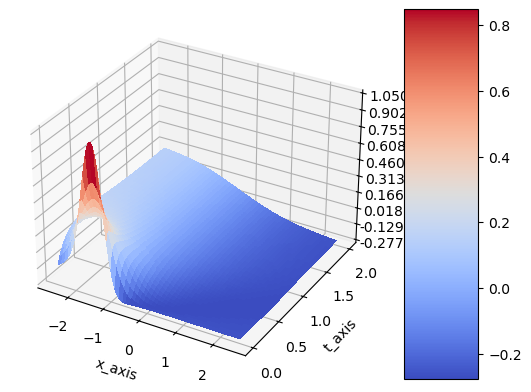

In [204]:
# Plotting the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Creating meshgrid for visualization
x_visual = np.arange(-2.5 , 2.5, 0.002)
t_visual = np.arange(0, 2, 0.002)
ms_x_visual, ms_t_visual = np.meshgrid(x_visual, t_visual)
## np.ravel returns a flattened and contiguous 1-D array containing the elements of the input.
## A copy is created only if necessary.
x_visual = np.ravel(ms_x_visual).reshape(-1, 1)
t_visual = np.ravel(ms_t_visual).reshape(-1, 1)

# Converting to PyTorch tensors
pt_x_visual = Variable(torch.from_numpy(x_visual).float(), requires_grad=True).to(device)
pt_t_visual = Variable(torch.from_numpy(t_visual).float(), requires_grad=True).to(device)

# Obtaining network predictions
## In the function net(pt_x_visualization, pt_t_visualization), the training process updates the parameters represented by theta.
pt_u_visual = net(pt_x_visual, pt_t_visual)
u_visual = pt_u_visual.data.cpu().numpy()
ms_u_visual = u_visual.reshape(ms_x_visual.shape)

# Plotting the surface
surf = ax.plot_surface(ms_x_visual, ms_t_visual, ms_u_visual, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0003f'))
ax.set_xlabel("x_axis")
ax.set_ylabel("t_axis")


# Adding colorbar for reference
fig.colorbar(surf, shrink=1, aspect=5)

# Displaying the plot
plt.show()

### 3.6.3 Comparing Training set with Actual Solution Graph

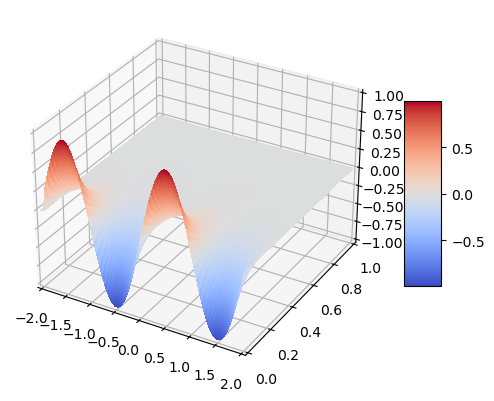

In [206]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Parameter setting
terminal_time = 1  # terminal time
num_spatial_values = 80  # spatial values for FEM
num_time_values = 1600  # time values/hops; (time_values ~ spatial_values^2)
s_value = 0.25  # s_value := k * ( (dt) / (dx)^2 )

# Uniform mesh
x_values = np.linspace(-2, 2, num_spatial_values)

# Time discretization
time_values = np.linspace(0, terminal_time, num_time_values)

# Definition of the solution u(x, t) to u_t = k * u_xx
u_values = np.zeros((num_spatial_values, num_time_values + 1))  # array to store values of the solution

# Finite Difference Scheme:

u_values[:, 0] = np.sin(np.pi * x_values)  # x_values * (x_values - 1)  # initial condition

for m in range(num_time_values):
    for j in range(1, num_spatial_values - 1):
        if j == 1 or j == num_spatial_values - 1:
            u_values[j, m] = 0  ## Boundary condition
        else:
            u_values[j, m + 1] = u_values[j, m] + s_value * (
                    u_values[j + 1, m] - 2 * u_values[j, m] + u_values[j - 1, m]) ##Inner domain values

# Plot 3D surface
T, X = np.meshgrid(time_values, x_values)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(left=-2, right=2)
ax.set_ylim3d(bottom=0, top=1)
ax.set_zlim3d(bottom=-1, top=1)
surf = ax.plot_surface(X, T, u_values[:, :1600], rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


### 3.6.4 Result
For the training set case with 50000 iteration, we easily note that the graph shape looks more similar to the actual one, than the case with 20000 iteration. The PINN (Physics-Informed Neural Network) method has the potential to improve the error bound as much as possible by increasing the number of iterations.

# 4. Reference

Files of tutorial :

[1] https://github.com/nanditadoloi/PINN/blob/main/solve_PDE_NN.ipynb

[2] https://services.math.duke.edu/education/baltimore/sample.html

[3] 'TwoDNSCH.py' file by Kevin

Paper :

[1] 'Proposal for quantitative benchmark
computations of bubble dynamics' by S. Hysing, S. Turek, D. Kuzmin, N. Parolini, E. Burman, S. Ganesank, and L. Tobiska